In [1]:
#import libs
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import rcParams
from matplotlib import patches
import scipy.io
import astropy.constants as const
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
import fitting_template
import importlib
#from IPython.display import display, Math
from astropy.modeling import models, fitting, Fittable1DModel, Parameter
from scipy.optimize import curve_fit
importlib.reload(fitting_template)
import fitting_template
from fitting_template import FeXII_fit
from fitting_template import myGaussian1D
import pandas as pd
from scipy.integrate import simps
import h5py
plt.style.use('science')
rcParams['axes.linewidth'] = 1.2
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'cm'

In [87]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']


In [3]:
c = const.c.cgs.value
amu = const.u.cgs.value
k_B = const.k_B.cgs.value
hplanck = const.h.cgs.value

In [2]:
#read dataset
data_set = scipy.io.readsav('../src/final_data_all_average.save',verbose = True,python_dict=True)

--------------------------------------------------
Date: Sat Jul  4 12:55:49 2020
User: elandi
Host: srbwks2017-0037.engin.umich.edu
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: darwin
IDL Version: 8.7.2
--------------------------------------------------
Successfully read 14 records of which:
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - wvl [<class 'numpy.ndarray'>]
 - final_disk [<class 'numpy.ndarray'>]
 - final_limb [<class 'numpy.ndarray'>]
 - r_disk [<class 'numpy.ndarray'>]
 - dr_disk [<class 'numpy.ndarray'>]
 - r_limb [<class 'numpy.ndarray'>]
 - dr_limb [<class 'numpy.ndarray'>]
 - rsun [<class 'numpy.float32'>]
 - drsun [<class 'numpy.float32'>]
 - units [<class 'bytes'>]
 - new_data_offset [<class 'numpy.ndarray'>]
--------------------------------------------------


In [673]:
data_set["rsun"]

966.63

In [314]:
bk = h5py.File('../save/FeXII_new_new_bk.h5', 'w')

In [4]:
#correct slit tilt
def correct_tilt(wvl_old,data_input):
    data_2d = data_input.copy()
    #c1 = 0.0002037
    #c2 = -4.6065e-8
    c1 = 0.1415e-3
    c2 = -0.0205e-6
    
    for ii in range(512):
        #wvl_cor = c1*(ii+512) + c2*((ii+512)**2) - c1*512. - c2*512.**2
        wvl_cor = c1*ii + c2*np.square(ii)
        data_2d[ii,:] = np.interp(wvl_old, wvl_old - wvl_cor,data_2d[ii,:])
        
    return data_2d

In [5]:
#data mask
data_masked = ma.masked_less(data_set["new_data_offset"], -7/600)

#true data 
#for Fe XII 192 & 193, image 93, 94, and 95 are not saturated
data_disk_5 = data_masked[[0,1,2],:,:]
data_disk_6 = data_masked[[59,60,61],:,:]
data_disk_11 = data_masked[[93,94,95],:,:]
data_limb_all = data_masked[np.r_[3:5,6:14,15:18,19:22,23:59,62:64,65:93,96:152],:,:]
data_limb = data_masked[np.r_[96:152],:,:]
data_limb_single = data_masked[96,:,:]
data_disk_all = data_masked[[0,1,2,59,60,61,93,94,95],:,:]

#readout noise
readout_noise = np.zeros((4096))
readout_noise[0:1024] = 2.26 * np.ones(1024)
readout_noise[1024:2048] = 2.29 * np.ones(1024)
readout_noise[2048:3072] = 2.37 * np.ones(1024)
readout_noise[3072:] = 2.24 * np.ones(1024)

#average in time
data_disk_5_aver = np.mean(data_disk_5,axis = 0)
data_disk_5_aver = np.nan_to_num(data_disk_5_aver,neginf=0.,posinf=0.)
data_disk_5_cor = correct_tilt(data_set["wvl"],data_disk_5_aver[3:515,:])

data_disk_6_aver = np.mean(data_disk_6,axis = 0)
data_disk_6_aver = np.nan_to_num(data_disk_6_aver,neginf=0.,posinf=0.)
data_disk_6_cor = correct_tilt(data_set["wvl"],data_disk_6_aver[3:515,:])

data_disk_11_aver = np.mean(data_disk_11,axis = 0)
data_disk_11_aver = np.nan_to_num(data_disk_11_aver,neginf=0.,posinf=0.)
data_disk_11_cor = correct_tilt(data_set["wvl"],data_disk_11_aver[3:515,:])

data_disk_aver_all = np.mean(data_disk_all,axis=0)
data_disk_aver_all = np.nan_to_num(data_disk_aver_all,neginf=0.,posinf=0.)
data_disk_cor_all = correct_tilt(data_set["wvl"],data_disk_aver_all[3:515,:])

data_limb_aver = np.mean(data_limb,axis=0)
data_limb_aver = np.nan_to_num(data_limb_aver,neginf=0.,posinf=0.)
data_limb_cor = correct_tilt(data_set["wvl"],data_limb_aver[3:515,:])
data_limb_single_cor = correct_tilt(data_set["wvl"],data_limb_single[3:515,:])

data_limb_err_sq = data_limb[:,3:515,:]* 600 + np.square(readout_noise)[np.newaxis,np.newaxis,:]
data_limb_err_sq = np.nan_to_num(data_limb_err_sq,neginf=0.,posinf=0.)
data_limb_err_sq_mask = np.logical_not(data_limb_err_sq.mask) * 1
data_limb_err_aver = np.sqrt(np.sum(data_limb_err_sq ,axis = 0))/np.sum(data_limb_err_sq_mask, axis = 0)/600

#estimate stray light
data_stray_5 = 0.02 * np.mean(data_disk_5_cor[109:,],axis=0)
data_stray_5 = np.nan_to_num(data_stray_5,neginf=0.,posinf=0.)

data_stray_6 = 0.02 * np.mean(data_disk_6_cor[109:,],axis=0)
data_stray_6 = np.nan_to_num(data_stray_6,neginf=0.,posinf=0.)

data_stray_11 = 0.02 * np.mean(data_disk_11_cor[109:,],axis=0)
data_stray_11 = np.nan_to_num(data_stray_11,neginf=0.,posinf=0.)

data_stray_all = 0.02 * np.mean(data_disk_cor_all[109:,],axis=0)
data_stray_all = np.nan_to_num(data_stray_all,neginf=0.,posinf=0.)

data_disk_comp = np.mean(data_disk_11_cor[22:112,:],axis = 0)
data_limb_comp = np.mean(data_limb_cor[422:512,:],axis = 0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt


In [6]:
save_file = h5py.File('../save/FeXII_spec.h5', 'w')
save_file.create_dataset("data_limb_cor",data=data_limb_cor)
save_file.create_dataset("data_limb_err_aver",data=data_limb_err_aver)
save_file.create_dataset("wvl",data=np.copy(data_set["wvl"]))
save_file.close()

In [793]:
np.argmin(np.abs(data_set['wvl'] - 197.86))

1423

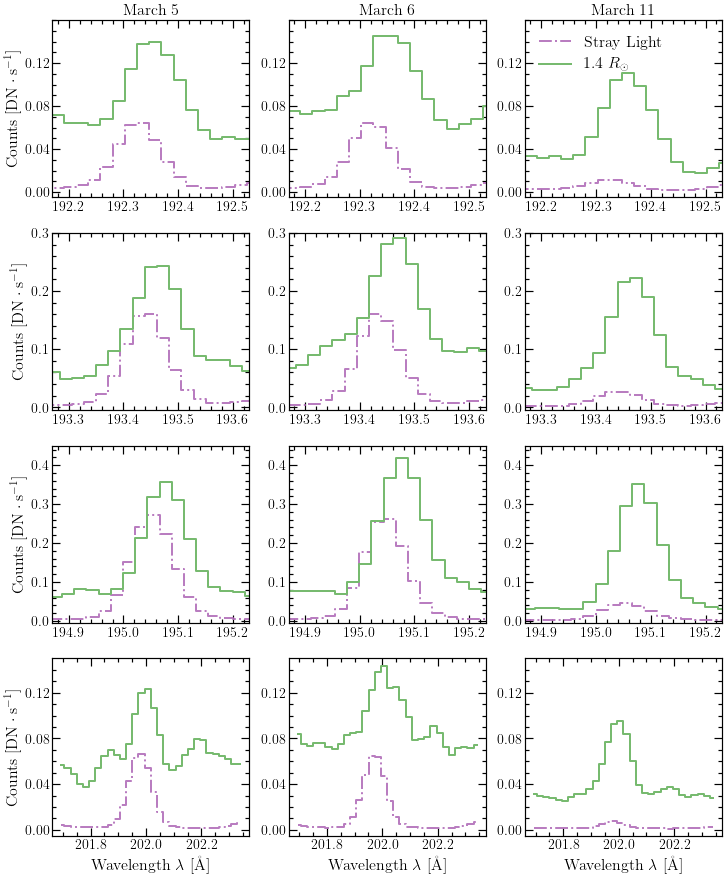

In [181]:
fig, axes = plt.subplots(4,3,figsize=(12,15))
ln1, = axes[0,0].step(data_set['wvl'][1160:1190],data_stray_5[1160:1190],where="mid",color="#b26fba",alpha=0.9,label="Stray Light",lw=2,ls="-.")
ln2, = axes[0,0].step(data_set['wvl'][1160:1190],np.mean(data_masked[3:59,100:120,1160:1190],axis=(0,1)),where="mid",color="#77ba6f",
                     label="1.4 $R_\odot$",lw=2)
axes[0,0].set_title('March 5',fontsize=16)
axes[0,0].set_ylim(-0.005,0.16)
axes[0,0].set_yticks([0,0.04,0.08,0.12])

axes[0,1].step(data_set['wvl'][1160:1190],data_stray_6[1160:1190],where="mid",color="#b26fba",alpha=0.9,lw=2,ls="-.")
axes[0,1].step(data_set['wvl'][1160:1190],np.mean(data_masked[62:93,100:120,1160:1190],axis=(0,1)),where="mid",color="#77ba6f",lw=2)
axes[0,1].set_title('March 6',fontsize=16)
axes[0,1].set_ylim(-0.005,0.16)
axes[0,1].set_yticks([0,0.04,0.08,0.12])

axes[0,2].step(data_set['wvl'][1160:1190],data_stray_11[1160:1190],where="mid",color="#b26fba",alpha=0.9,lw=2,ls="-.")
axes[0,2].step(data_set['wvl'][1160:1190],np.mean(data_masked[96:152,100:120,1160:1190],axis=(0,1)),where="mid",color="#77ba6f",lw=2)
axes[0,2].set_title('March 11',fontsize=16)
axes[0,2].set_ylim(-0.005,0.16)
axes[0,2].set_yticks([0,0.04,0.08,0.12])

axes[1,0].step(data_set['wvl'][1210:1245],data_stray_5[1210:1245],where="mid",color="#b26fba",alpha=0.9,lw=2,ls="-.")
axes[1,0].step(data_set['wvl'][1210:1245],np.mean(data_masked[3:59,100:120,1210:1245],axis=(0,1)),where="mid",color="#77ba6f",lw=2)
axes[1,0].set_ylim(-0.005,0.3)
axes[1,0].set_yticks([0,0.1,0.2,0.3])

axes[1,1].step(data_set['wvl'][1210:1245],data_stray_6[1210:1245],where="mid",color="#b26fba",alpha=0.9,lw=2,ls="-.")
axes[1,1].step(data_set['wvl'][1210:1245],np.mean(data_masked[62:93,100:120,1210:1245],axis=(0,1)),where="mid",color="#77ba6f",lw=2)
axes[1,1].set_ylim(-0.005,0.3)
axes[1,1].set_yticks([0,0.1,0.2,0.3])

axes[1,2].step(data_set['wvl'][1210:1245],data_stray_11[1210:1245],where="mid",color="#b26fba",alpha=0.9,lw=2,ls="-.")
axes[1,2].step(data_set['wvl'][1210:1245],np.mean(data_masked[96:152,100:120,1210:1245],axis=(0,1)),where="mid",color="#77ba6f",lw=2)
axes[1,2].set_ylim(-0.005,0.3)
axes[1,2].set_yticks([0,0.1,0.2,0.3])

axes[2,0].step(data_set['wvl'][1285:1315],data_stray_5[1285:1315],where="mid",color="#b26fba",alpha=0.9,lw=2,ls="-.")
axes[2,0].step(data_set['wvl'][1285:1315],np.mean(data_masked[3:59,100:120,1285:1315],axis=(0,1)),where="mid",color="#77ba6f",lw=2)
axes[2,0].set_ylim(-0.005,0.45)

axes[2,1].step(data_set['wvl'][1285:1315],data_stray_6[1285:1315],where="mid",color="#b26fba",alpha=0.9,lw=2,ls="-.")
axes[2,1].step(data_set['wvl'][1285:1315],np.mean(data_masked[62:93,100:120,1285:1315],axis=(0,1)),where="mid",color="#77ba6f",lw=2)
axes[2,1].set_ylim(-0.005,0.45)

axes[2,2].step(data_set['wvl'][1285:1315],data_stray_11[1285:1315],where="mid",color="#b26fba",alpha=0.9,lw=2,ls="-.")
axes[2,2].step(data_set['wvl'][1285:1315],np.mean(data_masked[96:152,100:120,1285:1315],axis=(0,1)),where="mid",color="#77ba6f",lw=2)
axes[2,2].set_ylim(-0.005,0.45)

axes[3,0].step(data_set['wvl'][1595:1625],data_stray_5[1595:1625],where="mid",color="#b26fba",alpha=0.9,lw=2,ls="-.")
axes[3,0].step(data_set['wvl'][1595:1625],np.mean(data_masked[3:59,100:120,1595:1625],axis=(0,1)),where="mid",color="#77ba6f",lw=2)
axes[3,0].set_ylim(-0.005,0.15)
axes[3,0].set_yticks([0,0.04,0.08,0.12])

axes[3,1].step(data_set['wvl'][1595:1625],data_stray_6[1595:1625],where="mid",color="#b26fba",alpha=0.9,lw=2,ls="-.")
axes[3,1].step(data_set['wvl'][1595:1625],np.mean(data_masked[62:93,100:120,1595:1625],axis=(0,1)),where="mid",color="#77ba6f",lw=2)
axes[3,1].set_ylim(-0.005,0.15)
axes[3,1].set_yticks([0,0.04,0.08,0.12])

axes[3,2].step(data_set['wvl'][1595:1625],data_stray_11[1595:1625],where="mid",color="#b26fba",alpha=0.9,lw=2,ls="-.")
axes[3,2].step(data_set['wvl'][1595:1625],np.mean(data_masked[96:152,100:120,1595:1625],axis=(0,1)),where="mid",color="#77ba6f",lw=2)
axes[3,2].set_ylim(-0.005,0.15)
axes[3,2].set_yticks([0,0.04,0.08,0.12])

for ax_ in (axes[0,0],axes[1,0],axes[2,0],axes[3,0]):
    ax_.set_ylabel(r'Counts [$\rm DN \cdot s^{-1}]$',fontsize=16)

for ii in range(4):
    for jj in range(1,3):
        pass
        #axes[ii,jj].set_yticks([])
        
for ii in range(3):
    axes[3,ii].set_xlabel(r'Wavelength $\lambda\ [\mathrm{\AA}]$',fontsize=16)

for ax_ in axes.flatten():
    ax_.tick_params(labelsize=14)
    ax_.tick_params(which="major",width=1.2,length=8)
    ax_.tick_params(which="minor",width=1.2,length=4)
    #ax_.grid('on')
    #ax_.xaxis.set_minor_locator(AutoMinorLocator(5))
    #ax_.yaxis.set_minor_locator(AutoMinorLocator(5))
    
    
for ax_ in axes[0,:]:
    ax_.set_xlim(192.35-0.18,192.35+0.18)
    
for ax_ in axes[1,:]:
    ax_.set_xlim(193.45-0.18,193.45+0.18)
    
for ax_ in axes[2,:]:
    ax_.set_xlim(195.05-0.18,195.05+0.18)
    
leg = [ln1,ln2]
axes[0,2].legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 16,frameon=False)
    
#plt.subplots_adjust(bottom = 0.05,left=0.1,top=0.97,right=0.97)
plt.savefig(fname = '../figs/stray.pdf', dpi = 300, format = 'pdf')

In [9]:
data_limb_192 = data_limb_cor[:,1160:1190] 
#data_limb_192_bs = data_limb_cor[:,1160:1190] 
#data_limb_192_bbs = data_limb_cor[:,1160:1190]
data_limb_192_err = data_limb_err_aver[:,1160:1190]

data_limb_193 = data_limb_cor[:,1210:1245] 
#data_limb_193_bs = data_limb_cor[:,1210:1245] 
#data_limb_193_bbs = data_limb_cor[:,1210:1245] 
data_limb_193_err = data_limb_err_aver[:,1210:1245]

data_limb_195 = data_limb_cor[:,1285:1315] 
#data_limb_195_bs = data_limb_cor[:,1285:1315] 
#data_limb_195_bbs = data_limb_cor[:,1285:1315] 
data_limb_195_err = data_limb_err_aver[:,1285:1315]

data_limb_202 = data_limb_cor[:,1595:1620] 
#data_limb_202_bs = data_limb_cor[:,1595:1620] 
#data_limb_202_bbs = data_limb_cor[:,1595:1620]
data_limb_202_err = data_limb_err_aver[:,1595:1620]

data_limb_185 = data_limb_cor[:,845:860]
data_limb_185_err = data_limb_err_aver[:,845:860]
data_limb_185_single = data_limb_single_cor[:,845:860]

data_limb_186_fe8 = data_limb_cor[:,905:925]
data_limb_186_fe8_err = data_limb_err_aver[:,905:925]
data_limb_186_fe8_single = data_limb_single_cor[:,905:925]

data_limb_186_fe12 = data_limb_cor[:,921:940]
data_limb_186_fe12_err = data_limb_err_aver[:,921:940]

In [10]:
data_limb_184 = data_limb_cor[:,810:833]
data_limb_184_err = data_limb_err_aver[:,810:833]

data_limb_197 = data_limb_cor[:,1410:1440]
data_limb_197_err = data_limb_err_aver[:,1410:1440]

In [11]:
#A function to average every N rows...
def avg_new(my_array, N=2):
    return np.mean(my_array.reshape(-1,N,my_array.shape[-1]),axis=1)

def avg_err(my_array, N=2):
    my_reshape_sq = np.square(my_array.reshape(-1,N,my_array.shape[-1]))
    mask_reshape_sq = np.logical_not(my_reshape_sq.mask) * 1
    return np.sqrt(np.sum(my_reshape_sq, axis = 1))/np.sum(mask_reshape_sq, axis = 1)

In [12]:
data_192_aver = avg_new(data_limb_192,N=16)[:,5:23]
data_192_aver_2 = avg_new(data_limb_192,N=2)[:,5:23]
data_192_aver_4 = avg_new(data_limb_192,N=4)[:,5:23]
data_192_aver_8 = avg_new(data_limb_192,N=8)[:,5:23]
data_192_aver_32 = avg_new(data_limb_192,N=32)[:,5:23]
#data_192_bs_aver = avg_new(data_limb_192_bs,N=16)[:,5:23]
#data_192_bbs_aver = avg_new(data_limb_192_bbs,N=16)[:,5:23]

data_193_aver = avg_new(data_limb_193,N=16)[:,7:24]
data_193_aver_2 = avg_new(data_limb_193,N=2)[:,7:24]
data_193_aver_4 = avg_new(data_limb_193,N=4)[:,7:24]
data_193_aver_8 = avg_new(data_limb_193,N=8)[:,7:24]
data_193_aver_32 = avg_new(data_limb_193,N=32)[:,7:24]
#data_193_bs_aver = avg_new(data_limb_193_bs,N=16)[:,7:24]
#data_193_bbs_aver = avg_new(data_limb_193_bbs,N=16)[:,7:24]

data_195_aver = avg_new(data_limb_195,N=16)[:,3:22]
data_195_aver_2 = avg_new(data_limb_195,N=2)[:,3:22]
data_195_aver_4 = avg_new(data_limb_195,N=4)[:,3:22]
data_195_aver_8 = avg_new(data_limb_195,N=8)[:,3:22]
data_195_aver_32 = avg_new(data_limb_195,N=32)[:,3:22]
#data_195_bs_aver = avg_new(data_limb_195_bs,N=16)[:,3:22]
#data_195_bbs_aver = avg_new(data_limb_195_bbs,N=16)[:,3:22]

data_202_aver = avg_new(data_limb_202,N=16)
data_202_aver_2 = avg_new(data_limb_202,N=2)
data_202_aver_4 = avg_new(data_limb_202,N=4)
data_202_aver_8 = avg_new(data_limb_202,N=8)
data_202_aver_32 = avg_new(data_limb_202,N=32)
#data_202_bs_aver = avg_new(data_limb_202_bs,N=16)
#data_202_bbs_aver = avg_new(data_limb_202_bbs,N=16)

data_185_aver_2 = avg_new(data_limb_185,N=2)
data_185_aver_4 = avg_new(data_limb_185,N=4)
data_185_aver_8 = avg_new(data_limb_185,N=8)

data_186_fe8_aver_2 = avg_new(data_limb_186_fe8,N=2)
data_186_fe8_aver_4 = avg_new(data_limb_186_fe8,N=4)
data_186_fe8_aver_8 = avg_new(data_limb_186_fe8,N=8)

data_186_fe12_aver_2 = avg_new(data_limb_186_fe12,N=2)
data_186_fe12_aver_4 = avg_new(data_limb_186_fe12,N=4)
data_186_fe12_aver_8 = avg_new(data_limb_186_fe12,N=8)


In [13]:
data_184_aver = avg_new(data_limb_184,N=32)
data_197_aver = avg_new(data_limb_197,N=32)

In [14]:
data_192_aver_err = avg_err(data_limb_192_err,N=16)[:,5:23]
data_192_aver_2_err = avg_err(data_limb_192_err,N=2)[:,5:23]
data_192_aver_4_err = avg_err(data_limb_192_err,N=4)[:,5:23]
data_192_aver_8_err = avg_err(data_limb_192_err,N=8)[:,5:23]
data_192_aver_32_err = avg_err(data_limb_192_err,N=32)[:,5:23]

data_193_aver_err = avg_err(data_limb_193_err,N=16)[:,7:24]
data_193_aver_2_err = avg_err(data_limb_193_err,N=2)[:,7:24]
data_193_aver_4_err = avg_err(data_limb_193_err,N=4)[:,7:24]
data_193_aver_8_err = avg_err(data_limb_193_err,N=8)[:,7:24]
data_193_aver_32_err = avg_err(data_limb_193_err,N=32)[:,7:24]

data_195_aver_err = avg_err(data_limb_195_err,N=16)[:,3:22]
data_195_aver_2_err = avg_err(data_limb_195_err,N=2)[:,3:22]
data_195_aver_4_err = avg_err(data_limb_195_err,N=4)[:,3:22]
data_195_aver_8_err = avg_err(data_limb_195_err,N=8)[:,3:22]
data_195_aver_32_err = avg_err(data_limb_195_err,N=32)[:,3:22]

data_202_aver_err = avg_err(data_limb_202_err,N=16)
data_202_aver_2_err = avg_err(data_limb_202_err,N=2)
data_202_aver_4_err = avg_err(data_limb_202_err,N=4)
data_202_aver_8_err = avg_err(data_limb_202_err,N=8)
data_202_aver_32_err = avg_err(data_limb_202_err,N=32)

data_185_aver_2_err = avg_err(data_limb_185_err,N=2)
data_185_aver_4_err = avg_err(data_limb_185_err,N=4)
data_185_aver_8_err = avg_err(data_limb_185_err,N=8)

data_186_fe8_aver_2_err = avg_err(data_limb_186_fe8_err,N=2)
data_186_fe8_aver_4_err = avg_err(data_limb_186_fe8_err,N=4)
data_186_fe8_aver_8_err = avg_err(data_limb_186_fe8_err,N=8)

data_186_fe12_aver_2_err = avg_err(data_limb_186_fe12_err,N=2)
data_186_fe12_aver_4_err = avg_err(data_limb_186_fe12_err,N=4)
data_186_fe12_aver_8_err = avg_err(data_limb_186_fe12_err,N=8)



In [15]:
data_184_aver_err = avg_err(data_limb_184_err,N=32)
data_197_aver_err = avg_err(data_limb_197_err,N=32)

In [16]:
calib_eis = scipy.io.readsav('../save/dn_to_phot.save',verbose = True,python_dict=True)

--------------------------------------------------
Date: Wed Oct  1 06:36:50 2008
User: landi
Host: poppeo
--------------------------------------------------
Format: 9
Architecture: x86
Operating System: linux
IDL Version: 6.2
--------------------------------------------------
Successfully read 11 records of which:
 - 1 are of type VERSION
 - 1 are of type NOTICE
 - 1 are of type TIMESTAMP
 - 7 are of type VARIABLE
--------------------------------------------------
Available variables:
 - wvl_1 [<class 'numpy.ndarray'>]
 - wvl_2 [<class 'numpy.ndarray'>]
 - conv_erg_1 [<class 'numpy.ndarray'>]
 - conv_phot_1 [<class 'numpy.ndarray'>]
 - conv_erg_2 [<class 'numpy.ndarray'>]
 - conv_phot_2 [<class 'numpy.ndarray'>]
 - readme [<class 'bytes'>]
--------------------------------------------------


(0, 5)

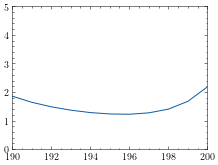

In [40]:
plt.plot(calib_eis["wvl_1"],calib_eis["conv_phot_1"])
plt.xlim(190,200)
plt.ylim(0,5)

In [17]:
wvl_192 = data_set["wvl"][1160:1190][5:23]
wvl_193 = data_set["wvl"][1210:1245][7:24]
wvl_195 = data_set["wvl"][1285:1315][3:22]
wvl_202 = data_set["wvl"][1595:1620]
wvl_185 = data_set["wvl"][845:860]
wvl_186_fe8 = data_set["wvl"][905:925]
wvl_186_fe12 = data_set["wvl"][921:940]


#import calibration file
calib_eis = scipy.io.readsav('../save/dn_to_phot.save',verbose = False,python_dict=True)
from scipy import interpolate
f_1 = interpolate.interp1d(calib_eis["wvl_1"],calib_eis["conv_erg_1"])
f_2 = interpolate.interp1d(calib_eis["wvl_2"],calib_eis["conv_erg_2"])

#calibrate
data_192_erg = data_192_aver * f_1(wvl_192)[np.newaxis,:] * 0.748
data_192_erg_2 = data_192_aver_2 * f_1(wvl_192)[np.newaxis,:] * 0.748
data_192_erg_4 = data_192_aver_4 * f_1(wvl_192)[np.newaxis,:] * 0.748
data_192_erg_8 = data_192_aver_8 * f_1(wvl_192)[np.newaxis,:] * 0.748
data_192_erg_32 = data_192_aver_32 * f_1(wvl_192)[np.newaxis,:] * 0.748
data_192_erg_1 = data_limb_192[:,5:23] * f_1(wvl_192)[np.newaxis,:] * 0.748
#data_192_bs_erg = data_192_bs_aver * f_1(wvl_192)[np.newaxis,:]
#data_192_bbs_erg = data_192_bbs_aver * f_1(wvl_192)[np.newaxis,:]

data_193_erg = data_193_aver * f_1(wvl_193)[np.newaxis,:] * 0.742
data_193_erg_2 = data_193_aver_2 * f_1(wvl_193)[np.newaxis,:] * 0.742
data_193_erg_4 = data_193_aver_4 * f_1(wvl_193)[np.newaxis,:] * 0.742
data_193_erg_8 = data_193_aver_8 * f_1(wvl_193)[np.newaxis,:] * 0.742
data_193_erg_32 = data_193_aver_32 * f_1(wvl_193)[np.newaxis,:] * 0.742
#data_193_bs_erg = data_193_bs_aver * f_1(wvl_193)[np.newaxis,:]
#data_193_bbs_erg = data_193_bbs_aver * f_1(wvl_193)[np.newaxis,:]

data_195_erg = data_195_aver * f_1(wvl_195)[np.newaxis,:] * 0.765
data_195_erg_2 = data_195_aver_2 * f_1(wvl_195)[np.newaxis,:] * 0.765
data_195_erg_4 = data_195_aver_4 * f_1(wvl_195)[np.newaxis,:] * 0.765
data_195_erg_8 = data_195_aver_8 * f_1(wvl_195)[np.newaxis,:] * 0.765
data_195_erg_32 = data_195_aver_32 * f_1(wvl_195)[np.newaxis,:] * 0.765
data_195_erg_1 = data_limb_195[:,3:22] * f_1(wvl_195)[np.newaxis,:] * 0.765
#data_195_bs_erg = data_195_bs_aver * f_1(wvl_195)[np.newaxis,:]
#data_195_bbs_erg = data_195_bbs_aver * f_1(wvl_195)[np.newaxis,:]

data_202_erg = data_202_aver * f_1(wvl_202)[np.newaxis,:] * 0.693
data_202_erg_2 = data_202_aver_2 * f_1(wvl_202)[np.newaxis,:] * 0.693
data_202_erg_4 = data_202_aver_4 * f_1(wvl_202)[np.newaxis,:] * 0.693
data_202_erg_8 = data_202_aver_8 * f_1(wvl_202)[np.newaxis,:] * 0.693
data_202_erg_32 = data_202_aver_32 * f_1(wvl_202)[np.newaxis,:] * 0.693
#data_202_bs_erg = data_202_bs_aver * f_1(wvl_202)[np.newaxis,:]
#data_202_bbs_erg = data_202_bbs_aver * f_1(wvl_202)[np.newaxis,:]

data_185_erg = data_limb_185 * f_1(wvl_185)[np.newaxis,:] * 1.078
data_185_erg_2 = data_185_aver_2 * f_1(wvl_185)[np.newaxis,:] * 1.078
data_185_erg_4 = data_185_aver_4 * f_1(wvl_185)[np.newaxis,:] * 1.078
data_185_erg_8 = data_185_aver_8 * f_1(wvl_185)[np.newaxis,:] * 1.078
data_185_erg_single = data_limb_185_single * f_1(wvl_185)[np.newaxis,:] * 1.078

data_186_fe8_erg = data_limb_186_fe8 * f_1(wvl_186_fe8)[np.newaxis,:] * 1.002
data_186_fe8_erg_2 = data_186_fe8_aver_2 * f_1(wvl_186_fe8)[np.newaxis,:] * 1.002
data_186_fe8_erg_4 = data_186_fe8_aver_4 * f_1(wvl_186_fe8)[np.newaxis,:] * 1.002
data_186_fe8_erg_8 = data_186_fe8_aver_8 * f_1(wvl_186_fe8)[np.newaxis,:] * 1.002
data_186_fe8_erg_single = data_limb_186_fe8_single * f_1(wvl_186_fe8)[np.newaxis,:] * 1.002

data_186_fe12_erg = data_limb_186_fe12 * f_1(wvl_186_fe12)[np.newaxis,:] * 0.982
data_186_fe12_erg_2 = data_186_fe12_aver_2 * f_1(wvl_186_fe12)[np.newaxis,:] * 0.982
data_186_fe12_erg_4 = data_186_fe12_aver_4 * f_1(wvl_186_fe12)[np.newaxis,:] * 0.982
data_186_fe12_erg_8 = data_186_fe12_aver_8 * f_1(wvl_186_fe12)[np.newaxis,:] * 0.982

In [18]:
wvl_184 = data_set["wvl"][810:833]
wvl_197 = data_set["wvl"][1410:1440]
data_184_erg = data_184_aver * f_1(wvl_184)[np.newaxis,:] * 1.11016
data_197_erg = data_197_aver * f_1(wvl_197)[np.newaxis,:] * 0.871292

In [19]:
data_192_erg_err = data_192_aver_err * f_1(wvl_192)[np.newaxis,:] * 0.748
data_192_erg_2_err = data_192_aver_2_err * f_1(wvl_192)[np.newaxis,:] * 0.748
data_192_erg_4_err = data_192_aver_4_err * f_1(wvl_192)[np.newaxis,:] * 0.748
data_192_erg_8_err = data_192_aver_8_err * f_1(wvl_192)[np.newaxis,:] * 0.748
data_192_erg_32_err = data_192_aver_32_err * f_1(wvl_192)[np.newaxis,:] * 0.748

data_193_erg_err = data_193_aver_err * f_1(wvl_193)[np.newaxis,:] * 0.742
data_193_erg_2_err = data_193_aver_2_err * f_1(wvl_193)[np.newaxis,:] * 0.742
data_193_erg_4_err = data_193_aver_4_err * f_1(wvl_193)[np.newaxis,:] * 0.742
data_193_erg_8_err = data_193_aver_8_err * f_1(wvl_193)[np.newaxis,:] * 0.742
data_193_erg_32_err = data_193_aver_32_err * f_1(wvl_193)[np.newaxis,:] * 0.742

data_195_erg_err = data_195_aver_err * f_1(wvl_195)[np.newaxis,:] * 0.765
data_195_erg_2_err = data_195_aver_2_err * f_1(wvl_195)[np.newaxis,:] * 0.765
data_195_erg_4_err = data_195_aver_4_err * f_1(wvl_195)[np.newaxis,:] * 0.765
data_195_erg_8_err = data_195_aver_8_err * f_1(wvl_195)[np.newaxis,:] * 0.765
data_195_erg_32_err = data_195_aver_32_err * f_1(wvl_195)[np.newaxis,:] * 0.765
data_195_erg_1_err = data_limb_195_err[:,3:22] * f_1(wvl_195)[np.newaxis,:] * 0.765


data_202_erg_err = data_202_aver_err * f_1(wvl_202)[np.newaxis,:] * 0.693
data_202_erg_2_err = data_202_aver_2_err * f_1(wvl_202)[np.newaxis,:] * 0.693
data_202_erg_4_err = data_202_aver_4_err * f_1(wvl_202)[np.newaxis,:] * 0.693
data_202_erg_8_err = data_202_aver_8_err * f_1(wvl_202)[np.newaxis,:] * 0.693
data_202_erg_32_err = data_202_aver_32_err * f_1(wvl_202)[np.newaxis,:] * 0.693

data_185_erg_err = data_limb_185_err * f_1(wvl_185)[np.newaxis,:] * 1.078
data_185_erg_2_err = data_185_aver_2_err * f_1(wvl_185)[np.newaxis,:] * 1.078
data_185_erg_4_err = data_185_aver_4_err * f_1(wvl_185)[np.newaxis,:] * 1.078
data_185_erg_8_err = data_185_aver_8_err * f_1(wvl_185)[np.newaxis,:] * 1.078

data_186_fe8_erg_err = data_limb_186_fe8_err * f_1(wvl_186_fe8)[np.newaxis,:] * 1.002
data_186_fe8_erg_2_err = data_186_fe8_aver_2_err * f_1(wvl_186_fe8)[np.newaxis,:] * 1.002
data_186_fe8_erg_4_err = data_186_fe8_aver_4_err * f_1(wvl_186_fe8)[np.newaxis,:] * 1.002
data_186_fe8_erg_8_err = data_186_fe8_aver_8_err * f_1(wvl_186_fe8)[np.newaxis,:] * 1.002

data_186_fe12_erg_err = data_limb_186_fe12_err * f_1(wvl_186_fe12)[np.newaxis,:] * 0.982
data_186_fe12_erg_2_err = data_186_fe12_aver_2_err * f_1(wvl_186_fe12)[np.newaxis,:] * 0.982
data_186_fe12_erg_4_err = data_186_fe12_aver_4_err * f_1(wvl_186_fe12)[np.newaxis,:] * 0.982
data_186_fe12_erg_8_err = data_186_fe12_aver_8_err * f_1(wvl_186_fe12)[np.newaxis,:] * 0.982

In [20]:
data_184_erg_err = data_184_aver_err * f_1(wvl_184)[np.newaxis,:] * 1.11016
data_197_erg_err = data_197_aver_err * f_1(wvl_197)[np.newaxis,:] * 0.871292

In [21]:
stray_192_erg = data_stray_11[1160:1190][5:23] * f_1(wvl_192) * 0.748
stray_193_erg = data_stray_11[1210:1245][7:24] * f_1(wvl_193) * 0.742
stray_195_erg = data_stray_11[1285:1315][3:22] * f_1(wvl_195) * 0.765
stray_202_erg = data_stray_11[1595:1620] * f_1(wvl_202) * 0.693
stray_185_erg = data_stray_11[845:860] * f_1(wvl_185)* 1.078
stray_186_fe8_erg = data_stray_11[905:925] * f_1(wvl_186_fe8) * 1.002
stray_186_fe12_erg = data_stray_11[921:940] * f_1(wvl_186_fe12) * 0.982

In [22]:
stray_184_erg = data_stray_11[810:833] * f_1(wvl_184) * 1.11016
stray_197_erg = data_stray_11[1410:1440] * f_1(wvl_197) * 0.871292

<myGaussian1D(intensity=0.00395411, mean=192.32307444, fwhm=0.08885611, bg=0.0133224, stray_int=0., stray_fwhm=1., stray_wvl=0.)>

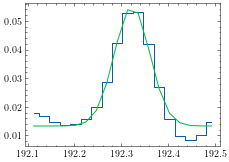

In [23]:
g_init = myGaussian1D(intensity = np.max(stray_192_erg) * np.sqrt(2*np.pi)*0.04, mean=wvl_192[np.argmax(stray_192_erg)], fwhm = 0.06,bg = 0.,
                      stray_int=0,stray_fwhm = 1,stray_wvl=0)
g_init.stray_int.fixed = True
g_init.stray_fwhm.fixed = True
fit_g = fitting.LevMarLSQFitter()
g_192_stray = fit_g(g_init, wvl_192, stray_192_erg)
plt.step(wvl_192,stray_192_erg,where="mid")
plt.plot(wvl_192,g_192_stray(wvl_192))
g_192_stray

<myGaussian1D(intensity=0.00992724, mean=193.44043961, fwhm=0.08870425, bg=0.01510109, stray_int=0., stray_fwhm=1., stray_wvl=0.)>

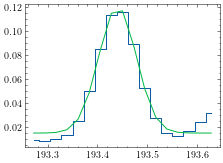

In [24]:
g_init = myGaussian1D(intensity = np.max(stray_193_erg) * np.sqrt(2*np.pi)*0.04, mean=wvl_193[np.argmax(stray_193_erg)], 
                      fwhm = 0.06,bg = 0.,stray_int=0,stray_fwhm = 1,stray_wvl=0)
g_init.stray_int.fixed = True
g_init.stray_fwhm.fixed = True
fit_g = fitting.LevMarLSQFitter()
g_193_stray = fit_g(g_init, wvl_193, stray_193_erg)
plt.step(wvl_193,stray_193_erg,where="mid")
plt.plot(wvl_193,g_193_stray(wvl_193))
g_193_stray

<myGaussian1D(intensity=0.01797782, mean=195.05354742, fwhm=0.0951304, bg=0.00972284, stray_int=0., stray_fwhm=1., stray_wvl=0.)>

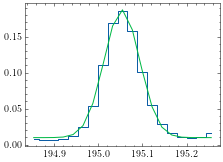

In [25]:
g_init = myGaussian1D(intensity = np.max(stray_195_erg) * np.sqrt(2*np.pi)*0.04, mean=wvl_195[np.argmax(stray_195_erg)], 
                      fwhm = 0.06,bg = 0.,stray_int=0,stray_fwhm = 1,stray_wvl=0)
g_init.stray_int.fixed = True
g_init.stray_fwhm.fixed = True
fit_g = fitting.LevMarLSQFitter()
g_195_stray = fit_g(g_init, wvl_195, stray_195_erg)
plt.step(wvl_195,stray_195_erg,where="mid")
plt.plot(wvl_195,g_195_stray(wvl_195))
g_195_stray

<myGaussian1D(intensity=0.00813216, mean=201.98055237, fwhm=0.09328679, bg=0.01840197, stray_int=0., stray_fwhm=1., stray_wvl=0.)>

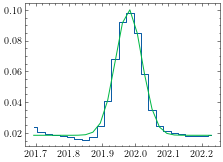

In [26]:
g_init = myGaussian1D(intensity = np.max(stray_202_erg) * np.sqrt(2*np.pi)*0.04, mean=wvl_202[np.argmax(stray_202_erg)],
                      fwhm = 0.06,bg = 0.,stray_int=0,stray_fwhm = 1,stray_wvl=0)
g_init.stray_int.fixed = True
g_init.stray_fwhm.fixed = True
fit_g = fitting.LevMarLSQFitter()
g_202_stray = fit_g(g_init, wvl_202, stray_202_erg)
plt.step(wvl_202,stray_202_erg,where="mid")
plt.plot(wvl_202,g_202_stray(wvl_202))
g_202_stray

<myGaussian1D(intensity=0.0381921, mean=185.14544381, fwhm=0.09432661, bg=0.02975463, stray_int=0., stray_fwhm=1., stray_wvl=0.)>

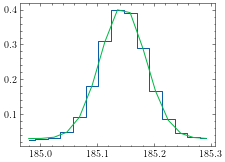

In [27]:
g_init = myGaussian1D(intensity = np.max(stray_185_erg) * np.sqrt(2*np.pi)*0.04, mean=wvl_185[np.argmax(stray_185_erg)], fwhm = 0.06,
                      bg = 0.,stray_int=0,stray_fwhm = 1,stray_wvl=0)
g_init.stray_int.fixed = True
g_init.stray_fwhm.fixed = True
fit_g = fitting.LevMarLSQFitter()
g_185_stray = fit_g(g_init, wvl_185, stray_185_erg)
plt.step(wvl_185,stray_185_erg,where="mid")
plt.plot(wvl_185,g_185_stray(wvl_185))
g_185_stray

<myGaussian1D(intensity=0.02667797, mean=186.53779918, fwhm=0.09640795, bg=0.02225874, stray_int=0., stray_fwhm=1., stray_wvl=0.)>

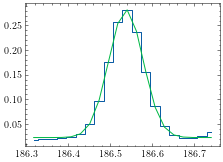

In [28]:
g_init = myGaussian1D(intensity = np.max(stray_186_fe8_erg) * np.sqrt(2*np.pi)*0.04, mean=wvl_186_fe8[np.argmax(stray_186_fe8_erg)], 
                      fwhm = 0.06,bg = 0.,stray_int=0,stray_fwhm = 1,stray_wvl=0)
g_init.stray_int.fixed = True
g_init.stray_fwhm.fixed = True
fit_g = fitting.LevMarLSQFitter()
g_186_fe8_stray = fit_g(g_init, wvl_186_fe8, stray_186_fe8_erg)
plt.step(wvl_186_fe8,stray_186_fe8_erg,where="mid")
plt.plot(wvl_186_fe8,g_186_fe8_stray(wvl_186_fe8))
g_186_fe8_stray

<myGaussian1D(intensity=0.00498328, mean=186.81126865, fwhm=0.11267621, bg=0.01851992, stray_int=0., stray_fwhm=1., stray_wvl=0.)>

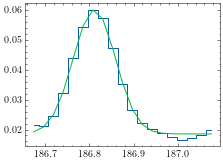

In [29]:
g_init = myGaussian1D(intensity = np.max(stray_186_fe12_erg) * np.sqrt(2*np.pi)*0.04, mean=wvl_186_fe12[np.argmax(stray_186_fe12_erg)], 
                      fwhm = 0.06,bg = 0.,stray_int=0,stray_fwhm = 1,stray_wvl=0)
g_init.stray_int.fixed = True
g_init.stray_fwhm.fixed = True
fit_g = fitting.LevMarLSQFitter()
g_186_fe12_stray = fit_g(g_init, wvl_186_fe12, stray_186_fe12_erg)
plt.step(wvl_186_fe12,stray_186_fe12_erg,where="mid")
plt.plot(wvl_186_fe12,g_186_fe12_stray(wvl_186_fe12))
g_186_fe12_stray

<myGaussian1D(intensity=0.04081929, mean=184.46787245, fwhm=0.09591293, bg=0.03566829, stray_int=0., stray_fwhm=1., stray_wvl=0.)>

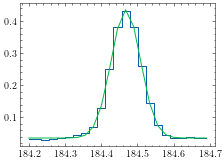

In [30]:
g_init = myGaussian1D(intensity = np.max(stray_184_erg) * np.sqrt(2*np.pi)*0.04, mean=wvl_184[np.argmax(stray_184_erg)], 
                      fwhm = 0.06,bg = 0.,stray_int=0,stray_fwhm = 1,stray_wvl=0)
g_init.stray_int.fixed = True
g_init.stray_fwhm.fixed = True
fit_g = fitting.LevMarLSQFitter()
g_184_stray = fit_g(g_init, wvl_184, stray_184_erg)
plt.step(wvl_184,stray_184_erg,where="mid")
plt.plot(wvl_184,g_184_stray(wvl_184))
g_184_stray

<myGaussian1D(intensity=0.01037269, mean=197.79109564, fwhm=0.09741289, bg=0.0075875, stray_int=0., stray_fwhm=1., stray_wvl=0.)>

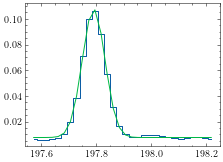

In [31]:
g_init = myGaussian1D(intensity = np.max(stray_197_erg) * np.sqrt(2*np.pi)*0.04, mean=wvl_197[np.argmax(stray_197_erg)], 
                      fwhm = 0.06,bg = 0.,stray_int=0,stray_fwhm = 1,stray_wvl=0)
g_init.stray_int.fixed = True
g_init.stray_fwhm.fixed = True
fit_g = fitting.LevMarLSQFitter()
g_197_stray = fit_g(g_init, wvl_197, stray_197_erg)
plt.step(wvl_197,stray_197_erg,where="mid")
plt.plot(wvl_197,g_197_stray(wvl_197))
g_197_stray

In [32]:
FeXII_192 = FeXII_fit(data_192_erg,wvl_192,[1,192.37,0.04,0.],err = data_192_erg_err,stray_int = g_192_stray.intensity.value, 
                      stray_fwhm= g_192_stray.fwhm.value,stray_wvl = g_192_stray.mean.value)
FeXII_192_bs = FeXII_fit(data_192_erg,wvl_192,[1,192.37,0.04,0.],err = data_192_erg_err,stray_int = 2*g_192_stray.intensity.value, 
                         stray_fwhm= g_192_stray.fwhm.value,stray_wvl = g_192_stray.mean.value)
FeXII_192_bbs = FeXII_fit(data_192_erg,wvl_192,[1,192.37,0.04,0.], err = data_192_erg_err,stray_int = 5*g_192_stray.intensity.value, 
                          stray_fwhm= g_192_stray.fwhm.value,stray_wvl = g_192_stray.mean.value)
#FeXII_192.run_lse()
#FeXII_192_bs.run_lse()
#FeXII_192_bbs.run_lse()
FeXII_192.run_mcmc(stepsize = 1e-3,burnstep = 200,nstep = 3000,lse=True,factor_f=False,credit = 90)
FeXII_192_bs.run_mcmc(stepsize = 1e-3,burnstep = 200,nstep = 3000,lse=True,factor_f=False,credit = 90)
FeXII_192_bbs.run_mcmc(stepsize = 1e-3,burnstep = 500,nstep = 3000,lse=True,factor_f=False,credit = 90)

FeXII_193 = FeXII_fit(data_193_erg,wvl_193,[1,193.45,0.04,0.5],err = data_193_erg_err,stray_int = g_193_stray.intensity.value, 
                      stray_fwhm= g_193_stray.fwhm.value,stray_wvl = g_193_stray.mean.value)
FeXII_193_bs = FeXII_fit(data_193_erg,wvl_193,[1,193.45,0.04,0.5],err = data_193_erg_err,stray_int = 2*g_193_stray.intensity.value, 
                         stray_fwhm= g_193_stray.fwhm.value,stray_wvl = g_193_stray.mean.value)
FeXII_193_bbs = FeXII_fit(data_193_erg,wvl_193,[1,193.45,0.04,0.5],err = data_193_erg_err,stray_int = 5*g_193_stray.intensity.value, 
                          stray_fwhm= g_193_stray.fwhm.value,stray_wvl = g_193_stray.mean.value)
#FeXII_193.run_lse()
#FeXII_193_bs.run_lse()
#FeXII_193_bbs.run_lse()
FeXII_193.run_mcmc(stepsize = 1e-3,burnstep = 200,nstep = 3000,lse=True,factor_f=False,credit = 90)
FeXII_193_bs.run_mcmc(stepsize = 1e-3,burnstep = 200,nstep = 3000,lse=True,factor_f=False,credit = 90)
FeXII_193_bbs.run_mcmc(stepsize = 1e-3,burnstep = 500,nstep = 3000,lse=True,factor_f=False,credit = 90)

FeXII_195 = FeXII_fit(data_195_erg,wvl_195,[1,195.05,0.04,0.5],err = data_195_erg_err,stray_int = g_195_stray.intensity.value, 
                      stray_fwhm= g_195_stray.fwhm.value,stray_wvl = g_195_stray.mean.value)
FeXII_195_bs = FeXII_fit(data_195_erg,wvl_195,[1,195.05,0.04,0.5],err = data_195_erg_err,stray_int = 2*g_195_stray.intensity.value, 
                         stray_fwhm= g_195_stray.fwhm.value,stray_wvl = g_195_stray.mean.value)
FeXII_195_bbs = FeXII_fit(data_195_erg,wvl_195,[1,195.05,0.04,0.5],err = data_195_erg_err,stray_int = 5*g_195_stray.intensity.value, 
                          stray_fwhm= g_195_stray.fwhm.value,stray_wvl = g_195_stray.mean.value)
FeXII_195.run_mcmc(stepsize = 1e-3,burnstep = 200,nstep = 3000,lse=True,factor_f=False,credit = 90)
FeXII_195_bs.run_mcmc(stepsize = 1e-3,burnstep = 200,nstep = 3000,lse=True,factor_f=False,credit = 90)
FeXII_195_bbs.run_mcmc(stepsize = 1e-3,burnstep = 500,nstep = 3000,lse=True,factor_f=False,credit = 90)

FeXIII_202 = FeXII_fit(data_202_erg[:,:-2],wvl_202[:-2],[1,202.01,0.04,0.5],err = data_202_erg_err[:,:-2],stray_int = g_202_stray.intensity.value, 
                       stray_fwhm= g_202_stray.fwhm.value,stray_wvl = g_202_stray.mean.value)
FeXIII_202_bs = FeXII_fit(data_202_erg[:,:-2],wvl_202[:-2],[1,202.01,0.04,0.5],err = data_202_erg_err[:,:-2],stray_int = 2*g_202_stray.intensity.value, 
                          stray_fwhm= g_202_stray.fwhm.value,stray_wvl = g_202_stray.mean.value)
FeXIII_202_bbs = FeXII_fit(data_202_erg[:,:-2],wvl_202[:-2],[1,202.01,0.04,0.5],err = data_202_erg_err[:,:-2],stray_int = 5*g_202_stray.intensity.value, 
                           stray_fwhm= g_202_stray.fwhm.value,stray_wvl = g_202_stray.mean.value)
FeXIII_202.run_mcmc(stepsize = 1e-3,burnstep = 200,nstep = 3000,lse=True,factor_f=False,credit = 90)
FeXIII_202_bs.run_mcmc(stepsize = 1e-3,burnstep = 200,nstep = 3000,lse=True,factor_f=False,credit = 90)
FeXIII_202_bbs.run_mcmc(stepsize = 1e-3,burnstep = 500,nstep = 3000,lse=True,factor_f=False,credit = 90)

 node 81

/anaconda3/lib/python3.7/site-packages/emcee-3.0rc2-py3.7.egg/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars


 node 31

In [819]:
FeX_184 = FeXII_fit(data_184_erg,wvl_184,[1,184.54,0.04,0.],err = data_184_erg_err,stray_int = g_184_stray.intensity.value, 
                      stray_fwhm= g_184_stray.fwhm.value,stray_wvl = g_184_stray.mean.value)
FeX_184.run_mcmc(stepsize = 1e-3,burnstep = 200,nstep = 1000,lse=True,factor_f=False,credit = 90)
FeIX_197 = FeXII_fit(data_197_erg,wvl_197,[1,197.54,0.04,0.],err = data_197_erg_err,stray_int = g_197_stray.intensity.value, 
                      stray_fwhm= g_197_stray.fwhm.value,stray_wvl = g_197_stray.mean.value)
FeIX_197.run_mcmc(stepsize = 1e-3,burnstep = 200,nstep = 1000,lse=True,factor_f=False,credit = 90)

5 fit again
6 fit again
 node 5

/anaconda3/lib/python3.7/site-packages/emcee-3.0rc2-py3.7.egg/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


 node 153 fit again
4 fit again
5 fit again
6 fit again
7 fit again
8 fit again
 node 15

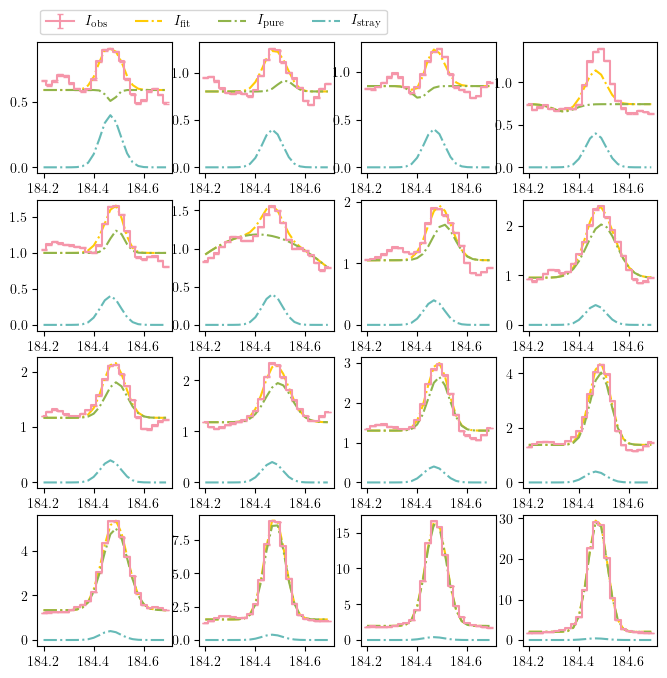

In [820]:
FeX_184.plot(plot_mcmc=True)

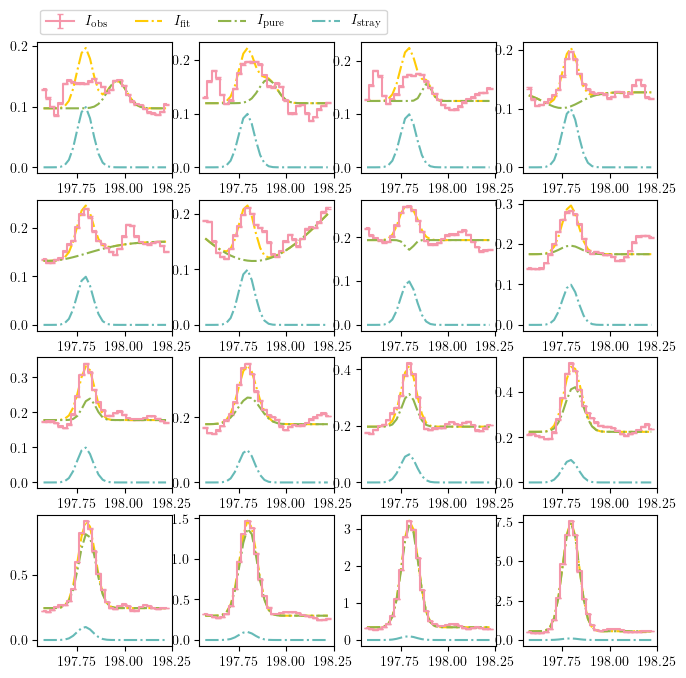

In [821]:
FeIX_197.plot(plot_mcmc=True)

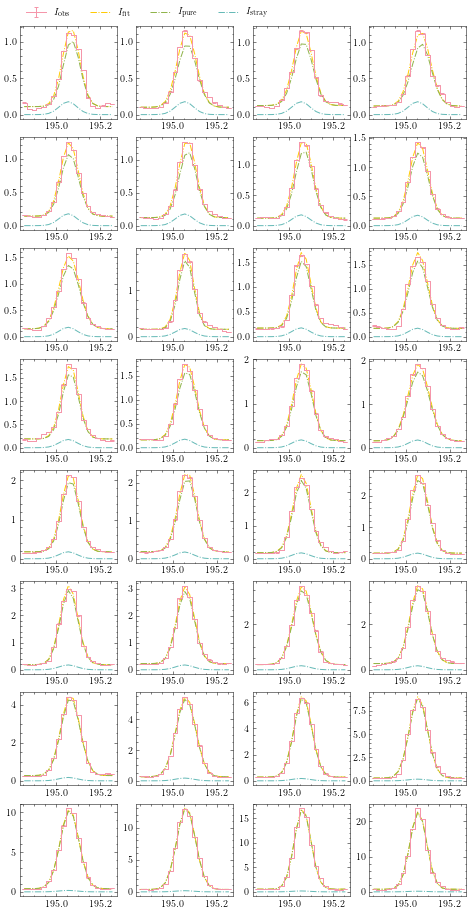

In [36]:
FeXII_195.plot(plot_mcmc=True)

In [579]:
FeXII_192_bbs = FeXII_fit(data_192_erg,wvl_192,[1,192.37,0.04,0.], err = data_192_erg_err,stray_int = 5*g_192_stray.intensity.value, 
                          stray_fwhm= g_192_stray.fwhm.value,stray_wvl = g_192_stray.mean.value)
FeXII_192_bbs.run_mcmc(stepsize = 1e-3,burnstep = 200,nstep = 1000,lse=True,factor_f=True,credit = 90)

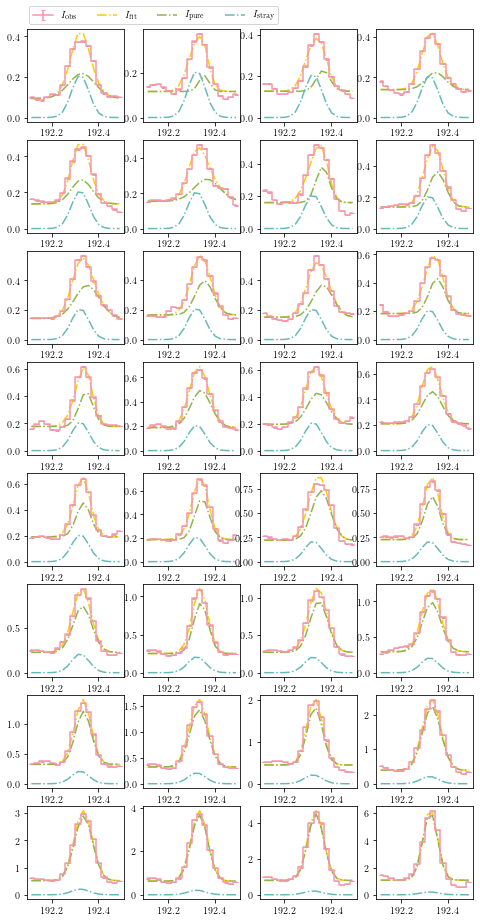

In [584]:
FeXII_192_bbs.plot(plot_mcmc=True)

In [33]:
FeVIII_185_1 = FeXII_fit(data_185_erg[-88:,:],wvl_185,[2,185.15,0.04,0.5],
                        err = data_185_erg_err[-88:,:],stray_int = g_185_stray.intensity.value, stray_fwhm= g_185_stray.fwhm.value)
FeVIII_185_2 = FeXII_fit(data_185_erg_2[-44:,:],wvl_185,[2,185.15,0.04,0.5],
                        err = data_185_erg_2_err[-44:,:],stray_int = g_185_stray.intensity.value, stray_fwhm= g_185_stray.fwhm.value)
FeVIII_185_4 = FeXII_fit(data_185_erg_4[-22:,:],wvl_185,[2,185.15,0.04,0.5],
                        err = data_185_erg_4_err[-22:,:],stray_int = g_185_stray.intensity.value, stray_fwhm= g_185_stray.fwhm.value)
FeVIII_185_8 = FeXII_fit(data_185_erg_8[-11:,:],wvl_185,[2,185.15,0.04,0.5],
                        err = data_185_erg_8_err[-11:,:],stray_int = g_185_stray.intensity.value, stray_fwhm= g_185_stray.fwhm.value)
FeVIII_185_single = FeXII_fit(data_185_erg_single[-88:,:],wvl_185,[2,185.15,0.04,0.5],
                        err = data_185_erg_err[-88:,:],stray_int = g_185_stray.intensity.value, stray_fwhm= g_185_stray.fwhm.value)
FeVIII_185_1.run_lse()
FeVIII_185_2.run_lse()
FeVIII_185_4.run_lse()
FeVIII_185_8.run_lse()
FeVIII_185_single.run_lse()

FeVIII_186_1 = FeXII_fit(data_186_fe8_erg[-88:,:],wvl_186_fe8,[2,186.15,0.04,0.5],
                        err = data_186_fe8_erg_err[-88:,:],stray_int = g_186_fe8_stray.intensity.value, stray_fwhm= g_186_fe8_stray.fwhm.value)
FeVIII_186_2 = FeXII_fit(data_186_fe8_erg_2[-44:,:],wvl_186_fe8,[2,186.15,0.04,0.5],
                        err = data_186_fe8_erg_2_err[-44:,:],stray_int = g_186_fe8_stray.intensity.value, stray_fwhm= g_186_fe8_stray.fwhm.value)
FeVIII_186_4 = FeXII_fit(data_186_fe8_erg_4[-22:,:],wvl_186_fe8,[2,186.15,0.04,0.5],
                        err = data_186_fe8_erg_4_err[-22:,:],stray_int = g_186_fe8_stray.intensity.value, stray_fwhm= g_186_fe8_stray.fwhm.value)
FeVIII_186_8 = FeXII_fit(data_186_fe8_erg_8[-11:,:],wvl_186_fe8,[2,186.15,0.04,0.5],
                        err = data_186_fe8_erg_8_err[-11:,:],stray_int = g_186_fe8_stray.intensity.value, stray_fwhm= g_186_fe8_stray.fwhm.value)
FeVIII_186_single = FeXII_fit(data_186_fe8_erg_single[-88:,:],wvl_186_fe8,[2,186.15,0.04,0.5],
                        err = data_186_fe8_erg_err[-88:,:],stray_int = g_186_fe8_stray.intensity.value, stray_fwhm= g_186_fe8_stray.fwhm.value)
FeVIII_186_1.run_lse()
FeVIII_186_2.run_lse()
FeVIII_186_4.run_lse()
FeVIII_186_8.run_lse()
FeVIII_186_single.run_lse()


87 fit again
87 fit again
87 fit again
56 fit again


87 fit again


In [252]:
def integrate_int(wvl, intensity_grid):
    n_grid = intensity_grid.shape[0]
    I_integrate = np.zeros(n_grid)
    for ii in range(n_grid):
        I_cont = np.average(intensity_grid[ii,0:4])
        I_integrate[ii] = simps(x=wvl,y=intensity_grid[ii,:]- I_cont) 
    return I_integrate

/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


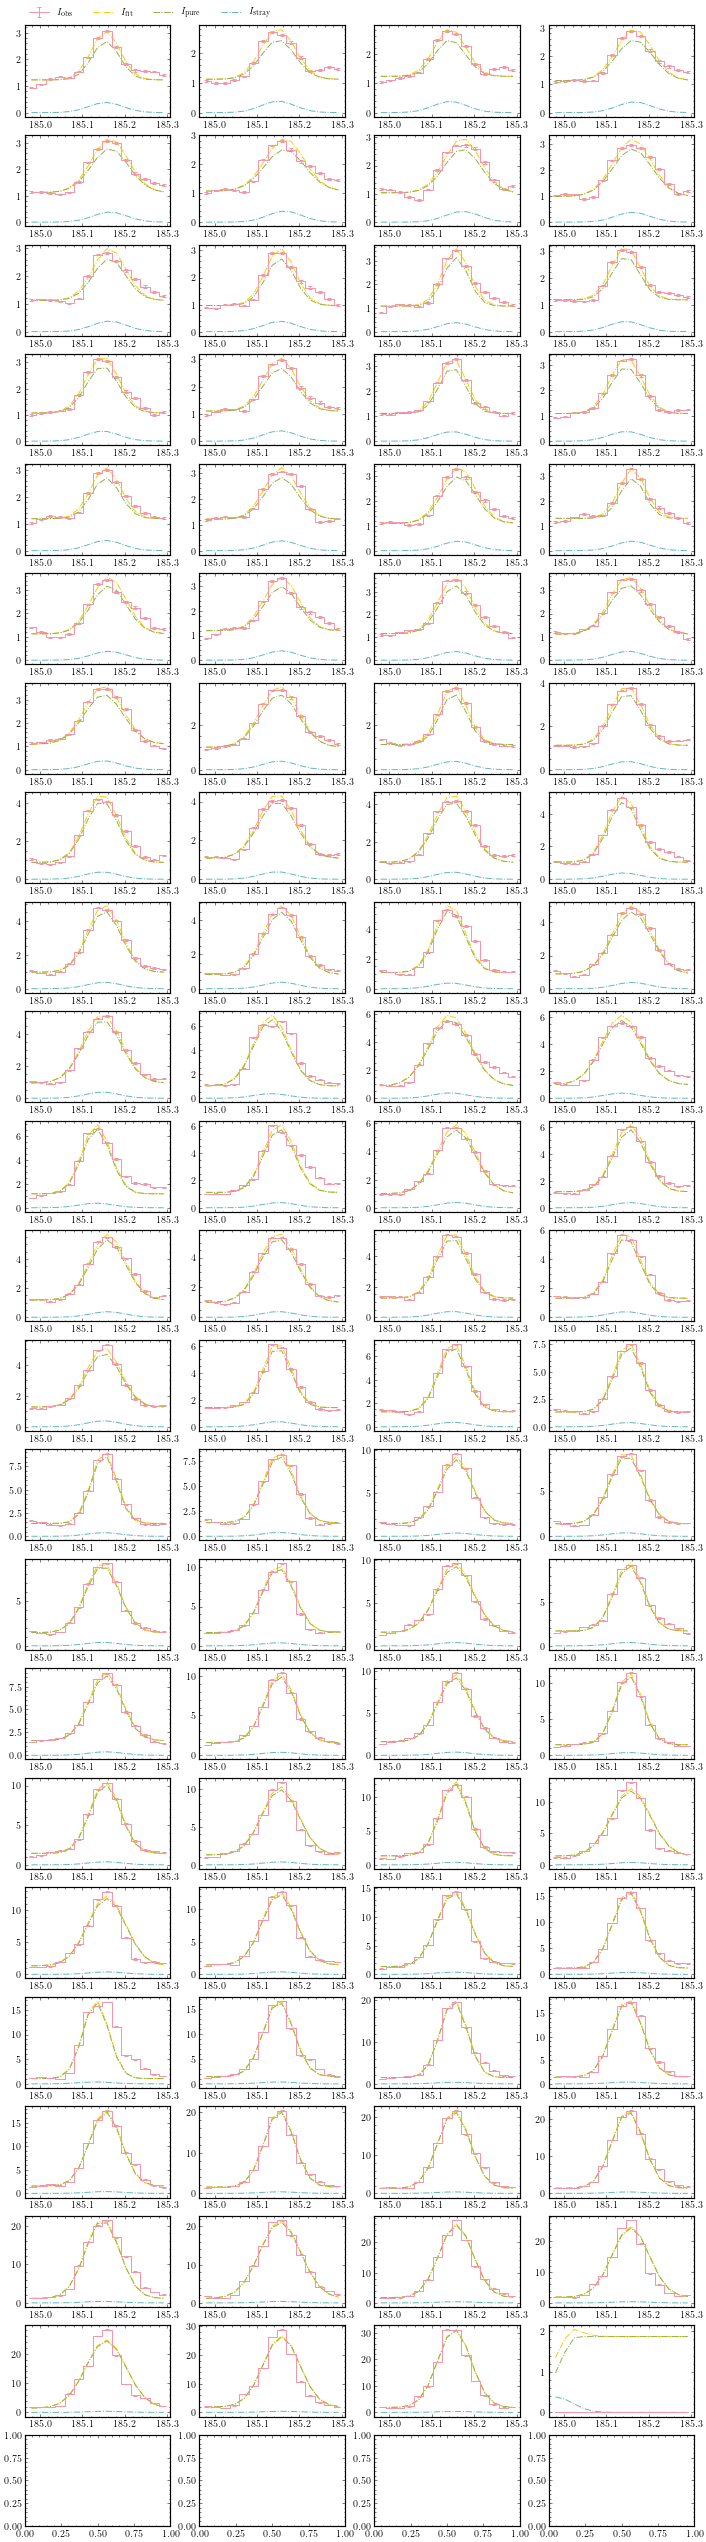

In [249]:
FeVIII_185_1.plot()

/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


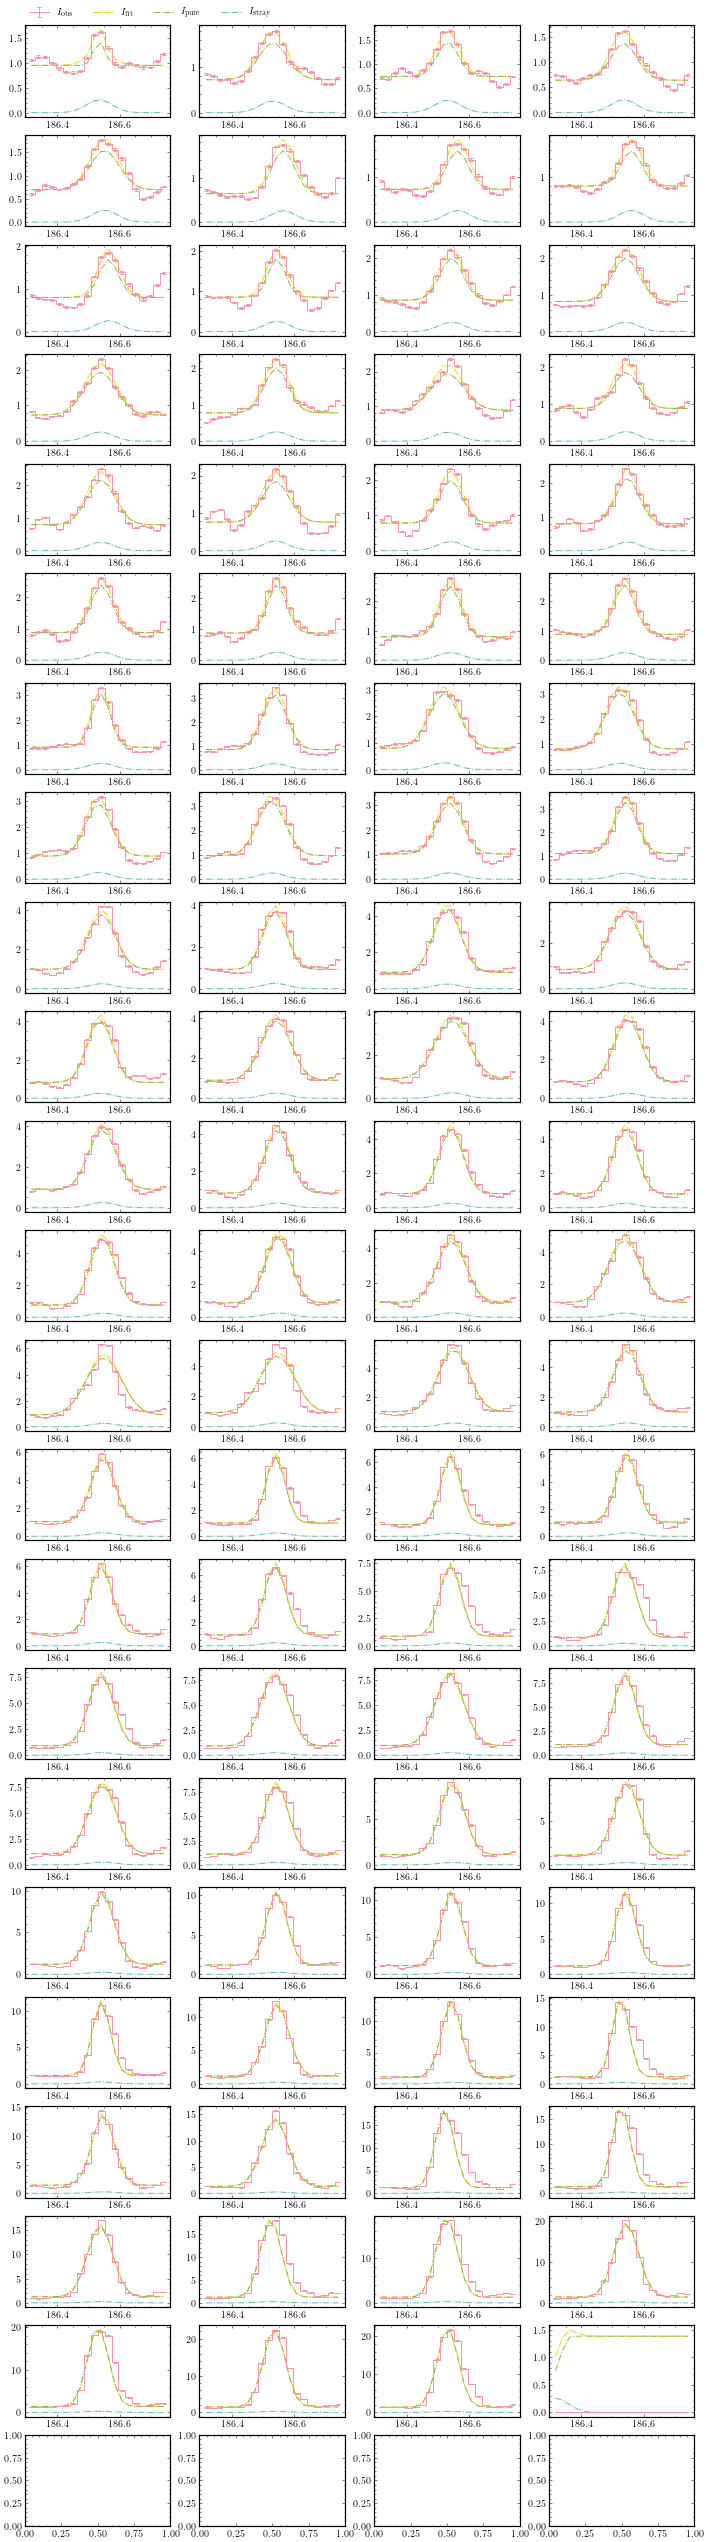

In [250]:
FeVIII_186_1.plot()

In [247]:
int_185_1 = np.flip(FeVIII_185_1.get_para()[:,0])
int_185_2 = np.flip(FeVIII_185_2.get_para()[:,0])
int_185_4 = np.flip(FeVIII_185_4.get_para()[:,0])
int_185_8 = np.flip(FeVIII_185_8.get_para()[:,0])
int_185_single = np.flip(FeVIII_185_single.get_para()[:,0])
bg_185_1 = FeVIII_185_1.get_para()[:,3]
int_185_integral = np.flip(simps(x = wvl_185, y = data_185_erg[-88:,:] - bg_185_1[:,np.newaxis],axis=1))

int_186_fe8_1 = np.flip(FeVIII_186_1.get_para()[:,0])
int_186_fe8_2 = np.flip(FeVIII_186_2.get_para()[:,0])
int_186_fe8_4 = np.flip(FeVIII_186_4.get_para()[:,0])
int_186_fe8_8 = np.flip(FeVIII_186_8.get_para()[:,0])
int_186_fe8_single = np.flip(FeVIII_186_single.get_para()[:,0])
bg_186_fe8_1 = FeVIII_186_1.get_para()[:,3]
int_186_fe8_integral = np.flip(simps(x = wvl_186_fe8, y = data_186_fe8_erg[-88:,:] - bg_186_fe8_1[:,np.newaxis],axis=1))

x_start = (3 + 8 - (19+255) + 1242)/data_set["rsun"]
x_end = (514 - 8 - (19+255) + 1242)/data_set["rsun"]
x_start_1 = (3 + 0 - (19+255) + 1242)/data_set["rsun"]
x_end_1 = (514 - 0 - (19+255) + 1242)/data_set["rsun"]
x_start_2 = (3 + 1 - (19+255) + 1242)/data_set["rsun"]
x_end_2 = (514 - 1 - (19+255) + 1242)/data_set["rsun"]
x_start_4 = (3 + 2 - (19+255) + 1242)/data_set["rsun"]
x_end_4 = (514 - 2 - (19+255) + 1242)/data_set["rsun"]
x_start_8 = (3 + 4 - (19+255) + 1242)/data_set["rsun"]
x_end_8 = (514 - 4 - (19+255) + 1242)/data_set["rsun"]
r_coord = np.linspace(x_start,x_end,32)
r_coord_1 = np.linspace(x_start,x_end,512)
r_coord_2 = np.linspace(x_start,x_end,256)
r_coord_4 = np.linspace(x_start,x_end,128)
r_coord_8 = np.linspace(x_start,x_end,64)

ratio_186_185_1 = int_186_fe8_1/int_185_1
ratio_186_185_2 = int_186_fe8_2/int_185_2
ratio_186_185_4 = int_186_fe8_4/int_185_4
ratio_186_185_8 = int_186_fe8_8/int_185_8
ratio_186_185_integral = int_186_fe8_integral/int_185_integral
ratio_186_185_single = int_186_fe8_single/int_185_single

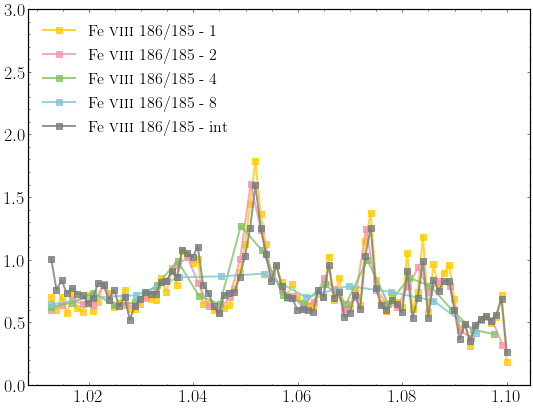

In [253]:
fig, ax = plt.subplots(figsize=(8,6))
ln1, = ax.plot(r_coord_1[:88],ratio_186_185_1,color = '#FFCB05',linewidth=2,label = r'Fe \textsc{viii} 186/185 - 1',marker='s',alpha=0.8)
ln2, = ax.plot(r_coord_2[:44],ratio_186_185_2,color = '#F596AA',linewidth=2,label = r'Fe \textsc{viii} 186/185 - 2',marker='s',alpha=0.8)
ln3, = ax.plot(r_coord_4[:22],ratio_186_185_4,color = '#86C166',linewidth=2,label = r'Fe \textsc{viii} 186/185 - 4',marker='s',alpha=0.8)
ln4, = ax.plot(r_coord_8[:11],ratio_186_185_8,color = '#81C7D4',linewidth=2,label = r'Fe \textsc{viii} 186/185 - 8',marker='s',alpha=0.8)
ln5, = ax.plot(r_coord_1[:88],ratio_186_185_integral,color = '#787D7B',linewidth=2,label = r'Fe \textsc{viii} 186/185 - int',marker='s',alpha=0.8)
#ln5, = ax.plot(r_coord_1[:88],ratio_186_185_single,color = '#787D7B',linewidth=2,label = r'Fe \textsc{viii} 186/185 - single',marker='s',alpha=0.8)
leg = [ln1,ln2,ln3,ln4,ln5]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 16)
ax.set_ylim(0,3)
ax.set_xlabel(r'',fontsize=24)
ax.set_ylabel(r'',fontsize=24)
ax.tick_params(labelsize=18)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

In [254]:
ratio_data = pd.read_fwf('../ratios/den_186_185_ph.txt',skiprows=6,names=['ne','ratio'],widths=[10,10],encoding='utf-8',index_col=False,skipfooter=3)
from scipy import interpolate
f_186_185 = interpolate.interp1d(ratio_data['ratio'].values,ratio_data['ne'].values,fill_value="extrapolate")
f_186_185(ratio_186_185_8)

/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


array([       inf, 8.60141208, 8.31323311, 7.57759256, 7.55706654,
       7.50350152, 8.5589667 , 7.8103625 , 8.07639301,        inf,
              inf])

In [270]:
def ne_func(x, a, b):
    return a * x + b

den_inf_186_185 = np.nan_to_num(f_186_185(ratio_186_185_integral),neginf=0.,posinf=0.,nan=0)
err_186_185 = np.ones_like(den_inf_186_185)*0.1
err_186_185[np.where(den_inf_186_185 == 0)]  = 1e10    
err_186_185[np.where(den_inf_186_185 > 8.5)]  = 1e10 
err_186_185[np.where(den_inf_186_185 < 7)]  = 1e10 
#err_186_185[50:][np.where(den_inf_186_185[50:] > 8)]  = 1e10
popt, pcov = curve_fit(ne_func, r_coord_1[:88],den_inf_186_185[:88],sigma=err_186_185[:88],bounds=np.array([[-100,0],[0,1000]]).T)
perr = np.sqrt(np.diag(pcov))

In [271]:
perr

array([1.84003881, 1.92620391])

/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


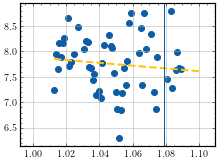

In [274]:
plt.scatter(r_coord_1[:88],f_186_185(ratio_186_185_integral))
plt.plot(r_coord_1[:88], ne_func(r_coord_1[:88],popt[0],popt[1]),color = '#FFC408',linewidth=2,label = '',ls='--')
plt.axvline(r_coord_1[66])
plt.grid('on')

In [272]:
popt

array([-2.75369516, 10.64017725])

In [59]:
FeXII_186_1 = FeXII_fit(data_186_fe12_erg[-88:,:],wvl_186_fe12,[2,186.15,0.04,0.5],
                        err = data_186_fe12_erg_err[-88:,:],stray_int = g_186_fe12_stray.intensity.value, stray_fwhm= g_186_fe12_stray.fwhm.value)
FeXII_186_2 = FeXII_fit(data_186_fe12_erg_2[-44:,:],wvl_186_fe12,[2,186.15,0.04,0.5],
                        err = data_186_fe12_erg_2_err[-44:,:],stray_int = g_186_fe12_stray.intensity.value, stray_fwhm= g_186_fe12_stray.fwhm.value)
FeXII_186_4 = FeXII_fit(data_186_fe12_erg_4[-22:,:],wvl_186_fe12,[2,186.15,0.04,0.5],
                        err = data_186_fe12_erg_4_err[-22:,:],stray_int = g_186_fe12_stray.intensity.value, stray_fwhm= g_186_fe12_stray.fwhm.value)
FeXII_186_8 = FeXII_fit(data_186_fe12_erg_8[-11:,:],wvl_186_fe12,[2,186.15,0.04,0.5],
                        err = data_186_fe12_erg_8_err[-11:,:],stray_int = g_186_fe12_stray.intensity.value, stray_fwhm= g_186_fe12_stray.fwhm.value)
FeXII_186_1.run_lse()
FeXII_186_2.run_lse()
FeXII_186_4.run_lse()
FeXII_186_8.run_lse()

FeXII_195_1_lc = FeXII_fit(data_195_erg_1[-88:,:],wvl_195,[2,195.15,0.04,0.5],
                        err = data_195_erg_1_err[-88:,:],stray_int = g_195_stray.intensity.value, stray_fwhm= g_195_stray.fwhm.value)
FeXII_195_2_lc = FeXII_fit(data_195_erg_2[-44:,:],wvl_195,[2,195.15,0.04,0.5],
                        err = data_195_erg_2_err[-44:,:],stray_int = g_195_stray.intensity.value, stray_fwhm= g_195_stray.fwhm.value)
FeXII_195_4_lc = FeXII_fit(data_195_erg_4[-22:,:],wvl_195,[2,195.15,0.04,0.5],
                        err = data_195_erg_4_err[-22:,:],stray_int = g_195_stray.intensity.value, stray_fwhm= g_195_stray.fwhm.value)
FeXII_195_8_lc = FeXII_fit(data_195_erg_8[-11:,:],wvl_195,[2,195.15,0.04,0.5],
                        err = data_195_erg_8_err[-11:,:],stray_int = g_195_stray.intensity.value, stray_fwhm= g_195_stray.fwhm.value)
FeXII_195_1_lc.run_lse()
FeXII_195_2_lc.run_lse()
FeXII_195_4_lc.run_lse()
FeXII_195_8_lc.run_lse()

87 fit again
0 fit again


9 fit again
11 fit again


23 fit again
29 fit again
31 fit again


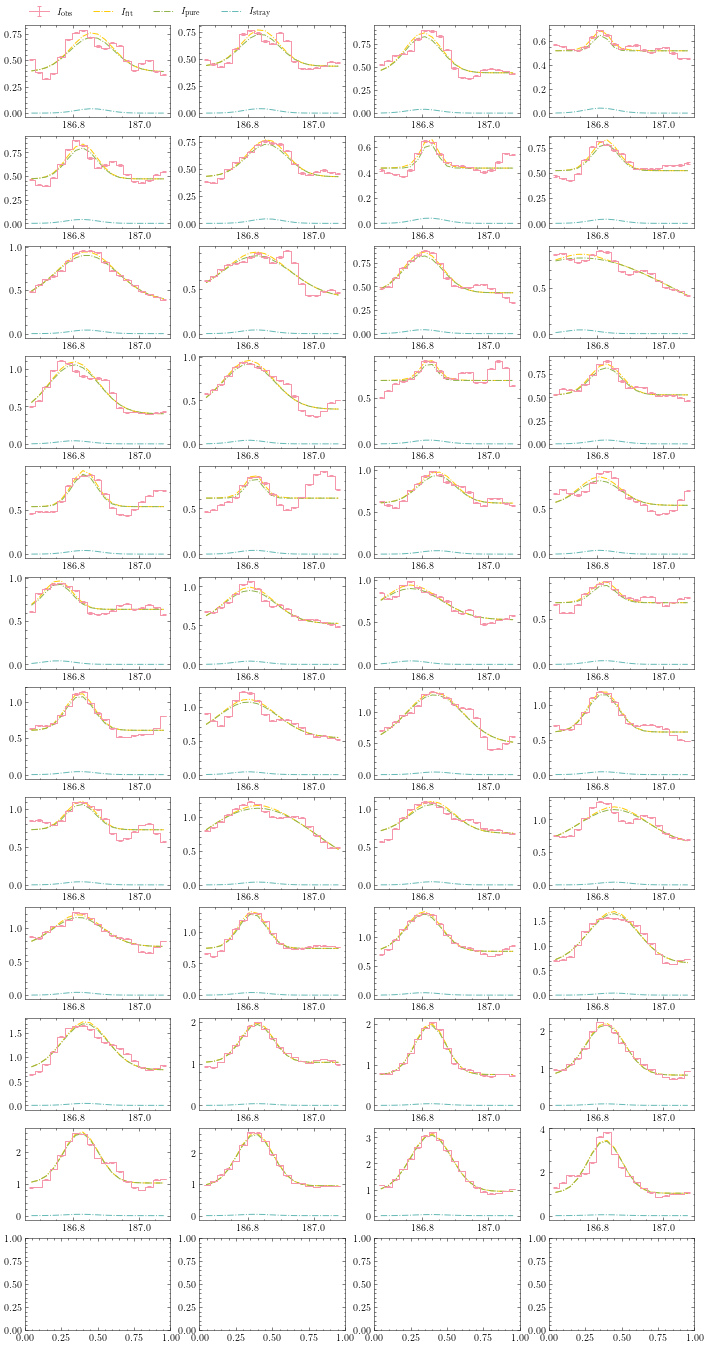

In [128]:
FeXII_186_8 = FeXII_fit(data_186_fe12_erg_8[-44:,:],wvl_186_fe12,[2,186.15,0.04,0.5],
                        err = data_186_fe12_erg_8_err[-44:,:],stray_int = g_186_fe12_stray.intensity.value, stray_fwhm= g_186_fe12_stray.fwhm.value)
FeXII_186_8.run_lse()
FeXII_186_8.plot()

In [60]:
int_195_1_lc = np.flip(FeXII_195_1_lc.get_para()[:,0])
int_195_2_lc = np.flip(FeXII_195_2_lc.get_para()[:,0])
int_195_4_lc = np.flip(FeXII_195_4_lc.get_para()[:,0])
int_195_8_lc = np.flip(FeXII_195_8_lc.get_para()[:,0])

int_186_fe12_1 = np.flip(FeXII_186_1.get_para()[:,0])
int_186_fe12_2 = np.flip(FeXII_186_2.get_para()[:,0])
int_186_fe12_4 = np.flip(FeXII_186_4.get_para()[:,0])
int_186_fe12_8 = np.flip(FeXII_186_8.get_para()[:,0])

ratio_195_186_1 = int_195_1_lc/int_186_fe12_1
ratio_195_186_2 = int_195_2_lc/int_186_fe12_2
ratio_195_186_4 = int_195_4_lc/int_186_fe12_4
ratio_195_186_8 = int_195_8_lc/int_186_fe12_8

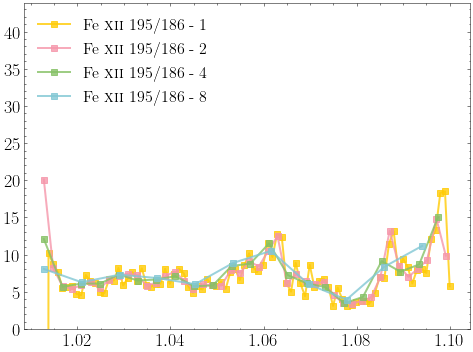

In [61]:
fig, ax = plt.subplots(figsize=(8,6))
ln1, = ax.plot(r_coord_1[:88],ratio_195_186_1,color = '#FFCB05',linewidth=2,label = r'Fe \textsc{xii} 195/186 - 1',marker='s',alpha=0.8)
ln2, = ax.plot(r_coord_2[:44],ratio_195_186_2,color = '#F596AA',linewidth=2,label = r'Fe \textsc{xii} 195/186 - 2',marker='s',alpha=0.8)
ln3, = ax.plot(r_coord_4[:22],ratio_195_186_4,color = '#86C166',linewidth=2,label = r'Fe \textsc{xii} 195/186 - 4',marker='s',alpha=0.8)
ln4, = ax.plot(r_coord_8[:11],ratio_195_186_8,color = '#81C7D4',linewidth=2,label = r'Fe \textsc{xii} 195/186 - 8',marker='s',alpha=0.8)
leg = [ln1,ln2,ln3,ln4]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 16)
ax.set_xlabel(r'',fontsize=24)
ax.set_ylabel(r'',fontsize=24)
ax.set_ylim(bottom=0.0)
ax.tick_params(labelsize=18)

In [62]:
ratio_data = pd.read_fwf('../ratios/fe12_den_195_186_6.2.txt',skiprows=6,names=['ne','ratio'],widths=[10,10],encoding='utf-8',index_col=False,skipfooter=3)
from scipy import interpolate
f_195_186 = interpolate.interp1d(ratio_data['ratio'].values,ratio_data['ne'].values,fill_value="extrapolate")
def ne_func(x, a, b):
    return a * x + b
den_inf_195_186 = np.nan_to_num(f_195_186(ratio_195_186_1),neginf=0.,posinf=0.,nan=0)
popt_FeXII, pcov_FeXII = curve_fit(ne_func, r_coord_1[1:50],den_inf_195_186[1:50])
perr_FeXII = np.sqrt(np.diag(pcov_FeXII))

In [233]:
popt_FeXII

array([-4.05729177, 12.61378966])

In [234]:
perr_FeXII

array([1.62070898, 1.6822101 ])

In [235]:
popt

array([-5.64227788, 13.58876778])

/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


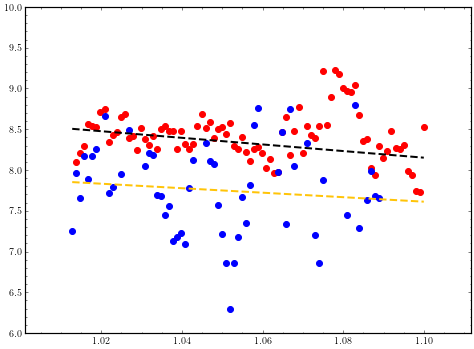

In [293]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(r_coord_1[:88],f_195_186(ratio_195_186_1),color="red")
ax.scatter(r_coord_1[:88],f_186_185(ratio_186_185_integral),color="blue")
ax.set_ylim(6,10)
ax.plot(r_coord_1[:88], ne_func(r_coord_1[:88],popt[0],popt[1]),color = '#FFC408',linewidth=2,label = '',ls='--')
ax.plot(r_coord_1[:88], ne_func(r_coord_1[:88],popt_FeXII[0],popt_FeXII[1]),color = 'black',linewidth=2,label = '',ls='--')

In [67]:
%store data_195_erg
%store wvl_195
%store data_195_erg_err

Stored 'data_195_erg' (MaskedArray)
Stored 'wvl_195' (ndarray)
Stored 'data_195_erg_err' (MaskedArray)


In [68]:
FeXII_192_2 = FeXII_fit(data_192_erg_2,wvl_192,[1,192.37,0.04,0.],err=data_192_erg_2_err,
                       stray_int = g_192_stray.intensity.value, stray_fwhm= g_192_stray.fwhm.value,stray_wvl=g_192_stray.mean.value)
FeXII_192_4 = FeXII_fit(data_192_erg_4,wvl_192,[1,192.37,0.04,0.],err=data_192_erg_4_err,
                       stray_int = g_192_stray.intensity.value, stray_fwhm= g_192_stray.fwhm.value,stray_wvl=g_192_stray.mean.value)
FeXII_192_8 = FeXII_fit(data_192_erg_8,wvl_192,[1,192.37,0.04,0.],err=data_192_erg_8_err,
                       stray_int = g_192_stray.intensity.value, stray_fwhm= g_192_stray.fwhm.value,stray_wvl=g_192_stray.mean.value)
FeXII_192_32 = FeXII_fit(data_192_erg_32,wvl_192,[1,192.37,0.04,0.],err=data_192_erg_32_err,
                       stray_int = g_192_stray.intensity.value, stray_fwhm= g_192_stray.fwhm.value,stray_wvl=g_192_stray.mean.value)
FeXII_192_2.run_lse()
FeXII_192_4.run_lse()
FeXII_192_8.run_lse()
FeXII_192_32.run_lse()

FeXII_193_2 = FeXII_fit(data_193_erg_2,wvl_193,[1,193.37,0.04,0.],err=data_193_erg_2_err,
                       stray_int = g_193_stray.intensity.value, stray_fwhm= g_193_stray.fwhm.value,stray_wvl=g_193_stray.mean.value)
FeXII_193_4 = FeXII_fit(data_193_erg_4,wvl_193,[1,193.37,0.04,0.],err=data_193_erg_4_err,
                       stray_int = g_193_stray.intensity.value, stray_fwhm= g_193_stray.fwhm.value,stray_wvl=g_193_stray.mean.value)
FeXII_193_8 = FeXII_fit(data_193_erg_8,wvl_193,[1,193.37,0.04,0.],err=data_193_erg_8_err,
                       stray_int = g_193_stray.intensity.value, stray_fwhm= g_193_stray.fwhm.value,stray_wvl=g_193_stray.mean.value)
FeXII_193_32 = FeXII_fit(data_193_erg_32,wvl_193,[1,193.37,0.04,0.],err=data_193_erg_32_err,
                       stray_int = g_193_stray.intensity.value, stray_fwhm= g_193_stray.fwhm.value,stray_wvl=g_193_stray.mean.value)
FeXII_193_2.run_lse()
FeXII_193_4.run_lse()
FeXII_193_8.run_lse()
FeXII_193_32.run_lse()

FeXII_195_2 = FeXII_fit(data_195_erg_2,wvl_195,[1,195.37,0.04,0.],err=data_195_erg_2_err,
                       stray_int = g_195_stray.intensity.value, stray_fwhm= g_195_stray.fwhm.value,stray_wvl=g_195_stray.mean.value)
FeXII_195_4 = FeXII_fit(data_195_erg_4,wvl_195,[1,195.37,0.04,0.],err=data_195_erg_4_err,
                       stray_int = g_195_stray.intensity.value, stray_fwhm= g_195_stray.fwhm.value,stray_wvl=g_195_stray.mean.value)
FeXII_195_8 = FeXII_fit(data_195_erg_8,wvl_195,[1,195.37,0.04,0.],err=data_195_erg_8_err,
                       stray_int = g_195_stray.intensity.value, stray_fwhm= g_195_stray.fwhm.value,stray_wvl=g_195_stray.mean.value)
FeXII_195_32 = FeXII_fit(data_195_erg_32,wvl_195,[1,195.37,0.04,0.],err=data_195_erg_32_err,
                       stray_int = g_195_stray.intensity.value, stray_fwhm= g_195_stray.fwhm.value,stray_wvl=g_195_stray.mean.value)
FeXII_195_2.run_lse()
FeXII_195_4.run_lse()
FeXII_195_8.run_lse()
FeXII_195_32.run_lse()

FeXIII_202_2 = FeXII_fit(data_202_erg_2,wvl_202,[1,202.37,0.04,0.],err=data_202_erg_2_err,
                       stray_int = g_202_stray.intensity.value, stray_fwhm= g_202_stray.fwhm.value,stray_wvl=g_202_stray.mean.value)
FeXIII_202_4 = FeXII_fit(data_202_erg_4,wvl_202,[1,202.37,0.04,0.],err=data_202_erg_4_err,
                       stray_int = g_202_stray.intensity.value, stray_fwhm= g_202_stray.fwhm.value,stray_wvl=g_202_stray.mean.value)
FeXIII_202_8 = FeXII_fit(data_202_erg_8,wvl_202,[1,202.37,0.04,0.],err=data_202_erg_8_err,
                       stray_int = g_202_stray.intensity.value, stray_fwhm= g_202_stray.fwhm.value,stray_wvl=g_202_stray.mean.value)
FeXIII_202_32 = FeXII_fit(data_202_erg_32,wvl_202,[1,202.37,0.04,0.],err=data_202_erg_32_err,
                       stray_int = g_202_stray.intensity.value, stray_fwhm= g_202_stray.fwhm.value,stray_wvl=g_202_stray.mean.value)
FeXIII_202_2.run_lse()
FeXIII_202_4.run_lse()
FeXIII_202_8.run_lse()
FeXIII_202_32.run_lse()

23 fit again
24 fit again
26 fit again
13 fit again


In [2]:
slit_width_file = scipy.io.readsav('../save/slit_width.save',verbose = False,python_dict=True)
slit_width = slit_width_file['slit_width_16']
slit_width_2 = slit_width_file['slit_width_2']
slit_width_4 = slit_width_file['slit_width_4']
slit_width_8 = slit_width_file['slit_width_8']
slit_width_32 = np.mean(slit_width.reshape(2,16),axis=0)

In [5]:
np.mean(slit_width_4[110:118])

0.06542393565177917

In [70]:
fwhm_192 = FeXII_192.get_para()[:,2]
fwhm_192_cor = np.flip(np.sqrt(np.power(fwhm_192,2) - np.power(slit_width,2)))
fwhm_192_err = np.flip(fwhm_192)/fwhm_192_cor*np.flip(FeXII_192.get_error()[:,2])

fwhm_192_bs = FeXII_192_bs.get_para()[:,2]
fwhm_192_cor_bs = np.flip(np.sqrt(np.power(fwhm_192_bs,2) - np.power(slit_width,2)))
fwhm_192_err_bs = np.flip(fwhm_192_bs)/fwhm_192_cor_bs*np.flip(FeXII_192_bs.get_error()[:,2])

fwhm_192_bbs = FeXII_192_bbs.get_para()[:,2]
fwhm_192_cor_bbs = np.flip(np.sqrt(np.power(fwhm_192_bbs,2) - np.power(slit_width,2)))
fwhm_192_err_bbs = np.flip(fwhm_192_bbs)/fwhm_192_cor_bbs*np.flip(FeXII_192_bbs.get_error()[:,2])

fwhm_192_2 = FeXII_192_2.get_para()[:,2]
fwhm_192_cor_2 = np.flip(np.sqrt(np.power(fwhm_192_2,2) - np.power(slit_width_2,2)))
fwhm_192_err_2 = np.flip(fwhm_192_2)/fwhm_192_cor_2*np.flip(FeXII_192_2.get_error()[:,2])

fwhm_192_4 = FeXII_192_4.get_para()[:,2]
fwhm_192_cor_4 = np.flip(np.sqrt(np.power(fwhm_192_4,2) - np.power(slit_width_4,2)))
fwhm_192_err_4 = np.flip(fwhm_192_4)/fwhm_192_cor_4*np.flip(FeXII_192_4.get_error()[:,2])

fwhm_192_8 = FeXII_192_8.get_para()[:,2]
fwhm_192_cor_8 = np.flip(np.sqrt(np.power(fwhm_192_8,2) - np.power(slit_width_8,2)))
fwhm_192_err_8 = np.flip(fwhm_192_8)/fwhm_192_cor_8*np.flip(FeXII_192_8.get_error()[:,2])

fwhm_192_32 = FeXII_192_32.get_para()[:,2]
fwhm_192_cor_32 = np.flip(np.sqrt(np.power(fwhm_192_32,2) - np.power(slit_width_32,2)))
fwhm_192_err_32 = np.flip(fwhm_192_32)/fwhm_192_cor_32*np.flip(FeXII_192_32.get_error()[:,2])


fwhm_193 = FeXII_193.get_para()[:,2]
fwhm_193_cor = np.flip(np.sqrt(np.power(fwhm_193,2) - np.power(slit_width,2)))
fwhm_193_err = np.flip(fwhm_193)/fwhm_193_cor*np.flip(FeXII_193.get_error()[:,2])

fwhm_193_bs = FeXII_193_bs.get_para()[:,2]
fwhm_193_cor_bs = np.flip(np.sqrt(np.power(fwhm_193_bs,2) - np.power(slit_width,2)))
fwhm_193_err_bs = np.flip(fwhm_193_bs)/fwhm_193_cor_bs*np.flip(FeXII_193_bs.get_error()[:,2])

fwhm_193_bbs = FeXII_193_bbs.get_para()[:,2]
fwhm_193_cor_bbs = np.flip(np.sqrt(np.power(fwhm_193_bbs,2) - np.power(slit_width,2)))
fwhm_193_err_bbs = np.flip(fwhm_193_bbs)/fwhm_193_cor_bbs*np.flip(FeXII_193_bbs.get_error()[:,2])

fwhm_193_2 = FeXII_193_2.get_para()[:,2]
fwhm_193_cor_2 = np.flip(np.sqrt(np.power(fwhm_193_2,2) - np.power(slit_width_2,2)))
fwhm_193_err_2 = np.flip(fwhm_193_2)/fwhm_193_cor_2*np.flip(FeXII_193_2.get_error()[:,2])

fwhm_193_4 = FeXII_193_4.get_para()[:,2]
fwhm_193_cor_4 = np.flip(np.sqrt(np.power(fwhm_193_4,2) - np.power(slit_width_4,2)))
fwhm_193_err_4 = np.flip(fwhm_193_4)/fwhm_193_cor_4*np.flip(FeXII_193_4.get_error()[:,2])

fwhm_193_8 = FeXII_193_8.get_para()[:,2]
fwhm_193_cor_8 = np.flip(np.sqrt(np.power(fwhm_193_8,2) - np.power(slit_width_8,2)))
fwhm_193_err_8 = np.flip(fwhm_193_8)/fwhm_193_cor_8*np.flip(FeXII_193_8.get_error()[:,2])

fwhm_193_32 = FeXII_193_32.get_para()[:,2]
fwhm_193_cor_32 = np.flip(np.sqrt(np.power(fwhm_193_32,2) - np.power(slit_width_32,2)))
fwhm_193_err_32 = np.flip(fwhm_193_32)/fwhm_193_cor_32*np.flip(FeXII_193_32.get_error()[:,2])

fwhm_195 = FeXII_195.get_para()[:,2]
fwhm_195_cor = np.flip(np.sqrt(np.power(fwhm_195,2) - np.power(slit_width,2)))
fwhm_195_err = np.flip(fwhm_195)/fwhm_195_cor*np.flip(FeXII_195.get_error()[:,2])

fwhm_195_bs = FeXII_195_bs.get_para()[:,2]
fwhm_195_cor_bs = np.flip(np.sqrt(np.power(fwhm_195_bs,2) - np.power(slit_width,2)))
fwhm_195_err_bs = np.flip(fwhm_195_bs)/fwhm_195_cor_bs*np.flip(FeXII_195_bs.get_error()[:,2])

fwhm_195_bbs = FeXII_195_bbs.get_para()[:,2]
fwhm_195_cor_bbs = np.flip(np.sqrt(np.power(fwhm_195_bbs,2) - np.power(slit_width,2)))
fwhm_195_err_bbs = np.flip(fwhm_195_bbs)/fwhm_195_cor_bbs*np.flip(FeXII_195_bbs.get_error()[:,2])

fwhm_195_2 = FeXII_195_2.get_para()[:,2]
fwhm_195_cor_2 = np.flip(np.sqrt(np.power(fwhm_195_2,2) - np.power(slit_width_2,2)))
fwhm_195_err_2 = np.flip(fwhm_195_2)/fwhm_195_cor_2*np.flip(FeXII_195_2.get_error()[:,2])

fwhm_195_4 = FeXII_195_4.get_para()[:,2]
fwhm_195_cor_4 = np.flip(np.sqrt(np.power(fwhm_195_4,2) - np.power(slit_width_4,2)))
fwhm_195_err_4 = np.flip(fwhm_195_4)/fwhm_195_cor_4*np.flip(FeXII_195_4.get_error()[:,2])

fwhm_195_8 = FeXII_195_8.get_para()[:,2]
fwhm_195_cor_8 = np.flip(np.sqrt(np.power(fwhm_195_8,2) - np.power(slit_width_8,2)))
fwhm_195_err_8 = np.flip(fwhm_195_8)/fwhm_195_cor_8*np.flip(FeXII_195_8.get_error()[:,2])

fwhm_195_32 = FeXII_195_32.get_para()[:,2]
fwhm_195_cor_32 = np.flip(np.sqrt(np.power(fwhm_195_32,2) - np.power(slit_width_32,2)))
fwhm_195_err_32 = np.flip(fwhm_195_32)/fwhm_195_cor_32*np.flip(FeXII_195_32.get_error()[:,2])

fwhm_202 = FeXIII_202.get_para()[:,2]
fwhm_202_cor = np.flip(np.sqrt(np.power(fwhm_202,2) - np.power(slit_width,2)))
fwhm_202_err = np.flip(fwhm_202)/fwhm_202_cor*np.flip(FeXIII_202.get_error()[:,2])

fwhm_202_bs = FeXIII_202_bs.get_para()[:,2]
fwhm_202_cor_bs = np.flip(np.sqrt(np.power(fwhm_202_bs,2) - np.power(slit_width,2)))
fwhm_202_err_bs = np.flip(fwhm_202_bs)/fwhm_202_cor_bs*np.flip(FeXIII_202_bs.get_error()[:,2])

fwhm_202_bbs = FeXIII_202_bbs.get_para()[:,2]
fwhm_202_cor_bbs = np.flip(np.sqrt(np.power(fwhm_202_bbs,2) - np.power(slit_width,2)))
fwhm_202_err_bbs = np.flip(fwhm_202_bbs)/fwhm_202_cor_bbs*np.flip(FeXIII_202_bbs.get_error()[:,2])

fwhm_202_2 = FeXIII_202_2.get_para()[:,2]
fwhm_202_cor_2 = np.flip(np.sqrt(np.power(fwhm_202_2,2) - np.power(slit_width_2,2)))
fwhm_202_err_2 = np.flip(fwhm_202_2)/fwhm_202_cor_2*np.flip(FeXIII_202_2.get_error()[:,2])

fwhm_202_4 = FeXIII_202_4.get_para()[:,2]
fwhm_202_cor_4 = np.flip(np.sqrt(np.power(fwhm_202_4,2) - np.power(slit_width_4,2)))
fwhm_202_err_4 = np.flip(fwhm_202_4)/fwhm_202_cor_4*np.flip(FeXIII_202_4.get_error()[:,2])

fwhm_202_8 = FeXIII_202_8.get_para()[:,2]
fwhm_202_cor_8 = np.flip(np.sqrt(np.power(fwhm_202_8,2) - np.power(slit_width_8,2)))
fwhm_202_err_8 = np.flip(fwhm_202_8)/fwhm_202_cor_8*np.flip(FeXIII_202_8.get_error()[:,2])

fwhm_202_32 = FeXIII_202_32.get_para()[:,2]
fwhm_202_cor_32 = np.flip(np.sqrt(np.power(fwhm_202_32,2) - np.power(slit_width_32,2)))
fwhm_202_err_32 = np.flip(fwhm_202_32)/fwhm_202_cor_32*np.flip(FeXIII_202_32.get_error()[:,2])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in sqrt


In [71]:
fwhm_192_mcmc = FeXII_192.get_para(mcmc=True)[:,2]
fwhm_192_cor_mcmc = np.flip(np.sqrt(np.power(fwhm_192_mcmc,2) - np.power(slit_width,2)))
#fwhm_192_err_up_mcmc = np.flip(fwhm_192_mcmc)/fwhm_192_cor_mcmc*np.flip(FeXII_192.get_error(mcmc=True)[:,1,2])
#fwhm_192_err_down_mcmc = np.flip(fwhm_192_mcmc)/fwhm_192_cor_mcmc*np.flip(FeXII_192.get_error(mcmc=True)[:,0,2])
fwhm_192_err_up_mcmc = np.flip(FeXII_192.get_error(mcmc=True)[:,1,2])
fwhm_192_err_down_mcmc = np.flip(FeXII_192.get_error(mcmc=True)[:,0,2])

fwhm_192_bs_mcmc = FeXII_192_bs.get_para(mcmc=True)[:,2]
fwhm_192_cor_bs_mcmc = np.flip(np.sqrt(np.power(fwhm_192_bs_mcmc,2) - np.power(slit_width,2)))
fwhm_192_err_bs_up_mcmc = np.flip(fwhm_192_bs_mcmc)/fwhm_192_cor_bs_mcmc*np.flip(FeXII_192_bs.get_error(mcmc=True)[:,1,2])
fwhm_192_err_bs_down_mcmc = np.flip(fwhm_192_bs_mcmc)/fwhm_192_cor_bs_mcmc*np.flip(FeXII_192_bs.get_error(mcmc=True)[:,0,2])

fwhm_192_bbs_mcmc = FeXII_192_bbs.get_para(mcmc=True)[:,2]
fwhm_192_cor_bbs_mcmc = np.flip(np.sqrt(np.power(fwhm_192_bbs_mcmc,2) - np.power(slit_width,2)))
fwhm_192_err_bbs_up_mcmc = np.flip(fwhm_192_bbs_mcmc)/fwhm_192_cor_bbs_mcmc*np.flip(FeXII_192_bbs.get_error(mcmc=True)[:,1,2])
fwhm_192_err_bbs_down_mcmc = np.flip(fwhm_192_bbs_mcmc)/fwhm_192_cor_bbs_mcmc*np.flip(FeXII_192_bbs.get_error(mcmc=True)[:,1,2])

fwhm_193_mcmc = FeXII_193.get_para(mcmc=True)[:,2]
fwhm_193_cor_mcmc = np.flip(np.sqrt(np.power(fwhm_193_mcmc,2) - np.power(slit_width,2)))
fwhm_193_err_up_mcmc = np.flip(fwhm_193_mcmc)/fwhm_193_cor_mcmc*np.flip(FeXII_193.get_error(mcmc=True)[:,1,2])
fwhm_193_err_down_mcmc = np.flip(fwhm_193_mcmc)/fwhm_193_cor_mcmc*np.flip(FeXII_193.get_error(mcmc=True)[:,0,2])

fwhm_193_bs_mcmc = FeXII_193_bs.get_para(mcmc=True)[:,2]
fwhm_193_cor_bs_mcmc = np.flip(np.sqrt(np.power(fwhm_193_bs_mcmc,2) - np.power(slit_width,2)))
fwhm_193_err_bs_up_mcmc = np.flip(fwhm_193_bs_mcmc)/fwhm_193_cor_bs_mcmc*np.flip(FeXII_193_bs.get_error(mcmc=True)[:,1,2])
fwhm_193_err_bs_down_mcmc = np.flip(fwhm_193_bs_mcmc)/fwhm_193_cor_bs_mcmc*np.flip(FeXII_193_bs.get_error(mcmc=True)[:,0,2])

fwhm_193_bbs_mcmc = FeXII_193_bbs.get_para(mcmc=True)[:,2]
fwhm_193_cor_bbs_mcmc = np.flip(np.sqrt(np.power(fwhm_193_bbs_mcmc,2) - np.power(slit_width,2)))
fwhm_193_err_bbs_up_mcmc = np.flip(fwhm_193_bbs_mcmc)/fwhm_193_cor_bbs_mcmc*np.flip(FeXII_193_bbs.get_error(mcmc=True)[:,1,2])
fwhm_193_err_bbs_down_mcmc = np.flip(fwhm_193_bbs_mcmc)/fwhm_193_cor_bbs_mcmc*np.flip(FeXII_193_bbs.get_error(mcmc=True)[:,1,2])

fwhm_195_mcmc = FeXII_195.get_para(mcmc=True)[:,2]
fwhm_195_cor_mcmc = np.flip(np.sqrt(np.power(fwhm_195_mcmc,2) - np.power(slit_width,2)))
fwhm_195_err_up_mcmc = np.flip(fwhm_195_mcmc)/fwhm_195_cor_mcmc*np.flip(FeXII_195.get_error(mcmc=True)[:,1,2])
fwhm_195_err_down_mcmc = np.flip(fwhm_195_mcmc)/fwhm_195_cor_mcmc*np.flip(FeXII_195.get_error(mcmc=True)[:,0,2])

fwhm_195_bs_mcmc = FeXII_195_bs.get_para(mcmc=True)[:,2]
fwhm_195_cor_bs_mcmc = np.flip(np.sqrt(np.power(fwhm_195_bs_mcmc,2) - np.power(slit_width,2)))
fwhm_195_err_bs_up_mcmc = np.flip(fwhm_195_bs_mcmc)/fwhm_195_cor_bs_mcmc*np.flip(FeXII_195_bs.get_error(mcmc=True)[:,1,2])
fwhm_195_err_bs_down_mcmc = np.flip(fwhm_195_bs_mcmc)/fwhm_195_cor_bs_mcmc*np.flip(FeXII_195_bs.get_error(mcmc=True)[:,0,2])

fwhm_195_bbs_mcmc = FeXII_195_bbs.get_para(mcmc=True)[:,2]
fwhm_195_cor_bbs_mcmc = np.flip(np.sqrt(np.power(fwhm_195_bbs_mcmc,2) - np.power(slit_width,2)))
fwhm_195_err_bbs_up_mcmc = np.flip(fwhm_195_bbs_mcmc)/fwhm_195_cor_bbs_mcmc*np.flip(FeXII_195_bbs.get_error(mcmc=True)[:,1,2])
fwhm_195_err_bbs_down_mcmc = np.flip(fwhm_195_bbs_mcmc)/fwhm_195_cor_bbs_mcmc*np.flip(FeXII_195_bbs.get_error(mcmc=True)[:,1,2])

fwhm_202_mcmc = FeXIII_202.get_para(mcmc=True)[:,2]
fwhm_202_cor_mcmc = np.flip(np.sqrt(np.power(fwhm_202_mcmc,2) - np.power(slit_width,2)))
fwhm_202_err_up_mcmc = np.flip(fwhm_202_mcmc)/fwhm_202_cor_mcmc*np.flip(FeXIII_202.get_error(mcmc=True)[:,1,2])
fwhm_202_err_down_mcmc = np.flip(fwhm_202_mcmc)/fwhm_202_cor_mcmc*np.flip(FeXIII_202.get_error(mcmc=True)[:,0,2])

fwhm_202_bs_mcmc = FeXIII_202_bs.get_para(mcmc=True)[:,2]
fwhm_202_cor_bs_mcmc = np.flip(np.sqrt(np.power(fwhm_202_bs_mcmc,2) - np.power(slit_width,2)))
fwhm_202_err_bs_up_mcmc = np.flip(fwhm_202_bs_mcmc)/fwhm_202_cor_bs_mcmc*np.flip(FeXIII_202_bs.get_error(mcmc=True)[:,1,2])
fwhm_202_err_bs_down_mcmc = np.flip(fwhm_202_bs_mcmc)/fwhm_202_cor_bs_mcmc*np.flip(FeXIII_202_bs.get_error(mcmc=True)[:,0,2])

fwhm_202_bbs_mcmc = FeXIII_202_bbs.get_para(mcmc=True)[:,2]
fwhm_202_cor_bbs_mcmc = np.flip(np.sqrt(np.power(fwhm_202_bbs_mcmc,2) - np.power(slit_width,2)))
fwhm_202_err_bbs_up_mcmc = np.flip(fwhm_202_bbs_mcmc)/fwhm_202_cor_bbs_mcmc*np.flip(FeXIII_202_bbs.get_error(mcmc=True)[:,1,2])
fwhm_202_err_bbs_down_mcmc = np.flip(fwhm_202_bbs_mcmc)/fwhm_202_cor_bbs_mcmc*np.flip(FeXIII_202_bbs.get_error(mcmc=True)[:,1,2])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


In [72]:
fwhm_184_mcmc = FeX_184.get_para(mcmc=True)[:,2]
fwhm_184_cor_mcmc = np.flip(np.sqrt(np.power(fwhm_184_mcmc,2) - np.power(slit_width_32,2)))
fwhm_184_err_up_mcmc = np.flip(FeX_184.get_error(mcmc=True)[:,1,2])
fwhm_184_err_down_mcmc = np.flip(FeX_184.get_error(mcmc=True)[:,0,2])

fwhm_197_mcmc = FeIX_197.get_para(mcmc=True)[:,2]
fwhm_197_cor_mcmc = np.flip(np.sqrt(np.power(fwhm_197_mcmc,2) - np.power(slit_width_32,2)))
fwhm_197_err_up_mcmc = np.flip(FeIX_197.get_error(mcmc=True)[:,1,2])
fwhm_197_err_down_mcmc = np.flip(FeIX_197.get_error(mcmc=True)[:,0,2])

NameError: name 'FeX_184' is not defined

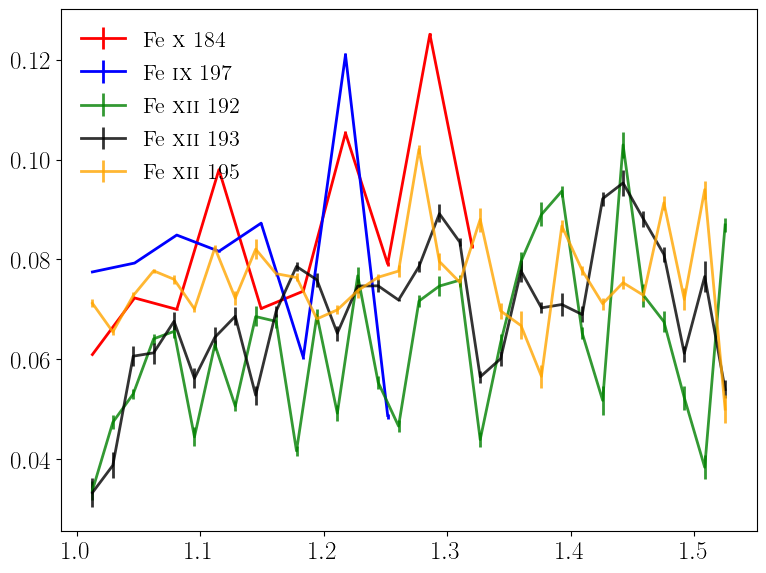

In [829]:
fig, ax = plt.subplots(figsize=(8,6))
ln1 = ax.errorbar(r_coord_32[:10],fwhm_184_cor_mcmc[:10],yerr = [fwhm_184_err_down_mcmc[:10],fwhm_184_err_up_mcmc[:10]],
                   color = 'red',linewidth=2,alpha=1,label=r'Fe \textsc{x} 184')

ln2 = ax.errorbar(r_coord_32[:8],fwhm_197_cor_mcmc[:8],yerr = [fwhm_197_err_down_mcmc[:8],fwhm_184_err_up_mcmc[:8]],
                   color = 'blue',linewidth=2,alpha=1,label=r'Fe \textsc{ix} 197')

ln3 = ax.errorbar(r_coord,fwhm_192_cor_mcmc,yerr = [fwhm_192_err_down_mcmc,fwhm_192_err_up_mcmc],
                  color = 'green',linewidth=2,alpha=0.8,label=r'Fe \textsc{xii} 192')

ln4 = ax.errorbar(r_coord,fwhm_193_cor_mcmc,yerr = [fwhm_193_err_down_mcmc,fwhm_193_err_up_mcmc],
                  color = 'black',linewidth=2,alpha=0.8,label=r'Fe \textsc{xii} 193')
                  
ln5 = ax.errorbar(r_coord,fwhm_195_cor_mcmc,yerr = [fwhm_195_err_down_mcmc,fwhm_195_err_up_mcmc],
                  color = 'orange',linewidth=2,alpha=0.8,label=r'Fe \textsc{xii} 195')


ax.set_xlabel(r'',fontsize=24)
ax.set_ylabel(r'',fontsize=24)
ax.tick_params(labelsize=18)
leg = [ln1,ln2,ln3,ln4,ln5]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 16,frameon=False)
plt.subplots_adjust(bottom = 0.1,left=0.1,top=0.97,right=0.97)

In [147]:
%store -r awsom_y
%store -r awsom_192_fwhm
%store -r awsom_192_fwhm_err
%store -r awsom_193_fwhm
%store -r awsom_193_fwhm_err
%store -r awsom_195_fwhm
%store -r awsom_195_fwhm_err
%store -r awsom_202_fwhm
%store -r awsom_202_fwhm_err
%store -r awsom_195_cent
%store -r awsom_195_cent_err

hf = h5py.File('../save/FeXII_new_bk.h5', 'r')
awsom_202_fwhm = hf.get('awsom_202_fwhm')
awsom_202_fwhm_err = hf.get('awsom_202_fwhm_err')
awsom_193_fwhm = hf.get('awsom_193_fwhm')
awsom_193_fwhm_err = hf.get('awsom_193_fwhm_err')

In [266]:
popt_old = hf.get('popt')
popt_old.value

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


array([-2.45908284, 10.2356626 ])

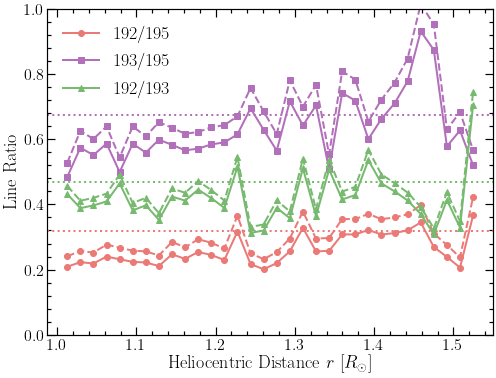

In [136]:
int_195 = np.flip(FeXII_195.get_para(mcmc=True)[:,0])# + g_192_stray.intensity.value
int_192 = np.flip(FeXII_192.get_para(mcmc=True)[:,0])# + g_193_stray.intensity.value
int_193 = np.flip(FeXII_193.get_para(mcmc=True)[:,0])# + g_195_stray.intensity.value

int_195_gdz = np.flip(FeXII_195.get_para(mcmc=True)[:,0]) * 1.00140/0.766406
int_192_gdz = np.flip(FeXII_192.get_para(mcmc=True)[:,0]) *  1.12690/0.747802
int_193_gdz = np.flip(FeXII_193.get_para(mcmc=True)[:,0]) *  1.05693 /0.742308

fig, ax = plt.subplots(figsize=(8,6))
ln1, = ax.plot(r_coord,int_192/int_195,color = '#EB7A77',linewidth=2,label = '192/195',marker = 'o')
ln4, = ax.plot(r_coord,int_192_gdz/int_195_gdz,color = "#EB7A77",linewidth=2,label = '192/195-GDZ',marker = 'o',ls='--')#F596AA'
ax.axhline(0.317,color = '#EB7A77',ls = ':',lw=2)
ln2, = ax.plot(r_coord,int_193/int_195,color = '#b26fba',linewidth=2,label = '193/195',marker = 's')#F9BF45'
ln5, = ax.plot(r_coord,int_193_gdz/int_195_gdz,color = '#b26fba',linewidth=2,label = '193/195-GDZ',marker = 's',ls='--')
ax.axhline(0.675,color = '#b26fba',ls = ':',lw=2)
ln3, = ax.plot(r_coord,int_192/int_193,color = '#77ba6f',linewidth=2,label = '192/193',marker = '^')#2EA9DF'
ln6, = ax.plot(r_coord,int_192_gdz/int_193_gdz,color = '#77ba6f',linewidth=2,label = '192/193-GDZ',marker = '^',ls='--')
ax.axhline(0.470,color = '#77ba6f',ls = ':',lw=2)
ax.set_ylim(0,1)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xlabel(r'Heliocentric Distance $r\ [R_\odot]$',fontsize=18)
ax.set_ylabel(r'Line Ratio',fontsize=18)
ax.tick_params(labelsize=16)
ax.tick_params(which="major",width=1.2,length=8)
ax.tick_params(which="minor",width=1.2,length=4)
leg = [ln1,ln2,ln3]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 18,frameon=False)
#plt.subplots_adjust(bottom = 0.12,left=0.15,top=0.97,right=0.97)
plt.savefig(fname = '../figs/line_ratio.pdf', dpi = 300, format = 'pdf')

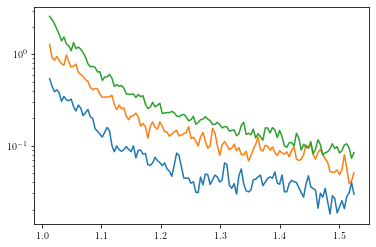

In [667]:
plt.semilogy(r_coord_4, np.flip(FeXII_192_4.get_para()[:,0]))
plt.semilogy(r_coord_4, np.flip(FeXII_193_4.get_para()[:,0]))
plt.semilogy(r_coord_4, np.flip(FeXII_195_4.get_para()[:,0]))

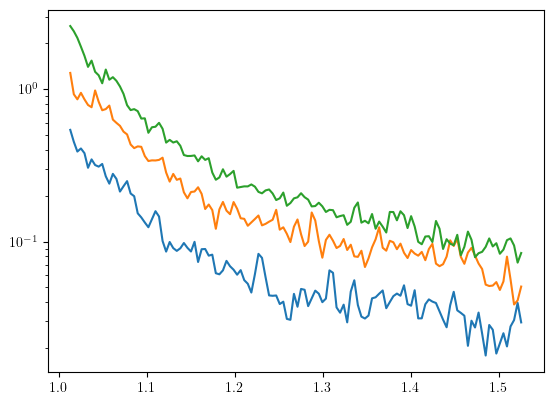

In [726]:
plt.semilogy(r_coord_4, np.flip(FeXII_192_4.get_para()[:,0]))
plt.semilogy(r_coord_4, np.flip(FeXII_193_4.get_para()[:,0]))
plt.semilogy(r_coord_4, np.flip(FeXII_195_4.get_para()[:,0]))

(0, 1)

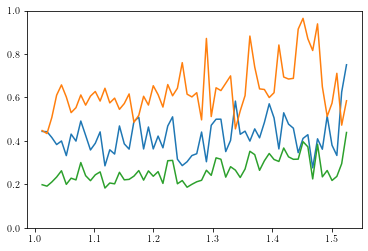

In [672]:
plt.plot(r_coord_8, np.flip(FeXII_192_8.get_para()[:,0])/np.flip(FeXII_193_8.get_para()[:,0]))
plt.plot(r_coord_8, np.flip(FeXII_193_8.get_para()[:,0])/np.flip(FeXII_195_8.get_para()[:,0]))
plt.plot(r_coord_8, np.flip(FeXII_192_8.get_para()[:,0])/np.flip(FeXII_195_8.get_para()[:,0]))
plt.ylim(0,1)

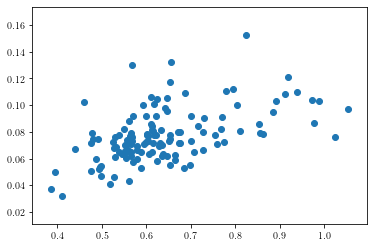

In [660]:
plt.scatter(FeXII_193_4.get_para()[:,0]/FeXII_195_4.get_para()[:,0],np.sqrt((FeXII_193_4.get_para()[:,2])**2 - 0.06**2))

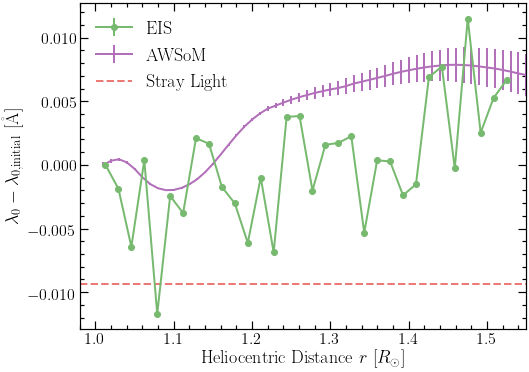

In [138]:
line_cent_pos = np.flip(FeXII_195.get_para()[:,1])
line_cent_195_down_mcmc = np.flip(FeXII_192.get_error(mcmc=True)[:,0,1])
line_cent_195_up_mcmc = np.flip(FeXII_192.get_error(mcmc=True)[:,1,1])

fig, ax = plt.subplots(figsize=(8,6))


ln2 = ax.errorbar(-awsom_y[:-1],awsom_195_cent[:-1] - awsom_195_cent[-2],yerr = awsom_195_cent_err[:-1],
                  color = '#b26fba',linewidth=2,alpha=1,label=r'AWSoM')#F9BF45

ln1 = ax.errorbar(r_coord,line_cent_pos - line_cent_pos[0],yerr = [line_cent_195_down_mcmc,line_cent_195_up_mcmc],
                  color = '#77ba6f',linewidth=2,alpha=1,label=r'EIS',marker="o")#F596AA

ln3 = ax.axhline(g_195_stray.mean.value-line_cent_pos[0],color="#EB7A77",label="Stray Light",ls="--",lw=2)#86C166

leg = [ln1,ln2,ln3]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 18,frameon=False)
ax.set_xlabel(r'Heliocentric Distance $r\ [R_\odot]$',fontsize=18)
ax.set_ylabel(r'$\lambda_0 - \lambda_{0,\mathrm{initial}}$ [\mbox{\AA}]',fontsize=18)
#ax.xaxis.set_minor_locator(AutoMinorLocator(5))
#ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(labelsize=16)
ax.tick_params(which="major",width=1.2,length=8)
ax.tick_params(which="minor",width=1.2,length=4)
ax.set_xlim(0.98,1.55)
#plt.subplots_adjust(bottom = 0.12,left=0.17,top=0.97,right=0.97)
plt.savefig(fname = '../figs/line_cent.pdf', dpi = 300, format = 'pdf')

In [637]:
line_cent_pos[0]

0.06289481334201241

In [635]:
%store r_coord
%store fwhm_195_cor_mcmc
%store fwhm_195_err_down_mcmc
%store fwhm_195_err_up_mcmc

Stored 'r_coord' (ndarray)
Stored 'fwhm_195_cor_mcmc' (ndarray)
Stored 'fwhm_195_err_down_mcmc' (ndarray)
Stored 'fwhm_195_err_up_mcmc' (ndarray)


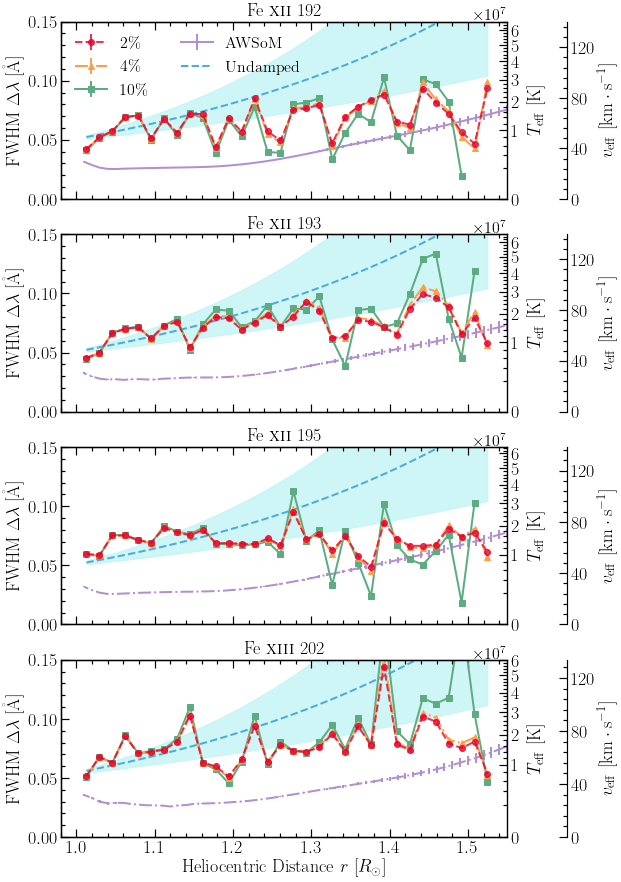

In [226]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(8,15))

x_start = (3 + 8 - (19+255) + 1242)/data_set["rsun"]
x_end = (514 - 8 - (19+255) + 1242)/data_set["rsun"]
r_coord = np.linspace(x_start,x_end,32)

#for ax_ in (ax1,ax2,ax3,ax4):
#    ax_.plot(r_coord,5*np.power(10,ne_func(r_coord,popt_FeXII[0],popt_FeXII[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#    ax_.fill_between(r_coord,1.1*np.power(10,ne_func(r_coord,popt_FeXII[0] - perr_FeXII[0],popt_FeXII[1])/(-4)),
#                     25*np.power(10,ne_func(r_coord,popt_FeXII[0] + perr_FeXII[0],popt_FeXII[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ln5, = ax1.plot(r_coord,7*np.power(10,ne_func(r_coord,popt_FeXII[0],popt_FeXII[1])/(-4)),color = "#4babdb",alpha = 1,lw=2,ls = '--',label="Undamped")
ax1.fill_between(r_coord,12.5*1.4*np.power(10,ne_func(r_coord,popt_FeXII[0] + perr_FeXII[0],popt_FeXII[1])/(-4)),
                 2*1.4*np.power(10,ne_func(r_coord,popt_FeXII[0] - perr_FeXII[0],popt_FeXII[1])/(-4)),color = "#baf3f5",alpha = 0.7)

ln4 = ax1.errorbar(-awsom_y[:-1],awsom_192_fwhm[:-1],yerr = awsom_192_fwhm_err[:-1],
                   color = '#B28FCE',linewidth=2,ls = '-',alpha=1,label='AWSoM')


ln3 = ax1.errorbar(r_coord[:-1],fwhm_192_cor_bbs_mcmc[:-1],yerr = [fwhm_192_err_bbs_down_mcmc[:-1],fwhm_193_err_bbs_up_mcmc[:-1]],
                   color = '#5DAC81',linewidth=2,ls = '-',alpha=1,label=r'10\%',marker="s")

ln2 = ax1.errorbar(r_coord,fwhm_192_cor_bs_mcmc,yerr = [fwhm_192_err_bs_down_mcmc,fwhm_192_err_bs_up_mcmc],
                   color = '#FC9F4D',linewidth=2,ls = '-.',alpha=1,label=r'4\%',marker="^")

ln1 = ax1.errorbar(r_coord,fwhm_192_cor_mcmc,yerr = [fwhm_192_err_down_mcmc,fwhm_192_err_up_mcmc],
                   color = '#E9002D',linewidth=2,alpha=0.8,label=r'2\%',marker="o",ls="--")


ax2.plot(r_coord,7*np.power(10,ne_func(r_coord,popt_FeXII[0],popt_FeXII[1])/(-4)),color = "#4babdb",alpha = 1,lw=2,ls = '--',label="Undamped")
ax2.fill_between(r_coord,12.5*1.4*np.power(10,ne_func(r_coord,popt_FeXII[0] + perr_FeXII[0],popt_FeXII[1])/(-4)),
                 2*1.4*np.power(10,ne_func(r_coord,popt_FeXII[0] - perr_FeXII[0],popt_FeXII[1])/(-4)),color = "#baf3f5",alpha = 0.7)

ax2.errorbar(-awsom_y[:-1],awsom_193_fwhm[:-1],yerr = awsom_193_fwhm_err[:-1],
                   color = '#B28FCE',linewidth=2,ls = '-.',alpha=1,label='AWSoM')

ax2.errorbar(r_coord,fwhm_193_cor_bbs_mcmc,yerr = [fwhm_193_err_bbs_down_mcmc,fwhm_193_err_bbs_up_mcmc],
             color = '#5DAC81',linewidth=2,ls = '-',alpha=1,label=r'10\%',marker="s")

ax2.errorbar(r_coord,fwhm_193_cor_bs_mcmc,yerr = [fwhm_193_err_bs_down_mcmc,fwhm_193_err_bs_up_mcmc],
             color = '#FC9F4D',linewidth=2,ls = '-.',alpha=1,label=r'4\%',marker="^")

ax2.errorbar(r_coord,fwhm_193_cor_mcmc,yerr = [fwhm_193_err_down_mcmc,fwhm_193_err_up_mcmc],
             color = '#E9002D',linewidth=2,alpha=0.8,label=r'2\%',marker="o",ls="--")


ax3.plot(r_coord,7*np.power(10,ne_func(r_coord,popt_FeXII[0],popt_FeXII[1])/(-4)),color =  "#4babdb",alpha = 1,lw=2,ls = '--',label="Undamped")
ax3.fill_between(r_coord,12.5*1.4*np.power(10,ne_func(r_coord,popt_FeXII[0] + perr_FeXII[0],popt_FeXII[1])/(-4)),
                 2*1.4*np.power(10,ne_func(r_coord,popt_FeXII[0] - perr_FeXII[0],popt_FeXII[1])/(-4)),color = "#baf3f5",alpha = 0.7)

ax3.errorbar(-awsom_y[:-1],awsom_195_fwhm[:-1],yerr = awsom_195_fwhm_err[:-1],
                   color = '#B28FCE',linewidth=2,ls = '-.',alpha=1,label='AWSoM')

ax3.errorbar(r_coord,fwhm_195_cor_bbs_mcmc,yerr = [fwhm_195_err_bbs_down_mcmc,fwhm_195_err_bbs_up_mcmc],
             color = '#5DAC81',linewidth=2,ls = '-',alpha=1,label=r'10\%',marker="s")

ax3.errorbar(r_coord,fwhm_195_cor_bs_mcmc,yerr = [fwhm_195_err_bs_down_mcmc,fwhm_195_err_bs_up_mcmc],
             color = '#FC9F4D',linewidth=2,ls = '-.',alpha=1,label=r'4\%',marker="^")

ax3.errorbar(r_coord,fwhm_195_cor_mcmc,yerr = [fwhm_195_err_down_mcmc,fwhm_195_err_up_mcmc],
             color = '#E9002D',linewidth=2,alpha=0.8,label=r'2\%',marker="o",ls="--")


#ax4.plot(r_coord,2*np.power(10,ne_func(r_coord,popt_FeXII[0],popt_FeXII[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#ax4.fill_between(r_coord,9*np.power(10,ne_func(r_coord,popt_FeXII[0] + perr_FeXII[0],popt_FeXII[1])/(-4)),
#                 0.44*np.power(10,ne_func(r_coord,popt_FeXII[0] - perr_FeXII[0],popt_FeXII[1])/(-4)),color = "#7DB9DE",alpha = 0.1)
ax4.plot(r_coord,7.5*np.power(10,ne_func(r_coord,popt_FeXII[0],popt_FeXII[1])/(-4)),color = "#4babdb",alpha = 1,lw=2,ls = '--',label="Undamped")
ax4.fill_between(r_coord,12.5*1.5*np.power(10,ne_func(r_coord,popt_FeXII[0] + perr_FeXII[0],popt_FeXII[1])/(-4)),
                 2*1.5*np.power(10,ne_func(r_coord,popt_FeXII[0] - perr_FeXII[0],popt_FeXII[1])/(-4)),color = "#baf3f5",alpha = 0.7)
ax4.errorbar(-awsom_y[:-1],awsom_202_fwhm[:-1],yerr = awsom_202_fwhm_err[:-1],
                   color = '#B28FCE',linewidth=2,ls = '-.',alpha=1,label='AWSoM')

ax4.errorbar(r_coord,fwhm_202_cor_bbs_mcmc,yerr = [fwhm_202_err_bbs_down_mcmc,fwhm_202_err_bbs_up_mcmc],
             color = '#5DAC81',linewidth=2,ls = '-',alpha=1,label=r'10\%',marker="s")

ax4.errorbar(r_coord,fwhm_202_cor_bs_mcmc,yerr = [fwhm_202_err_bs_down_mcmc,fwhm_202_err_bs_up_mcmc],
             color = '#FC9F4D',linewidth=2,ls = '-.',alpha=1,label=r'4\%',marker="^")

ax4.errorbar(r_coord,fwhm_202_cor_mcmc,yerr = [fwhm_202_err_down_mcmc,fwhm_202_err_up_mcmc],
             color = '#E9002D',linewidth=2,alpha=0.8,label=r'2\%',marker="o",ls="--")

ax1.set_title(r"Fe \textsc{xii} 192",fontsize=18)
ax2.set_title(r"Fe \textsc{xii} 193",fontsize=18)
ax3.set_title(r"Fe \textsc{xii} 195",fontsize=18)
ax4.set_title(r"Fe \textsc{xiii} 202",fontsize=18)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
for ax_ in (ax1,ax2,ax3,ax4):
    ax_.set_ylim((0,0.15))
    ax_.set_yticks([0.0,0.05,0.10,0.15])
    

ax1_t = ax1.twinx()
ax1_v = ax1.twinx()
ax1_v.spines['right'].set_position(('outward', 60))    

ax2_t = ax2.twinx()
ax2_v = ax2.twinx()
ax2_v.spines['right'].set_position(('outward', 60))  

ax3_t = ax3.twinx()
ax3_v = ax3.twinx()
ax3_v.spines['right'].set_position(('outward', 60))  

ax4_t = ax4.twinx()
ax4_v = ax4.twinx()
ax4_v.spines['right'].set_position(('outward', 60))  



def forward(x):
    return x**(1/2)
def inverse(x):
    return x**2

line_lambda0 = np.array([192.394,193.509,195.119,202.044])
for ii,ax_ in enumerate((ax1_t,ax2_t,ax3_t,ax4_t)):
    ax_t_ticks = np.square(np.array([0.,0.05,0.10,0.15])/line_lambda0[ii]*c)*56*amu/2/k_B/(4*np.log(2))
    ax_.set_ylim(ax_t_ticks[0],ax_t_ticks[-1])
    ax_.set_yscale('function', functions=(forward, inverse))
    #ax_.set_yticklabels(ax1_t_ticks)
    ax_.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.set_ylabel(r'$T_{\rm eff}$ [K]',fontsize = 18,labelpad=10)
    ax_.yaxis.set_major_locator(ticker.MaxNLocator(8))
ax4_t.yaxis.set_major_locator(ticker.MaxNLocator(7))

for ii,ax_ in enumerate((ax1_v,ax2_v,ax3_v,ax4_v)):
    ax_v_ticks = np.array([0.,0.05,0.10,0.15])/line_lambda0[ii]*c/np.sqrt(4*np.log(2))/1.e5
    ax_.set_ylim((ax_v_ticks[0],ax_v_ticks[-1]))
    ax_.set_ylabel(r'$v_{\rm eff}\ [\mathrm{km\cdot s^{-1}}]$',fontsize = 18)
    ax_.yaxis.set_major_locator(ticker.MaxNLocator(4))

for ax_ in (ax1,ax2,ax3,ax1_t,ax1_v,ax2_t,ax2_v,ax3_t,ax3_v,ax4_t,ax4_v):
    #ax_.set_xlabel(r'',fontsize=24)
    #ax_.set_ylabel(r'',fontsize=24)
    ax_.tick_params(labelsize=18)
    ax_.tick_params(which="major",width=1.2,length=8)
    ax_.tick_params(which="minor",width=1.2,length=4)
    ax_.yaxis.set_minor_locator(AutoMinorLocator(5))


leg = [ln1,ln2,ln3,ln4,ln5]
#ax1.legend(leg,[leg_.get_label() for leg_ in leg],bbox_to_anchor=(-0.15,1.1,1,0.2), loc="upper left",fontsize = 16,ncol=5)
ax1.legend(leg,[leg_.get_label() for leg_ in leg], loc="upper left",fontsize = 16,ncol=2)
for ax_ in (ax1,ax2,ax3,ax4):
    ax_.set_xlabel(r'',fontsize=18)
    ax_.set_ylabel(r'FWHM $\Delta \lambda\ [\mathrm{\AA}]$',fontsize =18)
    ax_.tick_params(labelsize=18)
    ax_.tick_params(which="major",width=1.2,length=8)
    ax_.tick_params(which="minor",width=1.2,length=4)
    ax_.set_xlim(0.98,1.55)
    #ax_.xaxis.set_minor_locator(AutoMinorLocator(5))
    #ax_.yaxis.set_minor_locator(AutoMinorLocator(5))
ax4.set_xlabel(r'Heliocentric Distance $r\ [R_\odot]$',fontsize=18)
#plt.subplots_adjust(bottom = 0.05,left=0.15,top=0.94,right=0.8)
#plt.savefig(fname = '../figs/eis_awsom_mcmc.png', dpi = 300, format = 'png')
plt.savefig(fname = '../figs/eis_awsom_mcmc.pdf', dpi = 300, format = 'pdf')

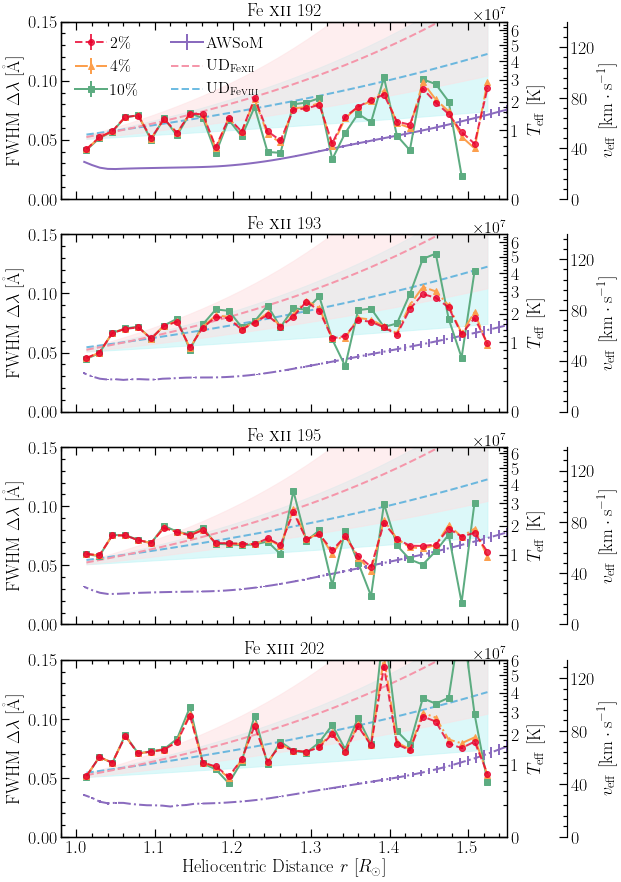

In [311]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(8,15))

x_start = (3 + 8 - (19+255) + 1242)/data_set["rsun"]
x_end = (514 - 8 - (19+255) + 1242)/data_set["rsun"]
r_coord = np.linspace(x_start,x_end,32)

#for ax_ in (ax1,ax2,ax3,ax4):
#    ax_.plot(r_coord,5*np.power(10,ne_func(r_coord,popt_FeXII[0],popt_FeXII[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#    ax_.fill_between(r_coord,1.1*np.power(10,ne_func(r_coord,popt_FeXII[0] - perr_FeXII[0],popt_FeXII[1])/(-4)),
#                     25*np.power(10,ne_func(r_coord,popt_FeXII[0] + perr_FeXII[0],popt_FeXII[1])/(-4)),color = "#7DB9DE",alpha = 0.1)
ln6, = ax1.plot(r_coord,5*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#4babdb",alpha = 0.8,lw=2,
                ls = '--',label=r"$\mathrm{UD}_{\mathrm{Fe} \textsc{viii}}$")
ax1.fill_between(r_coord,11*np.power(10,ne_func(r_coord,popt[0] + perr[0]*0.8,popt[1])/(-4)),
                 2.1*np.power(10,ne_func(r_coord,popt[0] - perr[0]*0.8,popt[1])/(-4)),color = "#baf3f5",alpha = 0.5)


ln5, = ax1.plot(r_coord,7*np.power(10,ne_func(r_coord,popt_FeXII[0],popt_FeXII[1])/(-4)),color = "#F596AA",alpha = 1,
                lw=2,ls = '--',label=r"$\mathrm{UD}_{\mathrm{Fe} \textsc{xii}}$")
ax1.fill_between(r_coord,12.5*1.4*np.power(10,ne_func(r_coord,popt_FeXII[0] + perr_FeXII[0],popt_FeXII[1])/(-4)),
                 2*1.4*np.power(10,ne_func(r_coord,popt_FeXII[0] - perr_FeXII[0],popt_FeXII[1])/(-4)),color = "#FEDFE1",alpha = 0.5)

ln4 = ax1.errorbar(-awsom_y[:-1],awsom_192_fwhm[:-1],yerr = awsom_192_fwhm_err[:-1],
                   color = '#8A6BBE',linewidth=2,ls = '-',alpha=1,label='AWSoM')


ln3 = ax1.errorbar(r_coord[:-1],fwhm_192_cor_bbs_mcmc[:-1],yerr = [fwhm_192_err_bbs_down_mcmc[:-1],fwhm_193_err_bbs_up_mcmc[:-1]],
                   color = '#5DAC81',linewidth=2,ls = '-',alpha=1,label=r'10\%',marker="s")

ln2 = ax1.errorbar(r_coord,fwhm_192_cor_bs_mcmc,yerr = [fwhm_192_err_bs_down_mcmc,fwhm_192_err_bs_up_mcmc],
                   color = '#FC9F4D',linewidth=2,ls = '-.',alpha=1,label=r'4\%',marker="^")

ln1 = ax1.errorbar(r_coord,fwhm_192_cor_mcmc,yerr = [fwhm_192_err_down_mcmc,fwhm_192_err_up_mcmc],
                   color = '#E9002D',linewidth=2,alpha=0.8,label=r'2\%',marker="o",ls="--")


ax2.plot(r_coord,5*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#4babdb",alpha = 0.8,lw=2,
                ls = '--',label=r"$n_{\mathrm{Fe} \textsc{viii}}$")
ax2.fill_between(r_coord,11*np.power(10,ne_func(r_coord,popt[0] + perr[0]*0.8,popt[1])/(-4)),
                 2.1*np.power(10,ne_func(r_coord,popt[0] - perr[0]*0.8,popt[1])/(-4)),color = "#baf3f5",alpha = 0.5)


ax2.plot(r_coord,7*np.power(10,ne_func(r_coord,popt_FeXII[0],popt_FeXII[1])/(-4)),color = "#F596AA",alpha = 1,
                lw=2,ls = '--',label=r"$n_{\mathrm{Fe} \textsc{xii}}$")
ax2.fill_between(r_coord,12.5*1.4*np.power(10,ne_func(r_coord,popt_FeXII[0] + perr_FeXII[0],popt_FeXII[1])/(-4)),
                 2*1.4*np.power(10,ne_func(r_coord,popt_FeXII[0] - perr_FeXII[0],popt_FeXII[1])/(-4)),color = "#FEDFE1",alpha = 0.5)


ax2.errorbar(-awsom_y[:-1],awsom_193_fwhm[:-1],yerr = awsom_193_fwhm_err[:-1],
                   color = '#8A6BBE',linewidth=2,ls = '-.',alpha=1,label='AWSoM')

ax2.errorbar(r_coord,fwhm_193_cor_bbs_mcmc,yerr = [fwhm_193_err_bbs_down_mcmc,fwhm_193_err_bbs_up_mcmc],
             color = '#5DAC81',linewidth=2,ls = '-',alpha=1,label=r'10\%',marker="s")

ax2.errorbar(r_coord,fwhm_193_cor_bs_mcmc,yerr = [fwhm_193_err_bs_down_mcmc,fwhm_193_err_bs_up_mcmc],
             color = '#FC9F4D',linewidth=2,ls = '-.',alpha=1,label=r'4\%',marker="^")

ax2.errorbar(r_coord,fwhm_193_cor_mcmc,yerr = [fwhm_193_err_down_mcmc,fwhm_193_err_up_mcmc],
             color = '#E9002D',linewidth=2,alpha=0.8,label=r'2\%',marker="o",ls="--")


ax3.plot(r_coord,5*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#4babdb",alpha = 0.8,lw=2,
                ls = '--',label=r"$n_{\mathrm{Fe} \textsc{viii}}$")
ax3.fill_between(r_coord,11*np.power(10,ne_func(r_coord,popt[0] + perr[0]*0.8,popt[1])/(-4)),
                 2.1*np.power(10,ne_func(r_coord,popt[0] - perr[0]*0.8,popt[1])/(-4)),color = "#baf3f5",alpha = 0.5)


ax3.plot(r_coord,7*np.power(10,ne_func(r_coord,popt_FeXII[0],popt_FeXII[1])/(-4)),color = "#F596AA",alpha = 1,
                lw=2,ls = '--',label=r"$n_{\mathrm{Fe} \textsc{xii}}$")
ax3.fill_between(r_coord,12.5*1.4*np.power(10,ne_func(r_coord,popt_FeXII[0] + perr_FeXII[0],popt_FeXII[1])/(-4)),
                 2*1.4*np.power(10,ne_func(r_coord,popt_FeXII[0] - perr_FeXII[0],popt_FeXII[1])/(-4)),color = "#FEDFE1",alpha = 0.5)

ax3.errorbar(-awsom_y[:-1],awsom_195_fwhm[:-1],yerr = awsom_195_fwhm_err[:-1],
                   color = '#8A6BBE',linewidth=2,ls = '-.',alpha=1,label='AWSoM')

ax3.errorbar(r_coord,fwhm_195_cor_bbs_mcmc,yerr = [fwhm_195_err_bbs_down_mcmc,fwhm_195_err_bbs_up_mcmc],
             color = '#5DAC81',linewidth=2,ls = '-',alpha=1,label=r'10\%',marker="s")

ax3.errorbar(r_coord,fwhm_195_cor_bs_mcmc,yerr = [fwhm_195_err_bs_down_mcmc,fwhm_195_err_bs_up_mcmc],
             color = '#FC9F4D',linewidth=2,ls = '-.',alpha=1,label=r'4\%',marker="^")

ax3.errorbar(r_coord,fwhm_195_cor_mcmc,yerr = [fwhm_195_err_down_mcmc,fwhm_195_err_up_mcmc],
             color = '#E9002D',linewidth=2,alpha=0.8,label=r'2\%',marker="o",ls="--")


#ax4.plot(r_coord,2*np.power(10,ne_func(r_coord,popt_FeXII[0],popt_FeXII[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#ax4.fill_between(r_coord,9*np.power(10,ne_func(r_coord,popt_FeXII[0] + perr_FeXII[0],popt_FeXII[1])/(-4)),
#                 0.44*np.power(10,ne_func(r_coord,popt_FeXII[0] - perr_FeXII[0],popt_FeXII[1])/(-4)),color = "#7DB9DE",alpha = 0.1)
ax4.plot(r_coord,5*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#4babdb",alpha = 0.8,lw=2,
                ls = '--',label=r"$n_{\mathrm{Fe} \textsc{viii}}$")
ax4.fill_between(r_coord,11*np.power(10,ne_func(r_coord,popt[0] + perr[0]*0.8,popt[1])/(-4)),
                 2.1*np.power(10,ne_func(r_coord,popt[0] - perr[0]*0.8,popt[1])/(-4)),color = "#baf3f5",alpha = 0.5)


ax4.plot(r_coord,7*np.power(10,ne_func(r_coord,popt_FeXII[0],popt_FeXII[1])/(-4)),color = "#F596AA",alpha = 1,
                lw=2,ls = '--',label=r"$n_{\mathrm{Fe} \textsc{xii}}$")
ax4.fill_between(r_coord,12.5*1.4*np.power(10,ne_func(r_coord,popt_FeXII[0] + perr_FeXII[0],popt_FeXII[1])/(-4)),
                 2*1.4*np.power(10,ne_func(r_coord,popt_FeXII[0] - perr_FeXII[0],popt_FeXII[1])/(-4)),color = "#FEDFE1",alpha = 0.5)

ax4.errorbar(-awsom_y[:-1],awsom_202_fwhm[:-1],yerr = awsom_202_fwhm_err[:-1],
                   color = '#8A6BBE',linewidth=2,ls = '-.',alpha=1,label='AWSoM')

ax4.errorbar(r_coord,fwhm_202_cor_bbs_mcmc,yerr = [fwhm_202_err_bbs_down_mcmc,fwhm_202_err_bbs_up_mcmc],
             color = '#5DAC81',linewidth=2,ls = '-',alpha=1,label=r'10\%',marker="s")

ax4.errorbar(r_coord,fwhm_202_cor_bs_mcmc,yerr = [fwhm_202_err_bs_down_mcmc,fwhm_202_err_bs_up_mcmc],
             color = '#FC9F4D',linewidth=2,ls = '-.',alpha=1,label=r'4\%',marker="^")

ax4.errorbar(r_coord,fwhm_202_cor_mcmc,yerr = [fwhm_202_err_down_mcmc,fwhm_202_err_up_mcmc],
             color = '#E9002D',linewidth=2,alpha=0.8,label=r'2\%',marker="o",ls="--")

ax1.set_title(r"Fe \textsc{xii} 192",fontsize=18)
ax2.set_title(r"Fe \textsc{xii} 193",fontsize=18)
ax3.set_title(r"Fe \textsc{xii} 195",fontsize=18)
ax4.set_title(r"Fe \textsc{xiii} 202",fontsize=18)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
for ax_ in (ax1,ax2,ax3,ax4):
    ax_.set_ylim((0,0.15))
    ax_.set_yticks([0.0,0.05,0.10,0.15])
    

ax1_t = ax1.twinx()
ax1_v = ax1.twinx()
ax1_v.spines['right'].set_position(('outward', 60))    

ax2_t = ax2.twinx()
ax2_v = ax2.twinx()
ax2_v.spines['right'].set_position(('outward', 60))  

ax3_t = ax3.twinx()
ax3_v = ax3.twinx()
ax3_v.spines['right'].set_position(('outward', 60))  

ax4_t = ax4.twinx()
ax4_v = ax4.twinx()
ax4_v.spines['right'].set_position(('outward', 60))  



def forward(x):
    return x**(1/2)
def inverse(x):
    return x**2

line_lambda0 = np.array([192.394,193.509,195.119,202.044])
for ii,ax_ in enumerate((ax1_t,ax2_t,ax3_t,ax4_t)):
    ax_t_ticks = np.square(np.array([0.,0.05,0.10,0.15])/line_lambda0[ii]*c)*56*amu/2/k_B/(4*np.log(2))
    ax_.set_ylim(ax_t_ticks[0],ax_t_ticks[-1])
    ax_.set_yscale('function', functions=(forward, inverse))
    #ax_.set_yticklabels(ax1_t_ticks)
    ax_.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.set_ylabel(r'$T_{\rm eff}$ [K]',fontsize = 18,labelpad=10)
    ax_.yaxis.set_major_locator(ticker.MaxNLocator(8))
ax4_t.yaxis.set_major_locator(ticker.MaxNLocator(7))

for ii,ax_ in enumerate((ax1_v,ax2_v,ax3_v,ax4_v)):
    ax_v_ticks = np.array([0.,0.05,0.10,0.15])/line_lambda0[ii]*c/np.sqrt(4*np.log(2))/1.e5
    ax_.set_ylim((ax_v_ticks[0],ax_v_ticks[-1]))
    ax_.set_ylabel(r'$v_{\rm eff}\ [\mathrm{km\cdot s^{-1}}]$',fontsize = 18)
    ax_.yaxis.set_major_locator(ticker.MaxNLocator(4))

for ax_ in (ax1,ax2,ax3,ax1_t,ax1_v,ax2_t,ax2_v,ax3_t,ax3_v,ax4_t,ax4_v):
    #ax_.set_xlabel(r'',fontsize=24)
    #ax_.set_ylabel(r'',fontsize=24)
    ax_.tick_params(labelsize=18)
    ax_.tick_params(which="major",width=1.2,length=8)
    ax_.tick_params(which="minor",width=1.2,length=4)
    ax_.yaxis.set_minor_locator(AutoMinorLocator(5))


leg = [ln1,ln2,ln3,ln4,ln5,ln6]
#ax1.legend(leg,[leg_.get_label() for leg_ in leg],bbox_to_anchor=(-0.15,1.1,1,0.2), loc="upper left",fontsize = 16,ncol=5)
ax1.legend(leg,[leg_.get_label() for leg_ in leg], loc="upper left",fontsize = 16,ncol=2,handletextpad=0.2)
for ax_ in (ax1,ax2,ax3,ax4):
    ax_.set_xlabel(r'',fontsize=18)
    ax_.set_ylabel(r'FWHM $\Delta \lambda\ [\mathrm{\AA}]$',fontsize =18)
    ax_.tick_params(labelsize=18)
    ax_.tick_params(which="major",width=1.2,length=8)
    ax_.tick_params(which="minor",width=1.2,length=4)
    ax_.set_xlim(0.98,1.55)
    #ax_.xaxis.set_minor_locator(AutoMinorLocator(5))
    #ax_.yaxis.set_minor_locator(AutoMinorLocator(5))
ax4.set_xlabel(r'Heliocentric Distance $r\ [R_\odot]$',fontsize=18)
#plt.subplots_adjust(bottom = 0.05,left=0.15,top=0.94,right=0.8)
#plt.savefig(fname = '../figs/eis_awsom_mcmc.png', dpi = 300, format = 'png')
plt.savefig(fname = '../figs/eis_awsom_mcmc_more.pdf', dpi = 300, format = 'pdf')

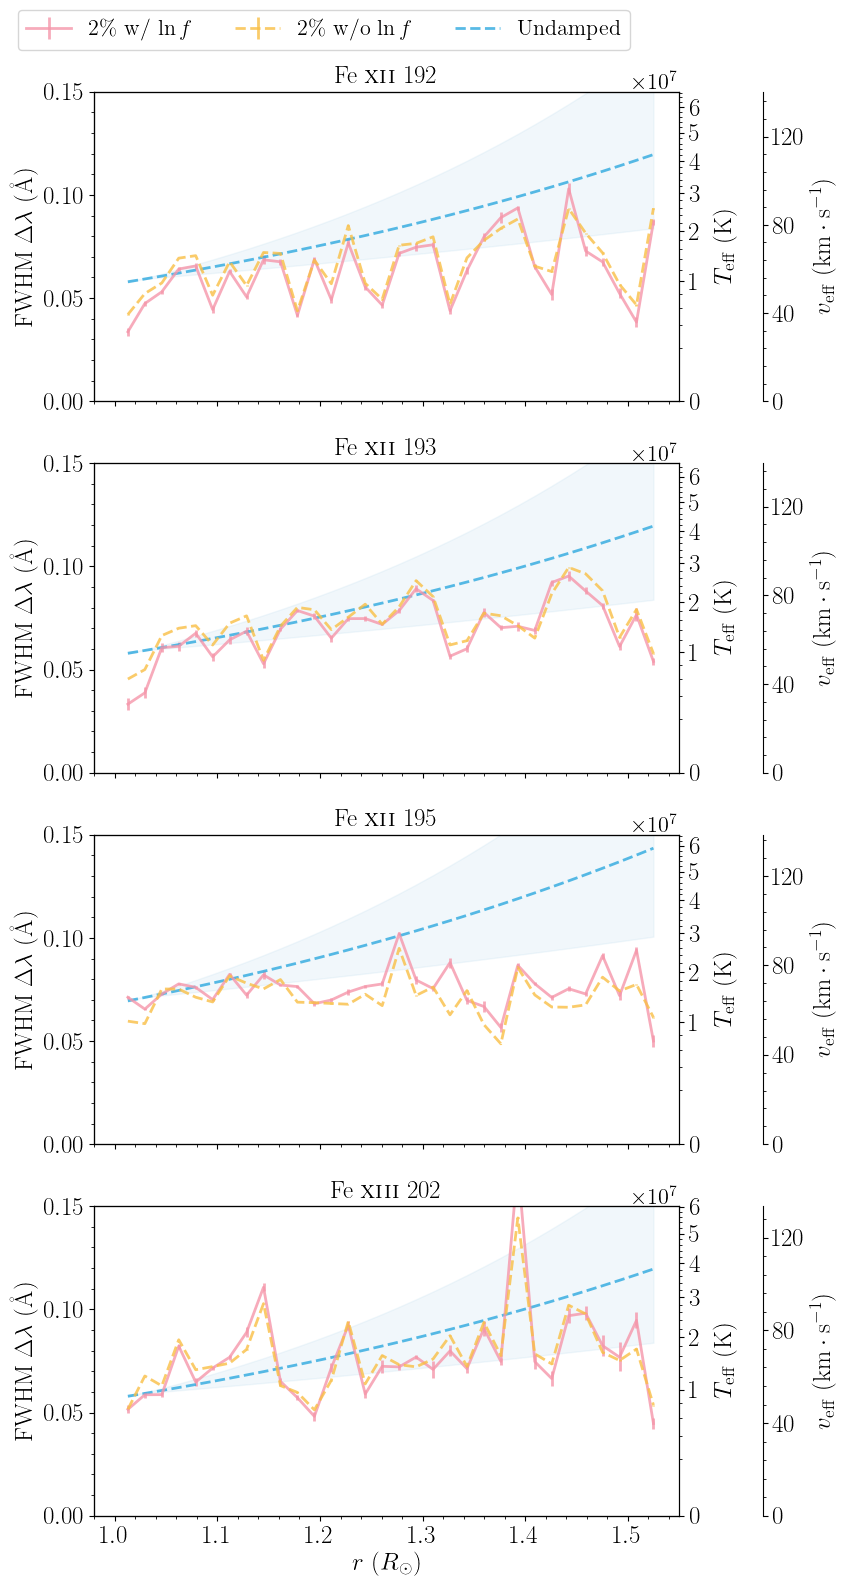

In [782]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(9,16))

x_start = (3 + 8 - (19+255) + 1242)/data_set["rsun"]
x_end = (514 - 8 - (19+255) + 1242)/data_set["rsun"]
r_coord = np.linspace(x_start,x_end,32)

#for ax_ in (ax1,ax2,ax3,ax4):
#    ax_.plot(r_coord,5*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#    ax_.fill_between(r_coord,1.1*np.power(10,ne_func(r_coord,popt[0] - perr[0],popt[1])/(-4)),
#                     25*np.power(10,ne_func(r_coord,popt[0] + perr[0],popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ln1 = ax1.errorbar(r_coord,fwhm_192_cor_mcmc,yerr = [fwhm_192_err_down_mcmc,fwhm_192_err_up_mcmc],color = '#F596AA',linewidth=2,alpha=0.8,label=r'2\% w/ $\ln f$')
ln2 = ax1.errorbar(r_coord,fwhm_192_cor_nof_mcmc,yerr = [fwhm_192_err_nof_down_mcmc,fwhm_192_err_nof_up_mcmc],
                   color = '#F9BF45',linewidth=2,ls = '--',alpha=0.8,label=r'2\% w/o $\ln f$')

ln5, = ax1.plot(r_coord,5*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.8,lw=2,ls = '--',label="Undamped")
ax1.fill_between(r_coord,10.5*np.power(10,ne_func(r_coord,popt[0] + perr[0]*0.5,popt[1])/(-4)),
                 2.4*np.power(10,ne_func(r_coord,popt[0] - perr[0]*0.5,popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ax2.errorbar(r_coord,fwhm_193_cor_mcmc,yerr = [fwhm_193_err_down_mcmc,fwhm_193_err_up_mcmc],color = '#F596AA',linewidth=2,alpha=0.8)
ax2.errorbar(r_coord,fwhm_193_cor_nof_mcmc,yerr = [fwhm_193_err_nof_down_mcmc,fwhm_193_err_nof_up_mcmc]
             ,color = '#F9BF45',linewidth=2,ls = '--',alpha=0.8)
ax2.plot(r_coord,5*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.8,lw=2,ls = '--')
ax2.fill_between(r_coord,10.5*np.power(10,ne_func(r_coord,popt[0] + perr[0]*0.5,popt[1])/(-4)),
                 2.4*np.power(10,ne_func(r_coord,popt[0] - perr[0]*0.5,popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ax3.fill_between(r_coord,10.5*1.2*np.power(10,ne_func(r_coord,popt[0] + perr[0]*0.5,popt[1])/(-4)),
                 2.4*1.2*np.power(10,ne_func(r_coord,popt[0] - perr[0]*0.5,popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ax3.errorbar(r_coord,fwhm_195_cor_mcmc,yerr = [fwhm_195_err_down_mcmc,fwhm_195_err_up_mcmc],color = '#F596AA',linewidth=2,alpha=0.8)
ax3.errorbar(r_coord,fwhm_195_cor_nof_mcmc,yerr = [fwhm_195_err_nof_down_mcmc,fwhm_195_err_nof_up_mcmc]
             ,color = '#F9BF45',linewidth=2,ls = '--',alpha=0.8)

ax3.plot(r_coord,6*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.8,lw=2,ls = '--')
#ax4.plot(r_coord,2*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#ax4.fill_between(r_coord,9*np.power(10,ne_func(r_coord,popt[0] + perr[0],popt[1])/(-4)),
#                 0.44*np.power(10,ne_func(r_coord,popt[0] - perr[0],popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ax4.errorbar(r_coord,fwhm_202_cor_mcmc,yerr = [fwhm_202_err_down_mcmc,fwhm_202_err_up_mcmc],color = '#F596AA',linewidth=2,alpha=0.8)
ax4.errorbar(r_coord,fwhm_202_cor_nof_mcmc,yerr = [fwhm_202_err_nof_down_mcmc,fwhm_202_err_nof_up_mcmc],
             color = '#F9BF45',linewidth=2,ls = '--',alpha=0.8)

ax4.plot(r_coord,5*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.8,lw=2,ls = '--')
ax4.fill_between(r_coord,10.5*np.power(10,ne_func(r_coord,popt[0] + perr[0]*0.5,popt[1])/(-4)),
                 2.4*np.power(10,ne_func(r_coord,popt[0] - perr[0]*0.5,popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ax1.set_title(r"Fe \textsc{xii} 192",fontsize=18)
ax2.set_title(r"Fe \textsc{xii} 193",fontsize=18)
ax3.set_title(r"Fe \textsc{xii} 195",fontsize=18)
ax4.set_title(r"Fe \textsc{xiii} 202",fontsize=18)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
for ax_ in (ax1,ax2,ax3,ax4):
    ax_.set_ylim((0,0.15))
    ax_.set_yticks([0.0,0.05,0.10,0.15])
    

ax1_t = ax1.twinx()
ax1_v = ax1.twinx()
ax1_v.spines['right'].set_position(('outward', 60))    

ax2_t = ax2.twinx()
ax2_v = ax2.twinx()
ax2_v.spines['right'].set_position(('outward', 60))  

ax3_t = ax3.twinx()
ax3_v = ax3.twinx()
ax3_v.spines['right'].set_position(('outward', 60))  

ax4_t = ax4.twinx()
ax4_v = ax4.twinx()
ax4_v.spines['right'].set_position(('outward', 60))  



def forward(x):
    return x**(1/2)
def inverse(x):
    return x**2

line_lambda0 = np.array([192.394,193.509,195.119,202.044])
for ii,ax_ in enumerate((ax1_t,ax2_t,ax3_t,ax4_t)):
    ax_t_ticks = np.square(np.array([0.,0.05,0.10,0.15])/line_lambda0[ii]*c)*56*amu/2/k_B/(4*np.log(2))
    ax_.set_ylim(ax_t_ticks[0],ax_t_ticks[-1])
    ax_.set_yscale('function', functions=(forward, inverse))
    #ax_.set_yticklabels(ax1_t_ticks)
    ax_.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.set_ylabel(r'$T_{\rm eff}$ (K)',fontsize = 18,labelpad=10)
    ax_.yaxis.set_major_locator(ticker.MaxNLocator(8))
ax4_t.yaxis.set_major_locator(ticker.MaxNLocator(7))

for ii,ax_ in enumerate((ax1_v,ax2_v,ax3_v,ax4_v)):
    ax_v_ticks = np.array([0.,0.05,0.10,0.15])/line_lambda0[ii]*c/np.sqrt(4*np.log(2))/1.e5
    ax_.set_ylim((ax_v_ticks[0],ax_v_ticks[-1]))
    ax_.set_ylabel(r'$v_{\rm eff}\ (\mathrm{km\cdot s^{-1}})$',fontsize = 18)
    ax_.yaxis.set_major_locator(ticker.MaxNLocator(4))

for ax_ in (ax1,ax2,ax3,ax1_t,ax1_v,ax2_t,ax2_v,ax3_t,ax3_v,ax4_t,ax4_v):
    #ax_.set_xlabel(r'',fontsize=24)
    #ax_.set_ylabel(r'',fontsize=24)
    ax_.tick_params(labelsize=18)
    ax_.yaxis.set_minor_locator(AutoMinorLocator(5))

for ax_ in (ax1,ax2,ax3):
    ax_.set_ylabel(r'FWHM $\Delta \lambda\ (\mathrm{\AA})$',fontsize =18)


leg = [ln1,ln2,ln5]
ax1.legend(leg,[leg_.get_label() for leg_ in leg],bbox_to_anchor=(-0.15,1.1,1,0.2), loc="upper left",fontsize = 16,ncol=5)

for ax_ in (ax1,ax2,ax3,ax4):
    ax_.set_xlabel(r'',fontsize=18)
    ax_.set_ylabel(r'FWHM $\Delta \lambda\ (\mathrm{\AA})$',fontsize =18)
    ax_.tick_params(labelsize=18)
    ax_.set_xlim(0.98,1.55)
    ax_.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax_.yaxis.set_minor_locator(AutoMinorLocator(5))
ax4.set_xlabel(r'$r\ (R_\odot)$',fontsize=18)
plt.subplots_adjust(bottom = 0.05,left=0.15,top=0.94,right=0.8)
#plt.savefig(fname = '../figs/eis_awsom_mcmc.png', dpi = 300, format = 'png')
#plt.savefig(fname = '../figs/eis_awsom_mcmc.pdf', dpi = 300, format = 'pdf')

In [784]:
def normcor(a,b):
    a = (a - np.mean(a))/(np.std(a)*len(a))
    b = (b - np.mean(b))/(np.std(b))
    return np.correlate(a,b)

print("192-193",normcor(fwhm_192_cor_mcmc,fwhm_193_cor_mcmc))
print("192-195",normcor(fwhm_192_cor_mcmc,fwhm_195_cor_mcmc))
print("192-202",normcor(fwhm_192_cor_mcmc,fwhm_202_cor_mcmc))
print("193-195",normcor(fwhm_193_cor_mcmc,fwhm_195_cor_mcmc))
print("193-202",normcor(fwhm_193_cor_mcmc,fwhm_202_cor_mcmc))
print("195-202",normcor(fwhm_195_cor_mcmc,fwhm_202_cor_mcmc))

192-193 [0.4338972]
192-195 [-0.14320558]
192-202 [0.4059697]
193-195 [0.25465979]
193-202 [0.22769684]
195-202 [0.39993564]


In [436]:
np.square(np.array([0.02])/line_lambda0[ii]*c)*56*amu/2/k_B/(4*np.log(2))/1e6

array([1.06966522])

In [440]:
np.square(np.array([0.05])/line_lambda0[ii]*c)*56*amu/2/k_B/(4*np.log(2))/1e6

array([6.68540763])

In [441]:
np.sqrt(0.05**2 + 0.02**2)

0.05385164807134505

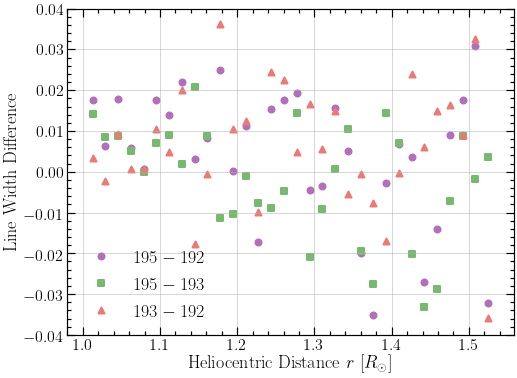

In [140]:
fig, ax = plt.subplots(figsize=(8,6))
ln1 = ax.scatter(r_coord,fwhm_195_cor_mcmc - fwhm_192_cor_mcmc ,color = '#b26fba',label = '$195-192$',marker = 'o',lw=2)
ln2 = ax.scatter(r_coord,fwhm_195_cor_mcmc - fwhm_193_cor_mcmc,color = '#77ba6f',label = '$195-193$',marker = 's',lw=2)
ln3 = ax.scatter(r_coord,fwhm_193_cor_mcmc - fwhm_192_cor_mcmc,color = '#EB7A77',label = '$193-192$',marker = '^',lw=2)
ax.set_ylim(-0.04,0.04)
ax.tick_params(labelsize=16)
leg = [ln1,ln2,ln3]
ax.set_xlabel(r'Heliocentric Distance $r\ [R_\odot]$',fontsize=18)
ax.set_ylabel(r'Line Width Difference',fontsize=18)
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'lower left',fontsize = 18)
ax.tick_params(which="major",width=1.2,length=8)
ax.tick_params(which="minor",width=1.2,length=4)
ax.grid('on')
#plt.subplots_adjust(bottom = 0.12,left=0.15,top=0.97,right=0.97)
plt.savefig(fname = '../figs/line_width_diff.pdf', dpi = 300, format = 'pdf')

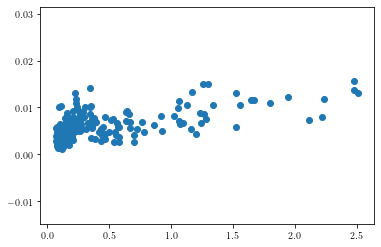

In [370]:
int_195_2 = FeXII_195_2.get_para()[:,0]
plt.scatter(int_195_2,fwhm_195_err_2)

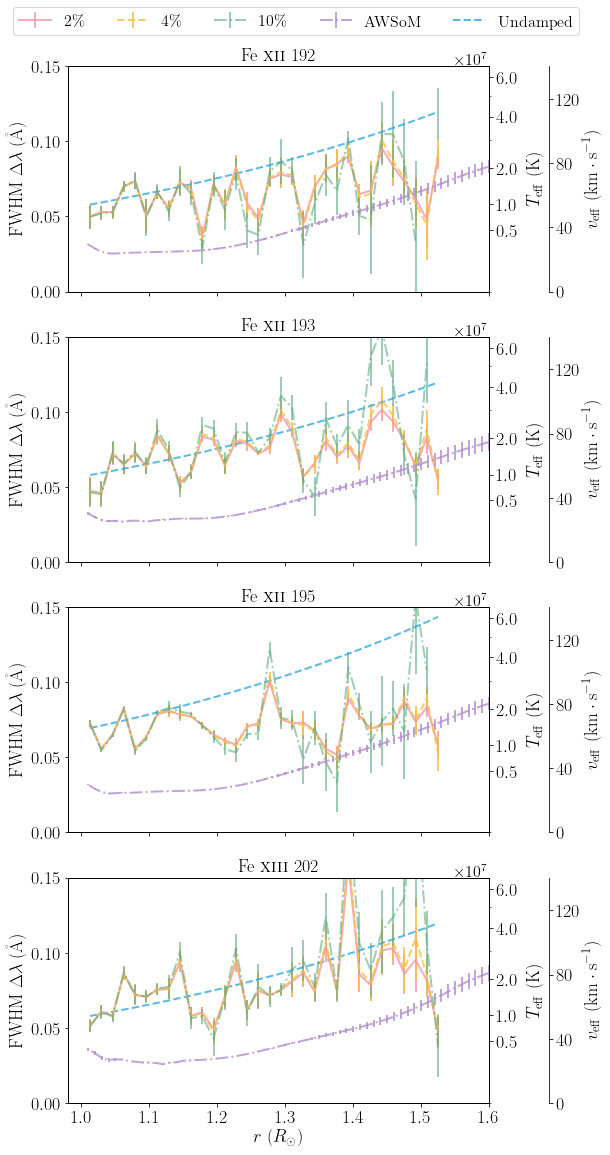

In [577]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(9,16))

x_start = (3 + 8 - (19+255) + 1242)/data_set["rsun"]
x_end = (514 - 8 - (19+255) + 1242)/data_set["rsun"]
r_coord = np.linspace(x_start,x_end,32)

#for ax_ in (ax1,ax2,ax3,ax4):
#    ax_.plot(r_coord,5*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#    ax_.fill_between(r_coord,1.1*np.power(10,ne_func(r_coord,popt[0] - perr[0],popt[1])/(-4)),
#                     25*np.power(10,ne_func(r_coord,popt[0] + perr[0],popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ln1 = ax1.errorbar(r_coord,fwhm_192_cor,yerr = fwhm_192_err,color = '#F596AA',linewidth=2,alpha=0.8,label=r'2\%')
ln2 = ax1.errorbar(r_coord,fwhm_192_cor_bs,yerr = fwhm_192_err_bs,color = '#F9BF45',linewidth=2,ls = '--',alpha=0.8,label=r'4\%')
ln3 = ax1.errorbar(r_coord,fwhm_192_cor_bbs,yerr = fwhm_192_err_bbs,color = '#5DAC81',linewidth=2,ls = '-.',alpha=0.6,label=r'10\%')
ln4 = ax1.errorbar(-awsom_y[:-1],awsom_192_fwhm[:-1],yerr = awsom_192_fwhm_err[:-1],
                   color = '#B28FCE',linewidth=2,ls = '-.',alpha=0.8,label='AWSoM')

ln5, = ax1.plot(r_coord,5*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.8,lw=2,ls = '--',label="Undamped")
#ax2.plot(r_coord,2*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#ax2.fill_between(r_coord,9*np.power(10,ne_func(r_coord,popt[0] + perr[0],popt[1])/(-4)),
#                 0.44*np.power(10,ne_func(r_coord,popt[0] - perr[0],popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ax2.errorbar(r_coord,fwhm_193_cor,yerr = fwhm_193_err,color = '#F596AA',linewidth=2,alpha=0.8)
ax2.errorbar(r_coord,fwhm_193_cor_bs,yerr = fwhm_193_err_bs,color = '#F9BF45',linewidth=2,ls = '--',alpha=0.8)
ax2.errorbar(r_coord,fwhm_193_cor_bbs,yerr = fwhm_193_err_bbs,color = '#5DAC81',linewidth=2,ls = '-.',alpha=0.6)
ax2.errorbar(-awsom_y[:-1],awsom_193_fwhm[:-1],yerr = awsom_193_fwhm_err[:-1],
                   color = '#B28FCE',linewidth=2,ls = '-.',alpha=0.8,label='AWSoM')
ax2.plot(r_coord,5*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.8,lw=2,ls = '--',label="Undamped")

#ax3.plot(r_coord,2*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#ax3.fill_between(r_coord,9*np.power(10,ne_func(r_coord,popt[0] + perr[0],popt[1])/(-4)),
#                 0.44*np.power(10,ne_func(r_coord,popt[0] - perr[0],popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ax3.errorbar(r_coord,fwhm_195_cor,yerr = fwhm_195_err,color = '#F596AA',linewidth=2,alpha=0.8)
ax3.errorbar(r_coord,fwhm_195_cor_bs,yerr = fwhm_195_err_bs,color = '#F9BF45',linewidth=2,ls = '--',alpha=0.8)
ax3.errorbar(r_coord,fwhm_195_cor_bbs,yerr = fwhm_195_err_bbs,color = '#5DAC81',linewidth=2,ls = '-.',alpha=0.6)
ax3.errorbar(-awsom_y[:-1],awsom_195_fwhm[:-1],yerr = awsom_195_fwhm_err[:-1],
                   color = '#B28FCE',linewidth=2,ls = '-.',alpha=0.8,label='AWSoM')
ax3.plot(r_coord,6*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.8,lw=2,ls = '--',label="Undamped")

#ax4.plot(r_coord,2*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#ax4.fill_between(r_coord,9*np.power(10,ne_func(r_coord,popt[0] + perr[0],popt[1])/(-4)),
#                 0.44*np.power(10,ne_func(r_coord,popt[0] - perr[0],popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ax4.errorbar(r_coord,fwhm_202_cor,yerr = fwhm_202_err,color = '#F596AA',linewidth=2,alpha=0.8)
ax4.errorbar(r_coord,fwhm_202_cor_bs,yerr = fwhm_202_err_bs,color = '#F9BF45',linewidth=2,ls = '--',alpha=0.8)
ax4.errorbar(r_coord,fwhm_202_cor_bbs,yerr = fwhm_202_err_bbs,color = '#5DAC81',linewidth=2,ls = '-.',alpha=0.6)
ax4.errorbar(-awsom_y[:-1],awsom_202_fwhm[:-1],yerr = awsom_202_fwhm_err[:-1],
                   color = '#B28FCE',linewidth=2,ls = '-.',alpha=0.8,label='AWSoM')
ax4.plot(r_coord,5*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.8,lw=2,ls = '--',label="Undamped")

ax1.set_title(r"Fe \textsc{xii} 192",fontsize=18)
ax2.set_title(r"Fe \textsc{xii} 193",fontsize=18)
ax3.set_title(r"Fe \textsc{xii} 195",fontsize=18)
ax4.set_title(r"Fe \textsc{xiii} 202",fontsize=18)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
for ax_ in (ax1,ax2,ax3,ax4):
    ax_.set_ylim((0,0.15))
    ax_.set_yticks([0.0,0.05,0.10,0.15])
    

ax1_t = ax1.twinx()
ax1_v = ax1.twinx()
ax1_v.spines['right'].set_position(('outward', 60))    

ax2_t = ax2.twinx()
ax2_v = ax2.twinx()
ax2_v.spines['right'].set_position(('outward', 60))  

ax3_t = ax3.twinx()
ax3_v = ax3.twinx()
ax3_v.spines['right'].set_position(('outward', 60))  

ax4_t = ax4.twinx()
ax4_v = ax4.twinx()
ax4_v.spines['right'].set_position(('outward', 60))  


ax1_t_ticks = np.square(np.array([0.,0.05,0.10,0.15])/192.394*c)*56*amu/2/k_B/(4*np.log(2))
ax1_v_ticks = np.array([0.,0.05,0.10,0.15])/192.394*c/np.sqrt(4*np.log(2))/1.e5

def forward(x):
    return x**(1/2)
def inverse(x):
    return x**2

for ax_ in (ax1_t,ax2_t,ax3_t,ax4_t):
    ax_.set_ylim(ax1_t_ticks[0],ax1_t_ticks[-1])
    ax_.set_yscale('function', functions=(forward, inverse))
    #ax_.set_yticklabels(ax1_t_ticks)
    ax_.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.set_ylabel(r'$T_{\rm eff}$ (K)',fontsize = 18,labelpad=10)
    ax_.yaxis.set_minor_locator(ticker.MaxNLocator(7))
    ax_.set_yticks([5e6,1e7,2e7,4e7,6e7])

for ax_ in (ax1_v,ax2_v,ax3_v,ax4_v):
    ax_.set_ylim((ax1_v_ticks[0],ax1_v_ticks[-1]))
    ax_.set_ylabel(r'$v_{\rm eff}\ (\mathrm{km\cdot s^{-1}})$',fontsize = 18)
    ax_.yaxis.set_major_locator(ticker.MaxNLocator(4))

for ax_ in (ax1,ax2,ax3,ax1_t,ax1_v,ax2_t,ax2_v,ax3_t,ax3_v,ax4_t,ax4_v):
    #ax_.set_xlabel(r'',fontsize=24)
    #ax_.set_ylabel(r'',fontsize=24)
    ax_.tick_params(labelsize=18)

for ax_ in (ax1,ax2,ax3):
    ax_.set_ylabel(r'FWHM $\Delta \lambda\ (\mathrm{\AA})$',fontsize =18)
ax3.set_xlabel(r'$r\ (R_\odot)$',fontsize=18)


leg = [ln1,ln2,ln3,ln4,ln5]
ax1.legend(leg,[leg_.get_label() for leg_ in leg],bbox_to_anchor=(-0.15,1.1,1,0.2), loc="upper left",fontsize = 16,ncol=5)

for ax_ in (ax1,ax2,ax3,ax4):
    ax_.set_xlabel(r'',fontsize=18)
    ax_.set_ylabel(r'FWHM $\Delta \lambda\ (\mathrm{\AA})$',fontsize =18)
    ax_.tick_params(labelsize=18)
    ax_.set_xlim(0.98,1.6)
ax4.set_xlabel(r'$r\ (R_\odot)$',fontsize=18)
plt.subplots_adjust(bottom = 0.05,left=0.15,top=0.95,right=0.8)
#plt.savefig(fname = '../figs/eis_awsom_11.png', dpi = 300, format = 'png')
#plt.savefig(fname = '../figs/eis_awsom_11.pdf', dpi = 300, format = 'pdf')

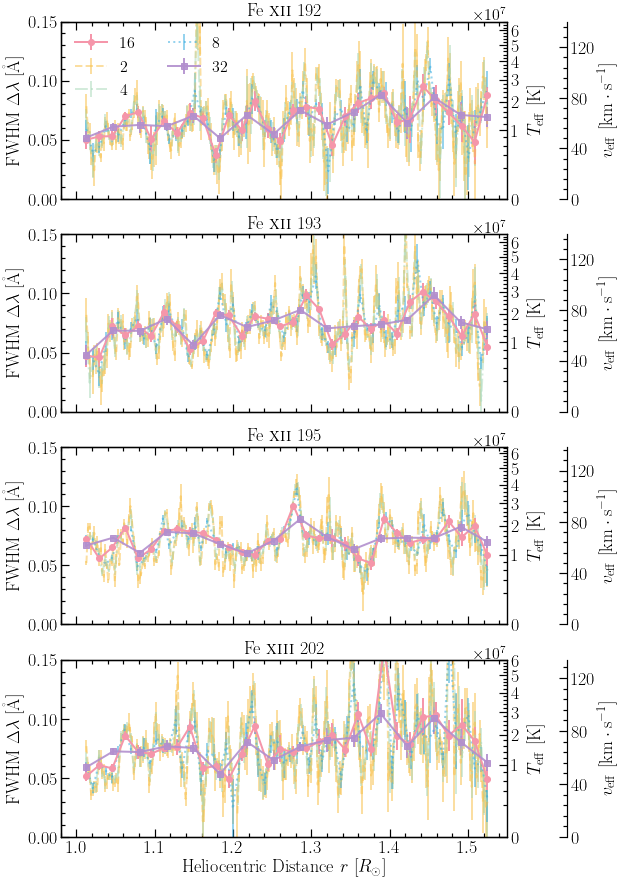

In [219]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(8,15))

x_start = (3 + 8 - (19+255) + 1242)/data_set["rsun"]
x_end = (514 - 8 - (19+255) + 1242)/data_set["rsun"]
x_start_2 = (3 + 1 - (19+255) + 1242)/data_set["rsun"]
x_end_2 = (514 - 1 - (19+255) + 1242)/data_set["rsun"]
x_start_4 = (3 + 2 - (19+255) + 1242)/data_set["rsun"]
x_end_4 = (514 - 2 - (19+255) + 1242)/data_set["rsun"]
x_start_8 = (3 + 4 - (19+255) + 1242)/data_set["rsun"]
x_end_8 = (514 - 4 - (19+255) + 1242)/data_set["rsun"]
x_start_32 = (3 + 16 - (19+255) + 1242)/data_set["rsun"]
x_end_32 = (514 - 16 - (19+255) + 1242)/data_set["rsun"]
r_coord = np.linspace(x_start,x_end,32)
r_coord_2 = np.linspace(x_start,x_end,256)
r_coord_4 = np.linspace(x_start,x_end,128)
r_coord_8 = np.linspace(x_start,x_end,64)
r_coord_32 = np.linspace(x_start,x_end,16)

#for ax_ in (ax1,ax2,ax3,ax4):
#    ax_.plot(r_coord,5*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#    ax_.fill_between(r_coord,1.1*np.power(10,ne_func(r_coord,popt[0] - perr[0],popt[1])/(-4)),
#                     25*np.power(10,ne_func(r_coord,popt[0] + perr[0],popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)


ln2 = ax1.errorbar(r_coord_2,fwhm_192_cor_2,yerr = fwhm_192_err_2,color = '#F9BF45',linewidth=2,ls = '--',alpha=0.5,label='2')
ln3 = ax1.errorbar(r_coord_4,fwhm_192_cor_4,yerr = fwhm_192_err_4,color = '#A8D8B9',linewidth=2,ls = '-.',alpha=0.5,label='4')
ln4 = ax1.errorbar(r_coord_8,fwhm_192_cor_8,yerr = fwhm_192_err_8,color = "#2EA9DF",linewidth=2,ls = ':',alpha=0.5,label='8')
ln1 = ax1.errorbar(r_coord,fwhm_192_cor,yerr = fwhm_192_err,color = '#F596AA',linewidth=2,label='16',marker="o")
ln5 = ax1.errorbar(r_coord_32,fwhm_192_cor_32,yerr = fwhm_192_err_32,color = "#B28FCE",linewidth=2,ls = '-',label='32',marker="s",alpha=0.9)

#ax2.plot(r_coord,2*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#ax2.fill_between(r_coord,9*np.power(10,ne_func(r_coord,popt[0] + perr[0],popt[1])/(-4)),
#                 0.44*np.power(10,ne_func(r_coord,popt[0] - perr[0],popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)


ax2.errorbar(r_coord_2,fwhm_193_cor_2,yerr = fwhm_193_err_2,color = '#F9BF45',linewidth=2,ls = '--',alpha=0.5)
ax2.errorbar(r_coord_4,fwhm_193_cor_4,yerr = fwhm_193_err_4,color = '#A8D8B9',linewidth=2,ls = '-.',alpha=0.5)
ax2.errorbar(r_coord_8,fwhm_193_cor_8,yerr = fwhm_193_err_8,color = "#2EA9DF",linewidth=2,ls = ':',alpha=0.5)
ax2.errorbar(r_coord,fwhm_193_cor,yerr = fwhm_193_err,color = '#F596AA',linewidth=2,marker="o")
ax2.errorbar(r_coord_32,fwhm_193_cor_32,yerr = fwhm_193_err_32,color = "#B28FCE",linewidth=2,ls = '-',marker="s",alpha=0.9)


#ax3.plot(r_coord,2*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#ax3.fill_between(r_coord,9*np.power(10,ne_func(r_coord,popt[0] + perr[0],popt[1])/(-4)),
#                 0.44*np.power(10,ne_func(r_coord,popt[0] - perr[0],popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ax3.errorbar(r_coord_2,fwhm_195_cor_2,yerr = fwhm_195_err_2,color = '#F9BF45',linewidth=2,ls = '--',alpha=0.5)
ax3.errorbar(r_coord_4,fwhm_195_cor_4,yerr = fwhm_195_err_4,color = '#A8D8B9',linewidth=2,ls = '-.',alpha=0.5)
ax3.errorbar(r_coord_8,fwhm_195_cor_8,yerr = fwhm_195_err_8,color = "#2EA9DF",linewidth=2,ls = ':',alpha=0.5)
ax3.errorbar(r_coord,fwhm_195_cor,yerr = fwhm_195_err,color = '#F596AA',linewidth=2,marker="o")
ax3.errorbar(r_coord_32,fwhm_195_cor_32,yerr = fwhm_195_err_32,color = "#B28FCE",linewidth=2,ls = '-',marker="s",alpha=0.9)

#ax4.plot(r_coord,2*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#ax4.fill_between(r_coord,9*np.power(10,ne_func(r_coord,popt[0] + perr[0],popt[1])/(-4)),
#                 0.44*np.power(10,ne_func(r_coord,popt[0] - perr[0],popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)


ax4.errorbar(r_coord_2,fwhm_202_cor_2,yerr = fwhm_202_err_2,color = '#F9BF45',linewidth=2,ls = '--',alpha=0.5)
ax4.errorbar(r_coord_4,fwhm_202_cor_4,yerr = fwhm_202_err_4,color = '#A8D8B9',linewidth=2,ls = '-.',alpha=0.5)
ax4.errorbar(r_coord_8,fwhm_202_cor_8,yerr = fwhm_202_err_8,color = "#2EA9DF",linewidth=2,ls = ':',alpha=0.5)
ax4.errorbar(r_coord,fwhm_202_cor,yerr = fwhm_202_err,color = '#F596AA',linewidth=2,marker="o")
ax4.errorbar(r_coord_32,fwhm_202_cor_32,yerr = fwhm_202_err_32,color = "#B28FCE",linewidth=2,ls = '-',marker="s",alpha=0.9)

ax1.set_title(r"Fe \textsc{xii} 192",fontsize=18)
ax2.set_title(r"Fe \textsc{xii} 193",fontsize=18)
ax3.set_title(r"Fe \textsc{xii} 195",fontsize=18)
ax4.set_title(r"Fe \textsc{xiii} 202",fontsize=18)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
for ax_ in (ax1,ax2,ax3,ax4):
    ax_.set_ylim((0,0.15))
    ax_.set_yticks([0.0,0.05,0.10,0.15])
    

ax1_t = ax1.twinx()
ax1_v = ax1.twinx()
ax1_v.spines['right'].set_position(('outward', 60))    

ax2_t = ax2.twinx()
ax2_v = ax2.twinx()
ax2_v.spines['right'].set_position(('outward', 60))  

ax3_t = ax3.twinx()
ax3_v = ax3.twinx()
ax3_v.spines['right'].set_position(('outward', 60))  

ax4_t = ax4.twinx()
ax4_v = ax4.twinx()
ax4_v.spines['right'].set_position(('outward', 60))  


#ax1_t_ticks = np.square(np.array([0.,0.05,0.10,0.15])/192.394*c)*56*amu/2/k_B/(4*np.log(2))
#ax1_v_ticks = np.array([0.,0.05,0.10,0.15])/192.394*c/np.sqrt(4*np.log(2))/1.e5

def forward(x):
    return x**(1/2)
def inverse(x):
    return x**2

line_lambda0 = np.array([192.394,193.509,195.119,202.044])
for ii,ax_ in enumerate((ax1_t,ax2_t,ax3_t,ax4_t)):
    ax_t_ticks = np.square(np.array([0.,0.05,0.10,0.15])/line_lambda0[ii]*c)*56*amu/2/k_B/(4*np.log(2))
    ax_.set_ylim(ax_t_ticks[0],ax_t_ticks[-1])
    ax_.set_yscale('function', functions=(forward, inverse))
    #ax_.set_yticklabels(ax1_t_ticks)
    ax_.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.set_ylabel(r'$T_{\rm eff}$ [K]',fontsize = 18,labelpad=10)
    ax_.yaxis.set_major_locator(ticker.MaxNLocator(8))
ax4_t.yaxis.set_major_locator(ticker.MaxNLocator(7))

for ii,ax_ in enumerate((ax1_v,ax2_v,ax3_v,ax4_v)):
    ax_v_ticks = np.array([0.,0.05,0.10,0.15])/line_lambda0[ii]*c/np.sqrt(4*np.log(2))/1.e5
    ax_.set_ylim((ax_v_ticks[0],ax_v_ticks[-1]))
    ax_.set_ylabel(r'$v_{\rm eff}\ [\mathrm{km\cdot s^{-1}}]$',fontsize = 18)
    ax_.yaxis.set_major_locator(ticker.MaxNLocator(4))

for ax_ in (ax1,ax2,ax3,ax1_t,ax1_v,ax2_t,ax2_v,ax3_t,ax3_v,ax4_t,ax4_v):
    #ax_.set_xlabel(r'',fontsize=24)
    #ax_.set_ylabel(r'',fontsize=24)
    ax_.tick_params(labelsize=18)
    ax_.tick_params(which="major",width=1.2,length=8)
    ax_.tick_params(which="minor",width=1.2,length=4)
    ax_.yaxis.set_minor_locator(AutoMinorLocator(5))

for ax_ in (ax1,ax2,ax3):
    ax_.set_ylabel(r'FWHM $\Delta \lambda\ [\mathrm{\AA}]$',fontsize =18)


leg = [ln1,ln2,ln3,ln4,ln5]
ax1.legend(leg,[leg_.get_label() for leg_ in leg], loc="upper left",fontsize = 16,ncol=2)

for ax_ in (ax1,ax2,ax3,ax4):
    ax_.set_xlabel(r'',fontsize=18)
    ax_.set_ylabel(r'FWHM $\Delta \lambda\ [\mathrm{\AA}]$',fontsize =18)
    ax_.tick_params(labelsize=18)
    ax_.tick_params(which="major",width=1.2,length=8)
    ax_.tick_params(which="minor",width=1.2,length=4)
    ax_.set_xlim(0.98,1.55)
    ax_.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax_.yaxis.set_minor_locator(AutoMinorLocator(5))
ax4.set_xlabel(r'Heliocentric Distance $r\ [R_\odot]$',fontsize=18)
#plt.subplots_adjust(bottom = 0.05,left=0.15,top=0.94,right=0.8)
plt.savefig(fname = '../figs/eis_awsom_diff_pixel.png', dpi = 300, format = 'png')
plt.savefig(fname = '../figs/eis_awsom_diff_pixel.pdf', dpi = 300, format = 'pdf')

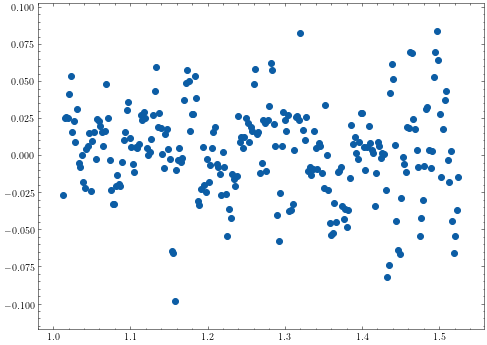

In [132]:
fig,ax=plt.subplots(figsize=(8,6))
ax.scatter(r_coord_2,fwhm_195_cor_2-fwhm_192_cor_2)

In [834]:
bk.create_dataset("r_coord_2",data=r_coord_2)

<HDF5 dataset "r_coord_2": shape (256,), type "<f8">

In [317]:
bk.create_dataset("line_cent_pos",data=line_cent_pos)
bk.create_dataset("line_cent_195_down_mcmc",data=line_cent_195_down_mcmc)
bk.create_dataset("line_cent_195_up_mcmc",data=line_cent_195_up_mcmc)

OverflowError: can't convert negative value to hsize_t

In [318]:
bk.create_dataset("popt_FeXII",data=popt_FeXII)
bk.create_dataset("perr_FeXII",data=perr_FeXII)
bk.create_dataset("popt",data=popt)
bk.create_dataset("perr",data=perr)

<HDF5 dataset "perr": shape (2,), type "<f8">

In [315]:
bk.create_dataset("fwhm_192_cor_mcmc",data=fwhm_192_cor_mcmc)
bk.create_dataset("fwhm_192_err_down_mcmc",data=fwhm_192_err_down_mcmc)
bk.create_dataset("fwhm_192_err_up_mcmc",data=fwhm_192_err_up_mcmc)
bk.create_dataset("fwhm_192_cor_bs_mcmc",data=fwhm_192_cor_bs_mcmc)
bk.create_dataset("fwhm_192_err_bs_down_mcmc",data=fwhm_192_err_bs_down_mcmc)
bk.create_dataset("fwhm_192_err_bs_up_mcmc",data=fwhm_192_err_bs_up_mcmc)
bk.create_dataset("fwhm_192_cor_bbs_mcmc",data=fwhm_192_cor_bbs_mcmc)
bk.create_dataset("fwhm_192_err_bbs_down_mcmc",data=fwhm_192_err_bs_down_mcmc)
bk.create_dataset("fwhm_192_err_bbs_up_mcmc",data=fwhm_192_err_bbs_up_mcmc)
bk.create_dataset("fwhm_193_cor_mcmc",data=fwhm_193_cor_mcmc)
bk.create_dataset("fwhm_193_err_down_mcmc",data=fwhm_193_err_down_mcmc)
bk.create_dataset("fwhm_193_err_up_mcmc",data=fwhm_193_err_up_mcmc)
bk.create_dataset("fwhm_193_cor_bs_mcmc",data=fwhm_193_cor_bs_mcmc)
bk.create_dataset("fwhm_193_err_bs_down_mcmc",data=fwhm_193_err_bs_down_mcmc)
bk.create_dataset("fwhm_193_err_bs_up_mcmc",data=fwhm_193_err_bs_up_mcmc)
bk.create_dataset("fwhm_193_cor_bbs_mcmc",data=fwhm_193_cor_bbs_mcmc)
bk.create_dataset("fwhm_193_err_bbs_down_mcmc",data=fwhm_193_err_bs_down_mcmc)
bk.create_dataset("fwhm_193_err_bbs_up_mcmc",data=fwhm_193_err_bbs_up_mcmc)
bk.create_dataset("fwhm_195_cor_mcmc",data=fwhm_195_cor_mcmc)
bk.create_dataset("fwhm_195_err_down_mcmc",data=fwhm_195_err_down_mcmc)
bk.create_dataset("fwhm_195_err_up_mcmc",data=fwhm_195_err_up_mcmc)
bk.create_dataset("fwhm_195_cor_bs_mcmc",data=fwhm_195_cor_bs_mcmc)
bk.create_dataset("fwhm_195_err_bs_down_mcmc",data=fwhm_195_err_bs_down_mcmc)
bk.create_dataset("fwhm_195_err_bs_up_mcmc",data=fwhm_195_err_bs_up_mcmc)
bk.create_dataset("fwhm_195_cor_bbs_mcmc",data=fwhm_195_cor_bbs_mcmc)
bk.create_dataset("fwhm_195_err_bbs_down_mcmc",data=fwhm_195_err_bs_down_mcmc)
bk.create_dataset("fwhm_195_err_bbs_up_mcmc",data=fwhm_195_err_bbs_up_mcmc)
bk.create_dataset("fwhm_202_cor_mcmc",data=fwhm_202_cor_mcmc)
bk.create_dataset("fwhm_202_err_down_mcmc",data=fwhm_202_err_down_mcmc)
bk.create_dataset("fwhm_202_err_up_mcmc",data=fwhm_202_err_up_mcmc)
bk.create_dataset("fwhm_202_cor_bs_mcmc",data=fwhm_202_cor_bs_mcmc)
bk.create_dataset("fwhm_202_err_bs_down_mcmc",data=fwhm_202_err_bs_down_mcmc)
bk.create_dataset("fwhm_202_err_bs_up_mcmc",data=fwhm_202_err_bs_up_mcmc)
bk.create_dataset("fwhm_202_cor_bbs_mcmc",data=fwhm_202_cor_bbs_mcmc)
bk.create_dataset("fwhm_202_err_bbs_down_mcmc",data=fwhm_202_err_bs_down_mcmc)
bk.create_dataset("fwhm_202_err_bbs_up_mcmc",data=fwhm_202_err_bbs_up_mcmc)

<HDF5 dataset "fwhm_202_err_bbs_up_mcmc": shape (32,), type "<f8">

In [316]:
bk.create_dataset("r_coord_4",data=r_coord_4)
bk.create_dataset("r_coord_8",data=r_coord_8)
bk.create_dataset("r_coord_32",data=r_coord_32)
bk.create_dataset("fwhm_192_cor",data=fwhm_192_cor)
bk.create_dataset("fwhm_192_err",data=fwhm_192_err)
bk.create_dataset("fwhm_192_cor_2",data=fwhm_192_cor_2)
bk.create_dataset("fwhm_192_err_2",data=fwhm_192_err_2)
bk.create_dataset("fwhm_192_cor_4",data=fwhm_192_cor_4)
bk.create_dataset("fwhm_192_err_4",data=fwhm_192_err_4)
bk.create_dataset("fwhm_192_cor_8",data=fwhm_192_cor_8)
bk.create_dataset("fwhm_192_err_8",data=fwhm_192_err_8)
bk.create_dataset("fwhm_192_cor_32",data=fwhm_192_cor_32)
bk.create_dataset("fwhm_192_err_32",data=fwhm_192_err_32)
bk.create_dataset("fwhm_193_cor",data=fwhm_193_cor)
bk.create_dataset("fwhm_193_err",data=fwhm_193_err)
bk.create_dataset("fwhm_193_cor_2",data=fwhm_193_cor_2)
bk.create_dataset("fwhm_193_err_2",data=fwhm_193_err_2)
bk.create_dataset("fwhm_193_cor_4",data=fwhm_193_cor_4)
bk.create_dataset("fwhm_193_err_4",data=fwhm_193_err_4)
bk.create_dataset("fwhm_193_cor_8",data=fwhm_193_cor_8)
bk.create_dataset("fwhm_193_err_8",data=fwhm_193_err_8)
bk.create_dataset("fwhm_193_cor_32",data=fwhm_193_cor_32)
bk.create_dataset("fwhm_193_err_32",data=fwhm_193_err_32)
bk.create_dataset("fwhm_195_cor",data=fwhm_195_cor)
bk.create_dataset("fwhm_195_err",data=fwhm_195_err)
bk.create_dataset("fwhm_195_cor_2",data=fwhm_195_cor_2)
bk.create_dataset("fwhm_195_err_2",data=fwhm_195_err_2)
bk.create_dataset("fwhm_195_cor_4",data=fwhm_195_cor_4)
bk.create_dataset("fwhm_195_err_4",data=fwhm_195_err_4)
bk.create_dataset("fwhm_195_cor_8",data=fwhm_195_cor_8)
bk.create_dataset("fwhm_195_err_8",data=fwhm_195_err_8)
bk.create_dataset("fwhm_195_cor_32",data=fwhm_195_cor_32)
bk.create_dataset("fwhm_195_err_32",data=fwhm_195_err_32)
bk.create_dataset("fwhm_202_cor",data=fwhm_202_cor)
bk.create_dataset("fwhm_202_err",data=fwhm_202_err)
bk.create_dataset("fwhm_202_cor_2",data=fwhm_202_cor_2)
bk.create_dataset("fwhm_202_err_2",data=fwhm_202_err_2)
bk.create_dataset("fwhm_202_cor_4",data=fwhm_202_cor_4)
bk.create_dataset("fwhm_202_err_4",data=fwhm_202_err_4)
bk.create_dataset("fwhm_202_cor_8",data=fwhm_202_cor_8)
bk.create_dataset("fwhm_202_err_8",data=fwhm_202_err_8)
bk.create_dataset("fwhm_202_cor_32",data=fwhm_202_cor_32)
bk.create_dataset("fwhm_202_err_32",data=fwhm_202_err_32)

<HDF5 dataset "fwhm_202_err_32": shape (16,), type "<f8">

In [319]:
bk.close()